In [1]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

     |████████████████████████████████| 1.9 MB 8.8 MB/s 
     |████████████████████████████████| 831.4 MB 2.5 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [5]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [6]:
AUD_PATH = '/content/drive/MyDrive/Annamayya'
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [7]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 60 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

data['Offset'].fillna(60,inplace=True)

In [8]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [9]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [10]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
మలహరి           20
ధన్నాసి         20
కాంబోది         19
మాళవిగౌళ        18
మాళవి           18
గుజ్జరి         15
కన్నడగౌళ        15
గౌళ             14
బౌళిరామక్రియ    13
నాదరామక్రియ     11
సాళంగం          11
Name: Ragam, dtype: int64

In [11]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


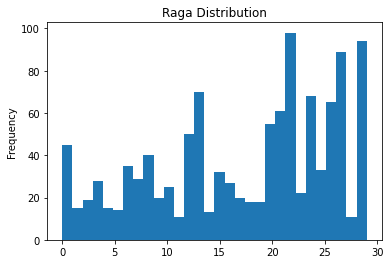

In [12]:
for c in le.classes_: print(f'{c} : {le.transform([c])}')
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [13]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [14]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [15]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [16]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [17]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [18]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [19]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [20]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [21]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - MELS Feed Forward

In [22]:
FREQ = 16000
DURATION = 120
mel_tx = transforms.MelSpectrogram(FREQ,n_mels=40)
def get_mels(x, aud_path, mel_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mel = mel_tx(waveform)
  else:
    mel = []
  return mel
data['mel_spec'] = data.apply(lambda x:get_mels(x, AUD_PATH, mel_tx),axis=1)

In [23]:
data = data[data.apply(lambda x:not isinstance(x['mel_spec'],list),axis=1)]

In [24]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals)
      test_data = MelMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [25]:
class MelRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MEL Spectrogram Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(384000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [26]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 4.131 / Validation Loss : 4.836 [Time Taken : 3.22081 seconds]
Epoch 2/15 : Training Loss: 2.577 / Validation Loss : 5.134 [Time Taken : 3.218226 seconds]
Epoch 3/15 : Training Loss: 2.046 / Validation Loss : 5.220 [Time Taken : 3.232193 seconds]
Epoch 4/15 : Training Loss: 1.713 / Validation Loss : 5.350 [Time Taken : 3.224625 seconds]
Epoch 5/15 : Training Loss: 1.291 / Validation Loss : 5.744 [Time Taken : 3.209026 seconds]
Epoch 6/15 : Training Loss: 1.481 / Validation Loss : 5.687 [Time Taken : 3.211074 seconds]
Epoch 7/15 : Training Loss: 1.079 / Validation Loss : 5.926 [Time Taken : 3.211843 seconds]
Epoch 8/15 : Training Loss: 1.029 / Validation Loss : 6.169 [Time Taken : 3.221874 seconds]
Epoch 9/15 : Training Loss: 0.860 / Validation Loss : 6.050 [Time Taken : 3.223246 seconds]
Epoch 10/15 : Training Loss: 0.752 / Val

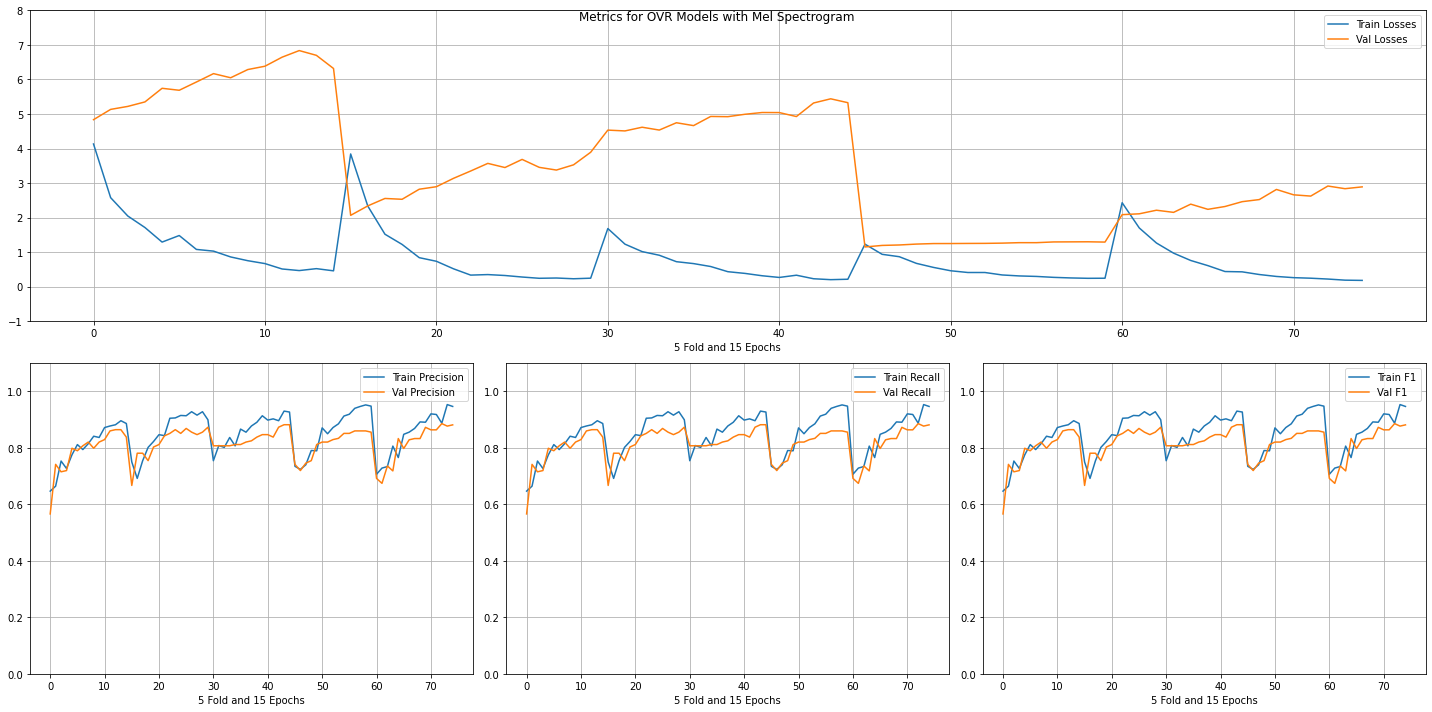

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.887061       0.885463  ...      0.220530           2.914443
13  0.929748       0.881579  ...      0.202822           5.439974
14  0.926454       0.881579  ...      0.215044           5.327569
14  0.946272       0.881057  ...      0.181549           2.890033
13  0.952851       0.876652  ...      0.188458           2.837072
..       ...            ...  ...           ...                ...
2   0.753019       0.714912  ...      2.046180           5.219982
0   0.706140       0.691630  ...      2.430693           2.085124
1   0.728070       0.674009  ...      1.699476           2.109961
0   0.749726       0.666667  ...      3.842828           2.065649
0   0.646542       0.565789  ...      4.131190           4.835596

[75 rows x 8 columns]
Training for ['కన్నడగౌళ'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 6.062 / Validation Lo

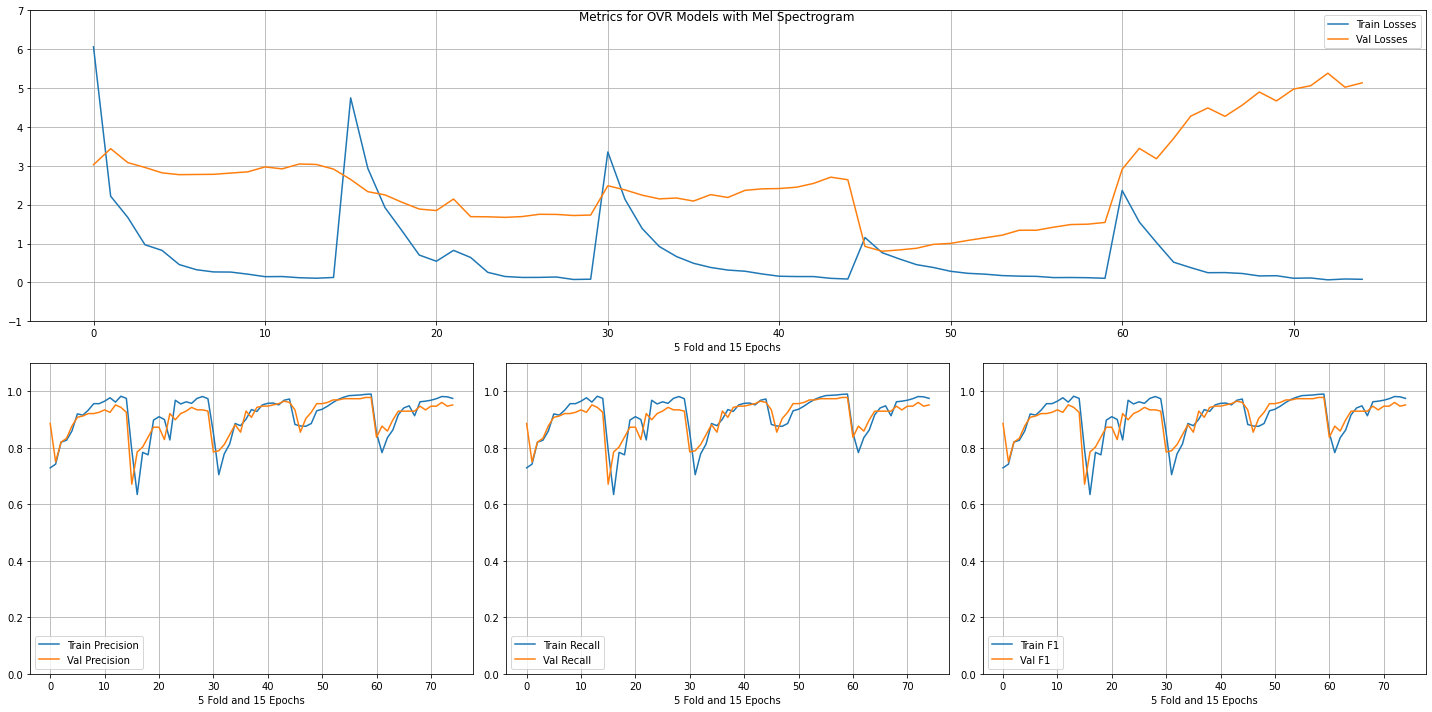

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.989023       0.978070  ...      0.119467           1.497123
14  0.990121       0.978070  ...      0.104329           1.542797
12  0.986828       0.973684  ...      0.124569           1.487753
11  0.985730       0.973684  ...      0.122425           1.419740
10  0.984632       0.973684  ...      0.154258           1.341329
..       ...            ...  ...           ...                ...
1   0.704720       0.789474  ...      2.137823           2.380272
0   0.852909       0.785088  ...      3.356203           2.486488
1   0.634468       0.785088  ...      2.935317           2.334013
1   0.742042       0.750000  ...      2.217770           3.440864
0   0.791438       0.671053  ...      4.749039           2.648549

[75 rows x 8 columns]
Training for ['కాంబోది'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50848214 29.97368421]
Epoch 1/15 : Training Loss: 5.707 / Validation Los

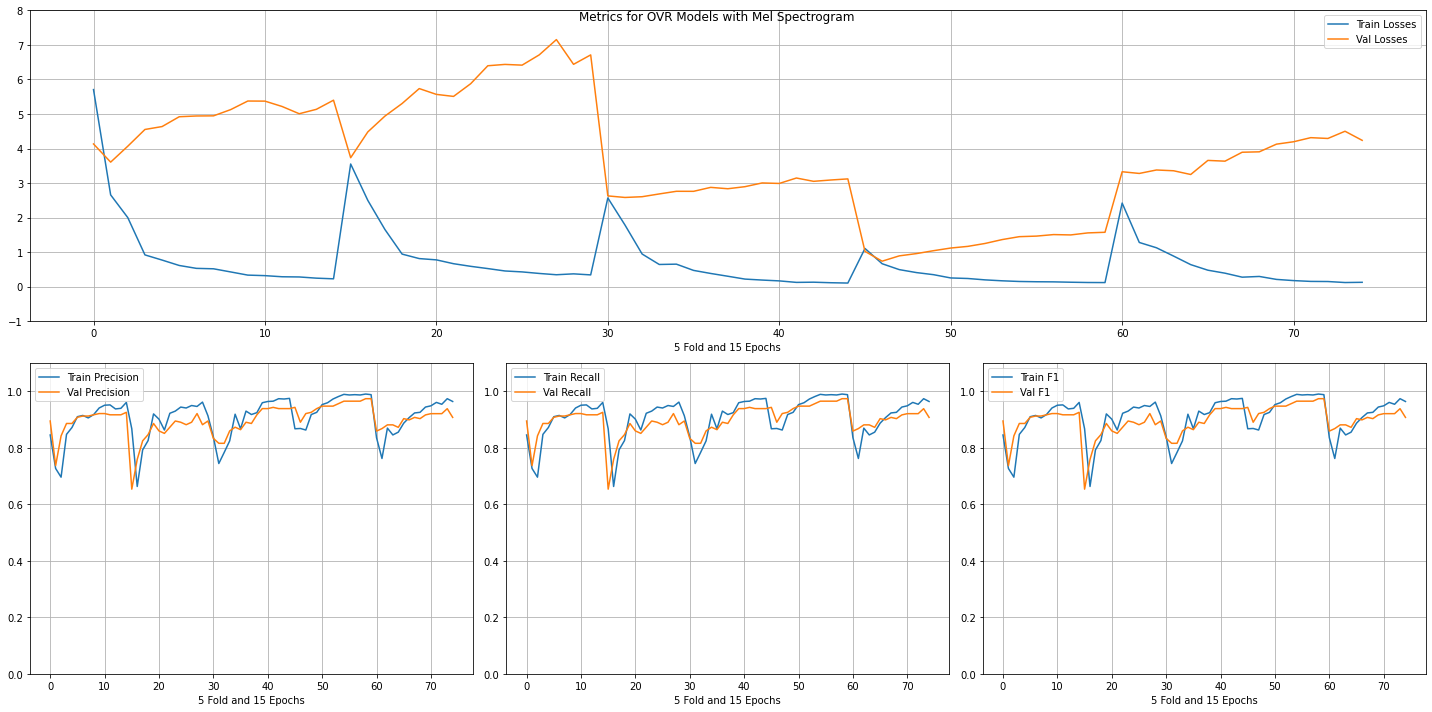

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.987925       0.973684  ...      0.118548           1.574938
13  0.990121       0.973684  ...      0.120651           1.557050
9   0.989023       0.964912  ...      0.150342           1.447854
10  0.986828       0.964912  ...      0.142535           1.464046
11  0.987925       0.964912  ...      0.139037           1.508109
..       ...            ...  ...           ...                ...
1   0.744237       0.815789  ...      1.785274           2.583287
2   0.783754       0.815789  ...      0.945598           2.604814
1   0.663008       0.758772  ...      2.498697           4.481231
1   0.726674       0.736842  ...      2.657678           3.606286
0   0.867179       0.653509  ...      3.551984           3.733986

[75 rows x 8 columns]
Training for ['గుండుక్రియ'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51260126 20.33928571]
Epoch 1/15 : Training Loss: 3.747 / Validation 

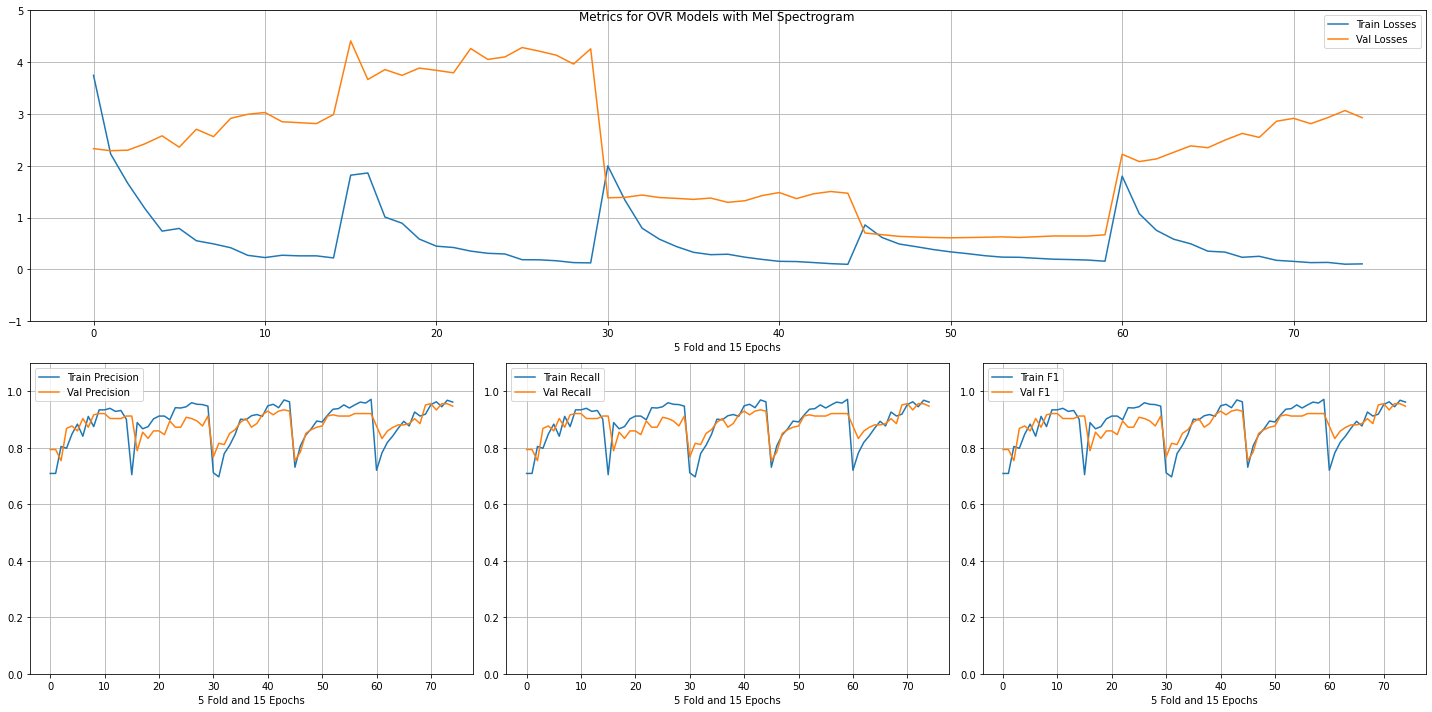

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.968202       0.955947  ...      0.100591           3.066703
12  0.945175       0.955947  ...      0.134660           2.930917
10  0.952851       0.955947  ...      0.154753           2.916380
9   0.918860       0.951542  ...      0.174938           2.859651
14  0.961623       0.947137  ...      0.106437           2.928657
..       ...            ...  ...           ...                ...
1   0.889133       0.789474  ...      1.861698           3.665488
1   0.806806       0.785088  ...      0.614692           0.670315
0   0.711306       0.767544  ...      1.998533           1.382014
0   0.731065       0.754386  ...      0.858441           0.702203
2   0.804610       0.754386  ...      1.660646           2.301603

[75 rows x 8 columns]
Training for ['గుజ్జరి'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 2.642 / Validation Los

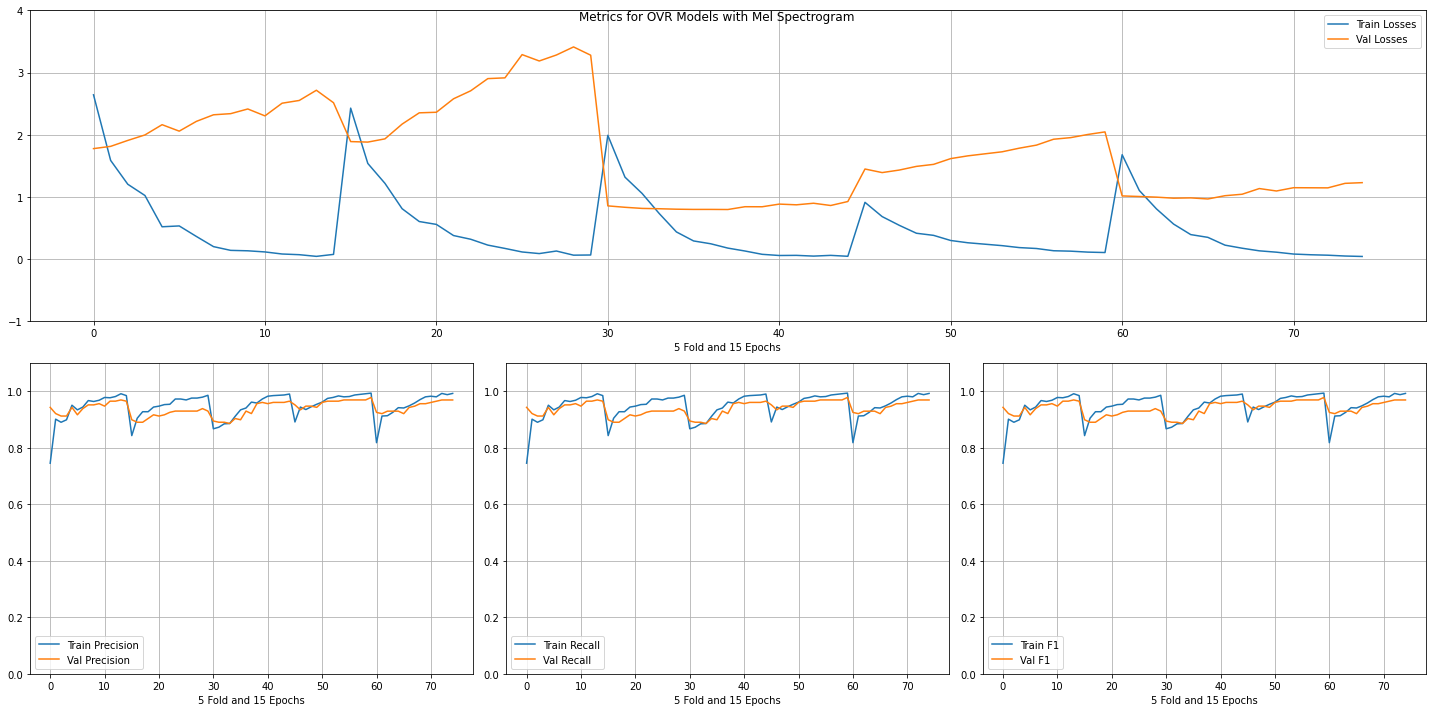

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.993414       0.978070  ...      0.104596           2.045425
13  0.991218       0.969298  ...      0.111348           2.004050
13  0.991218       0.969298  ...      0.043055           2.715301
9   0.980241       0.969298  ...      0.184155           1.783532
10  0.981339       0.969298  ...      0.169525           1.832535
..       ...            ...  ...           ...                ...
2   0.884742       0.890351  ...      1.054790           0.814545
1   0.904501       0.890351  ...      1.537718           1.881408
1   0.872667       0.890351  ...      1.317429           0.832604
2   0.927552       0.890351  ...      1.217552           1.933442
3   0.885840       0.885965  ...      0.731542           0.809182

[75 rows x 8 columns]
Training for ['గౌళ'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50622222 40.67857143]
Epoch 1/15 : Training Loss: 4.289 / Validation Loss : 

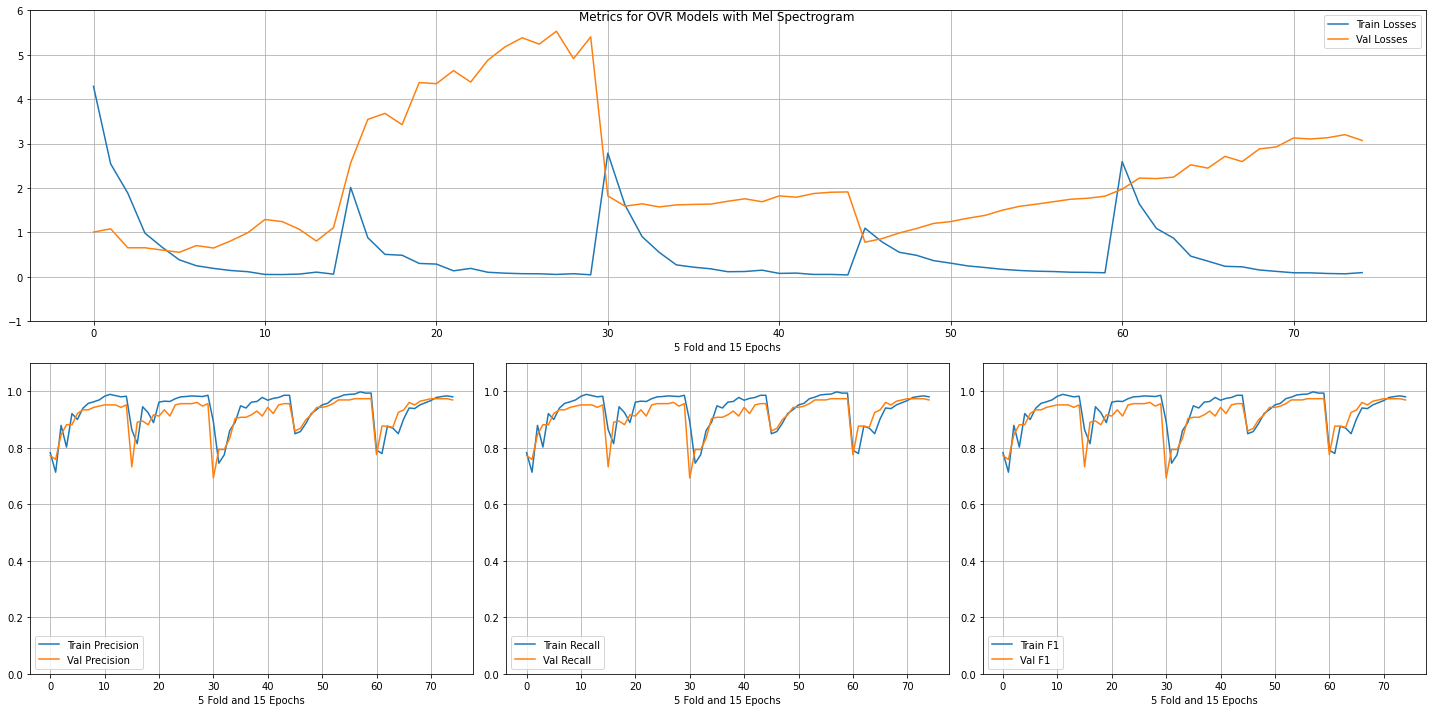

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.990121       0.973684  ...      0.118304           1.691544
12  0.997805       0.973684  ...      0.103260           1.747094
14  0.993414       0.973684  ...      0.091074           1.816792
13  0.993414       0.973684  ...      0.099183           1.769075
13  0.983553       0.973568  ...      0.067368           3.201639
..       ...            ...  ...           ...                ...
0   0.791667       0.775330  ...      2.595109           1.973413
0   0.782656       0.771930  ...      4.289449           1.006557
1   0.713502       0.758772  ...      2.543479           1.081106
0   0.863886       0.732456  ...      2.013357           2.563724
0   0.892426       0.692982  ...      2.785480           1.822891

[75 rows x 8 columns]
Training for ['దేవగాంధారి'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51585145 16.27142857]
Epoch 1/15 : Training Loss: 4.511 / Validation 

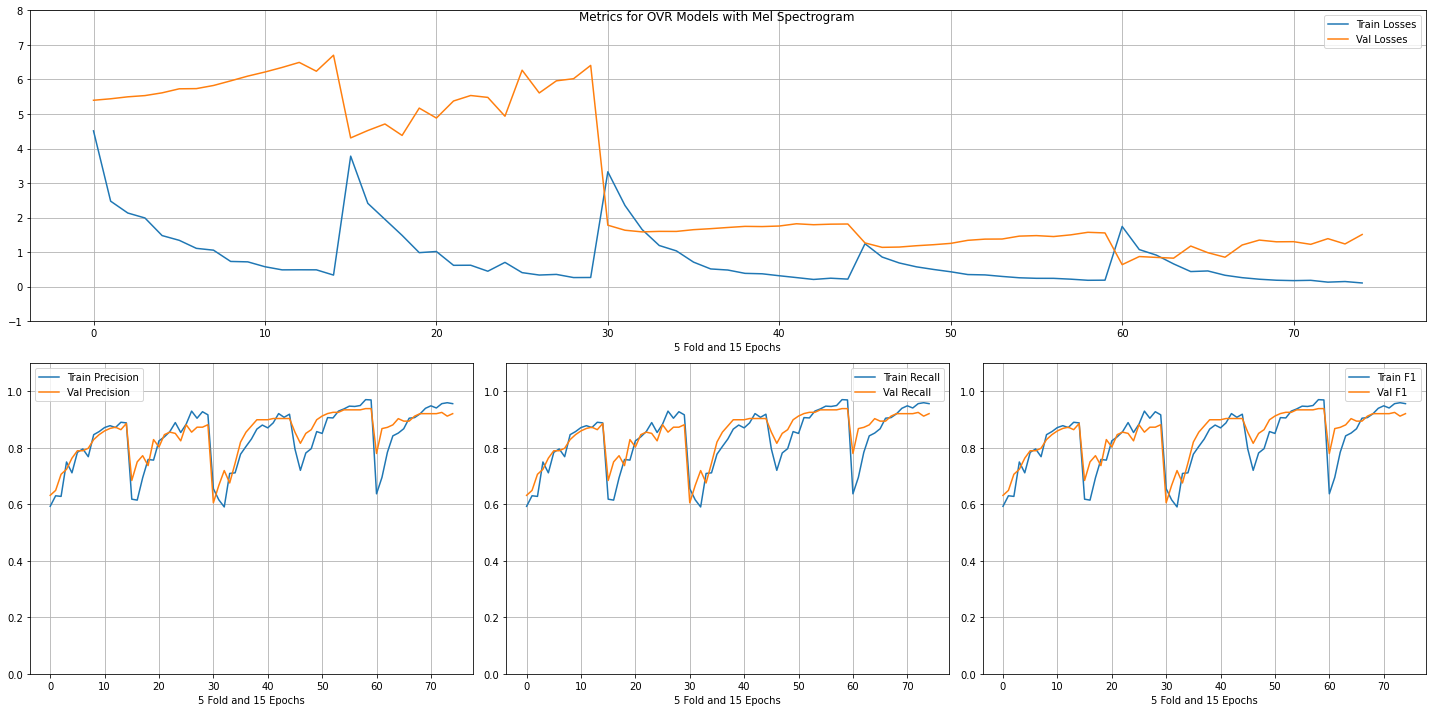

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.969265       0.938596  ...      0.188011           1.555980
13  0.970362       0.938596  ...      0.184899           1.574210
12  0.949506       0.934211  ...      0.217003           1.500162
9   0.937431       0.934211  ...      0.257607           1.463454
10  0.947311       0.934211  ...      0.241837           1.478394
..       ...            ...  ...           ...                ...
3   0.709111       0.675439  ...      1.191696           1.601197
1   0.615807       0.666667  ...      2.350904           1.634353
1   0.630077       0.649123  ...      2.475427           5.440574
0   0.592755       0.631579  ...      4.511075           5.397842
0   0.655324       0.605263  ...      3.327226           1.780087

[75 rows x 8 columns]
Training for ['దేసాక్షి'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51306306 19.63793103]
Epoch 1/15 : Training Loss: 6.594 / Validation Lo

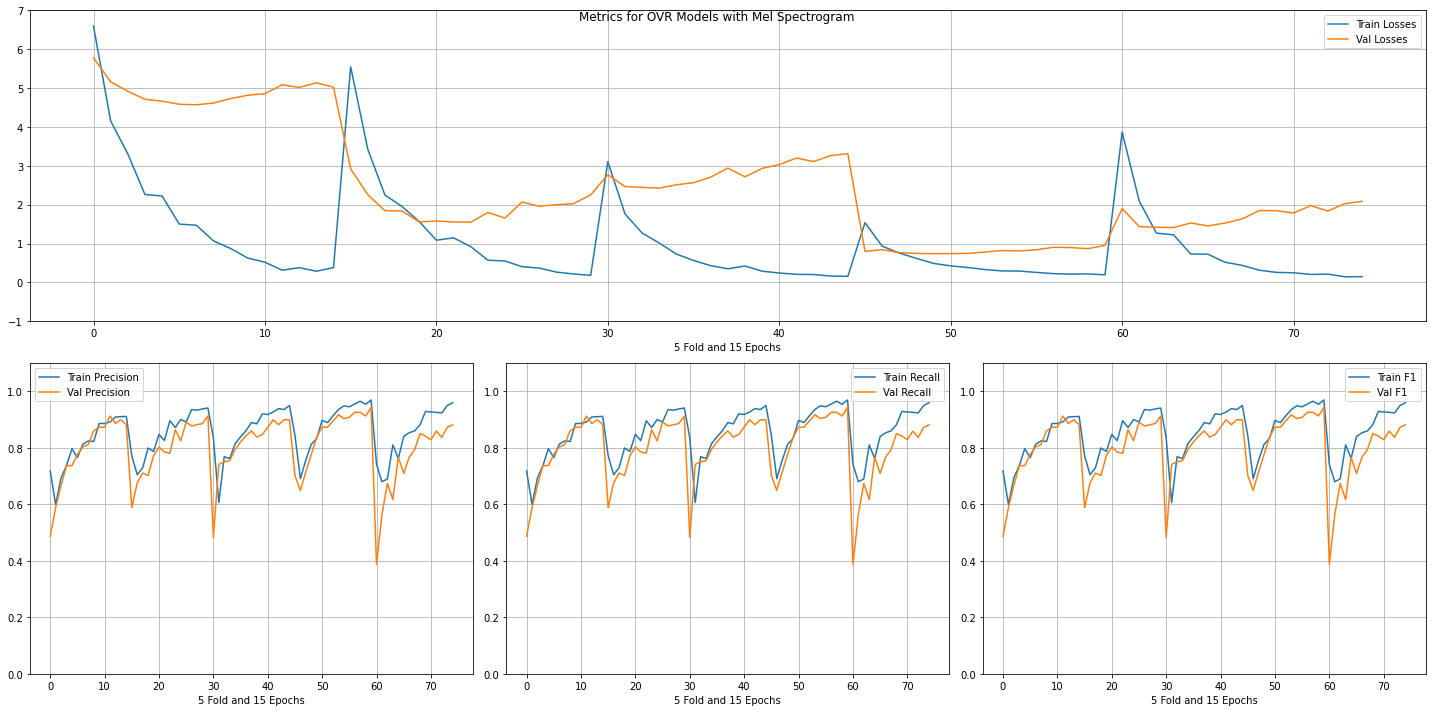

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.969265       0.942982  ...      0.193278           0.953638
12  0.964874       0.925439  ...      0.211157           0.895995
11  0.954995       0.925439  ...      0.223989           0.902992
8   0.935236       0.916667  ...      0.293228           0.819125
14  0.940724       0.912281  ...      0.180376           2.252134
..       ...            ...  ...           ...                ...
1   0.599341       0.587719  ...      4.155039           5.163326
1   0.679825       0.563877  ...      2.088369           1.435279
0   0.717892       0.486842  ...      6.594352           5.781204
0   0.835346       0.482456  ...      3.107542           2.770966
0   0.741228       0.387665  ...      3.865726           1.899970

[75 rows x 8 columns]
Training for ['దేసాళం'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51819836 14.2375    ]
Epoch 1/15 : Training Loss: 5.070 / Validation Loss

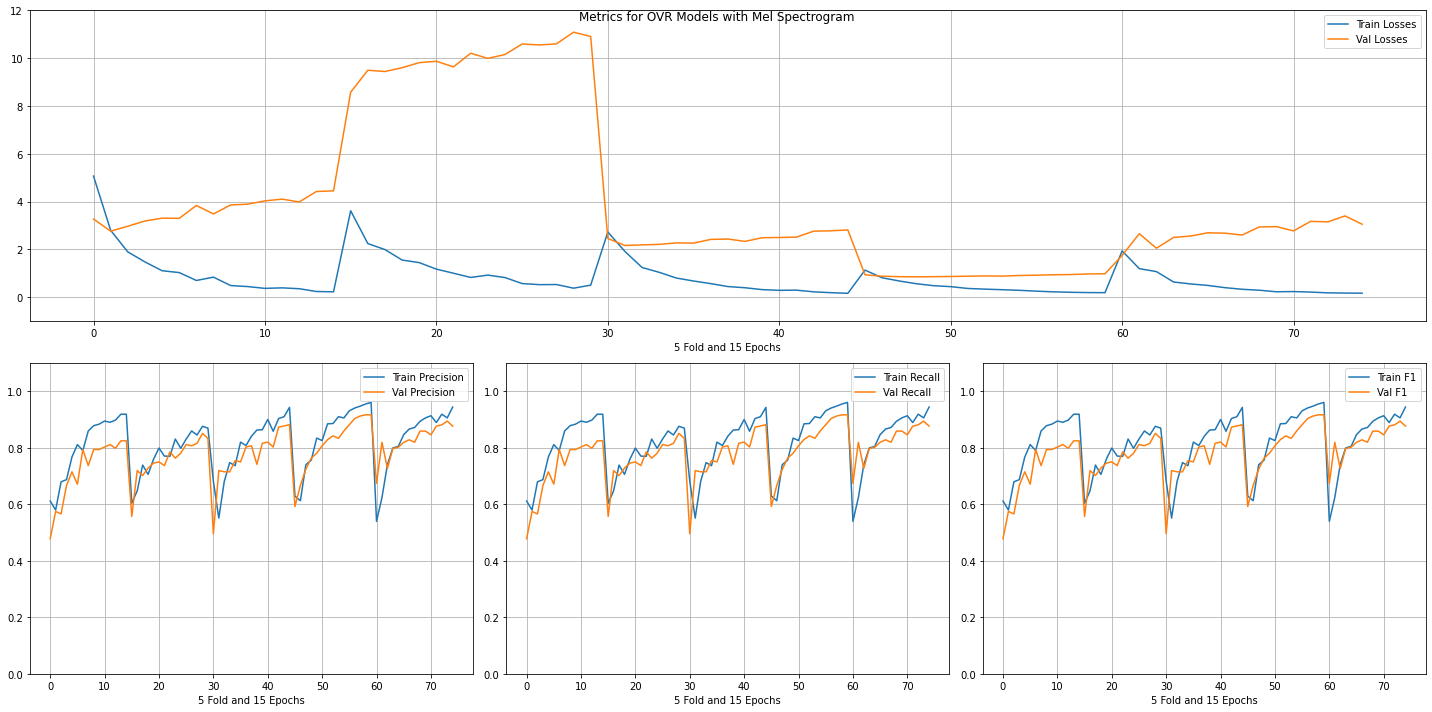

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.954995       0.916667  ...      0.197417           0.974766
14  0.960483       0.916667  ...      0.193206           0.984533
12  0.947311       0.912281  ...      0.209089           0.951234
11  0.940724       0.903509  ...      0.228140           0.943167
13  0.905702       0.894273  ...      0.176876           3.403536
..       ...            ...  ...           ...                ...
1   0.579583       0.574561  ...      2.801096           2.766816
2   0.679473       0.565789  ...      1.898405           2.972801
0   0.603732       0.557018  ...      3.618920           8.578239
0   0.681668       0.495614  ...      2.730894           2.460222
0   0.611416       0.478070  ...      5.070053           3.275338

[75 rows x 8 columns]
Training for ['ధన్నాసి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 5.641 / Validation Los

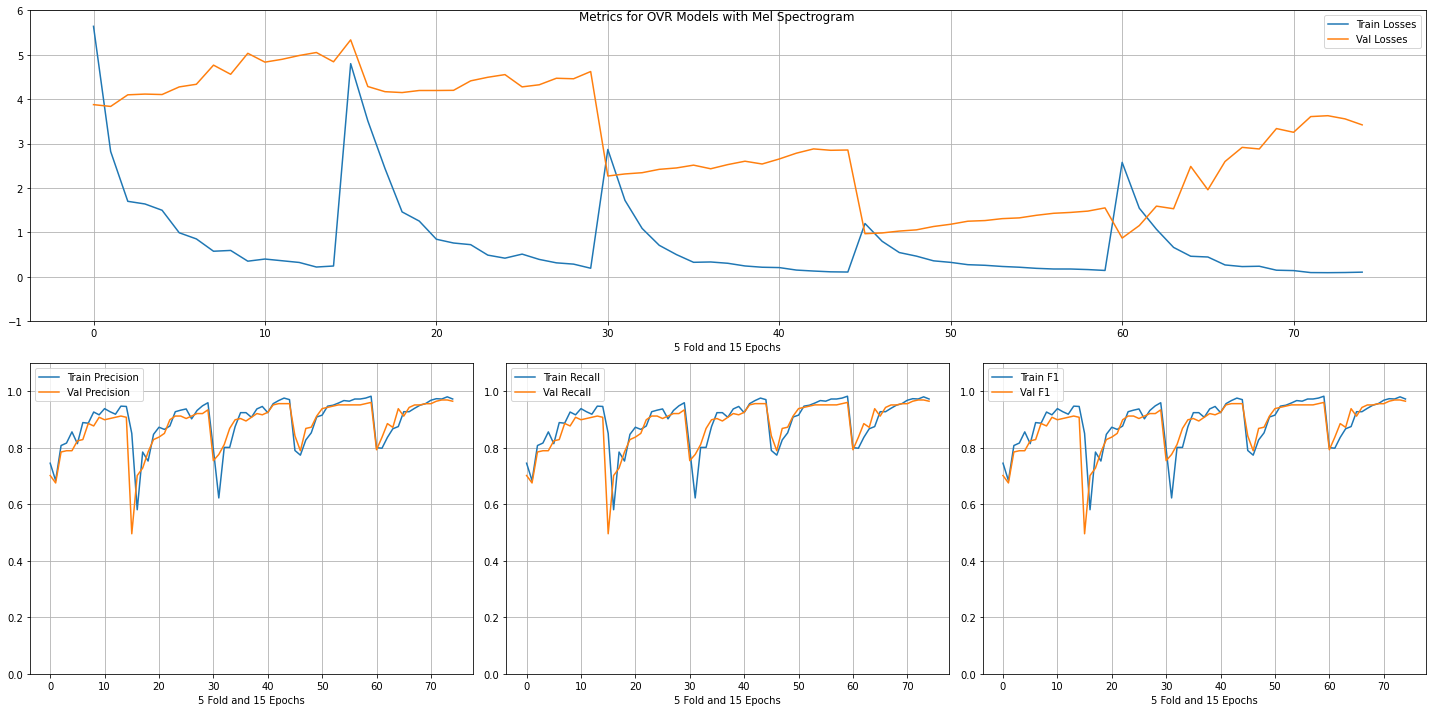

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.980263       0.969163  ...      0.096498           3.556816
12  0.972588       0.969163  ...      0.092917           3.628300
14  0.972588       0.964758  ...      0.104646           3.421776
11  0.973684       0.964758  ...      0.095044           3.608458
14  0.982437       0.960526  ...      0.143021           1.551978
..       ...            ...  ...           ...                ...
2   0.784852       0.728070  ...      2.441466           4.169455
1   0.580681       0.701754  ...      3.513415           4.285668
0   0.745335       0.701754  ...      5.641178           3.877510
1   0.683864       0.675439  ...      2.823022           3.837217
0   0.850714       0.495614  ...      4.800846           5.336386

[75 rows x 8 columns]
Training for ['నాట'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 4.739 / Validation Loss : 

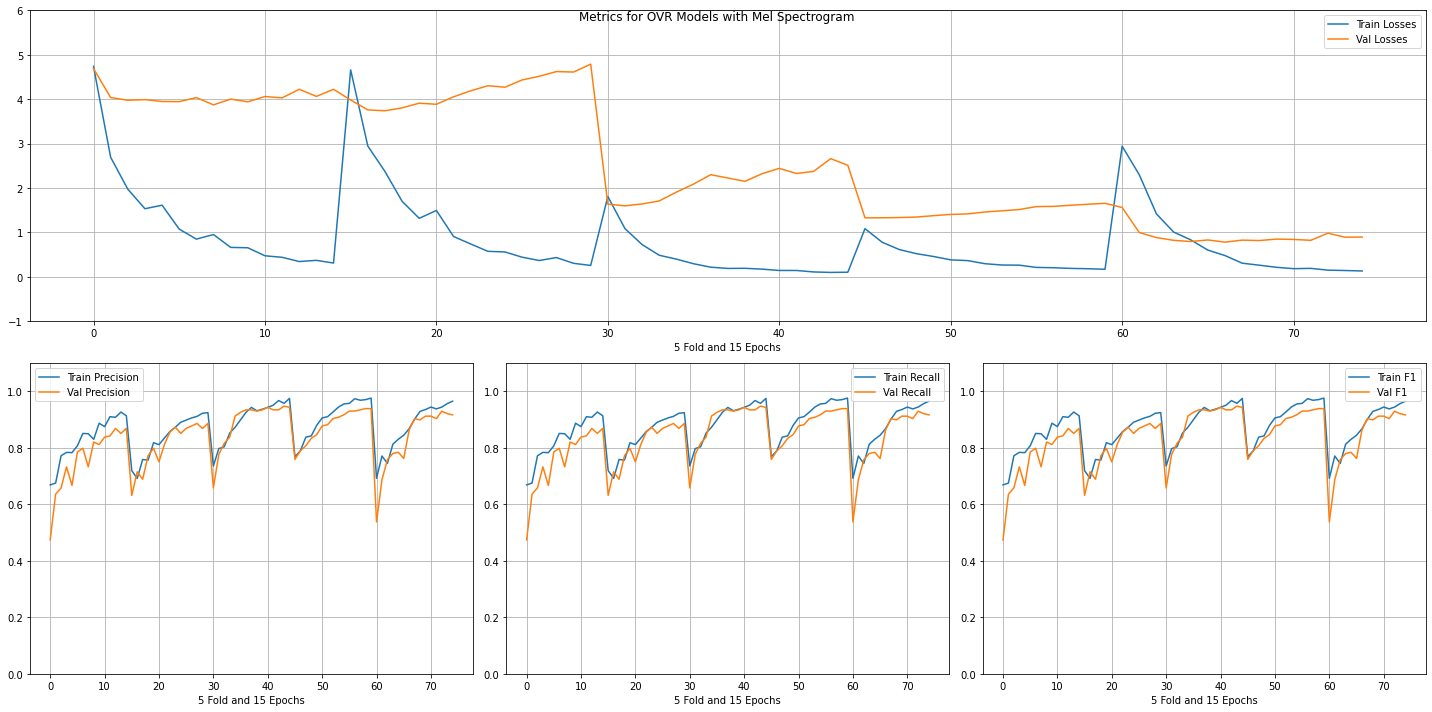

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.957190       0.947368  ...      0.098907           2.660966
14  0.974753       0.942982  ...      0.103514           2.510547
10  0.942920       0.942982  ...      0.142842           2.442547
14  0.975851       0.938596  ...      0.169467           1.655129
13  0.970362       0.938596  ...      0.181994           1.634335
..       ...            ...  ...           ...                ...
2   0.771679       0.657895  ...      1.973241           3.976684
1   0.675082       0.635965  ...      2.691853           4.037142
0   0.718990       0.631579  ...      4.659942           3.981665
0   0.691886       0.537445  ...      2.941912           1.561706
0   0.668496       0.473684  ...      4.738618           4.690373

[75 rows x 8 columns]
Training for ['నాదరామక్రియ'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 3.805 / Validation

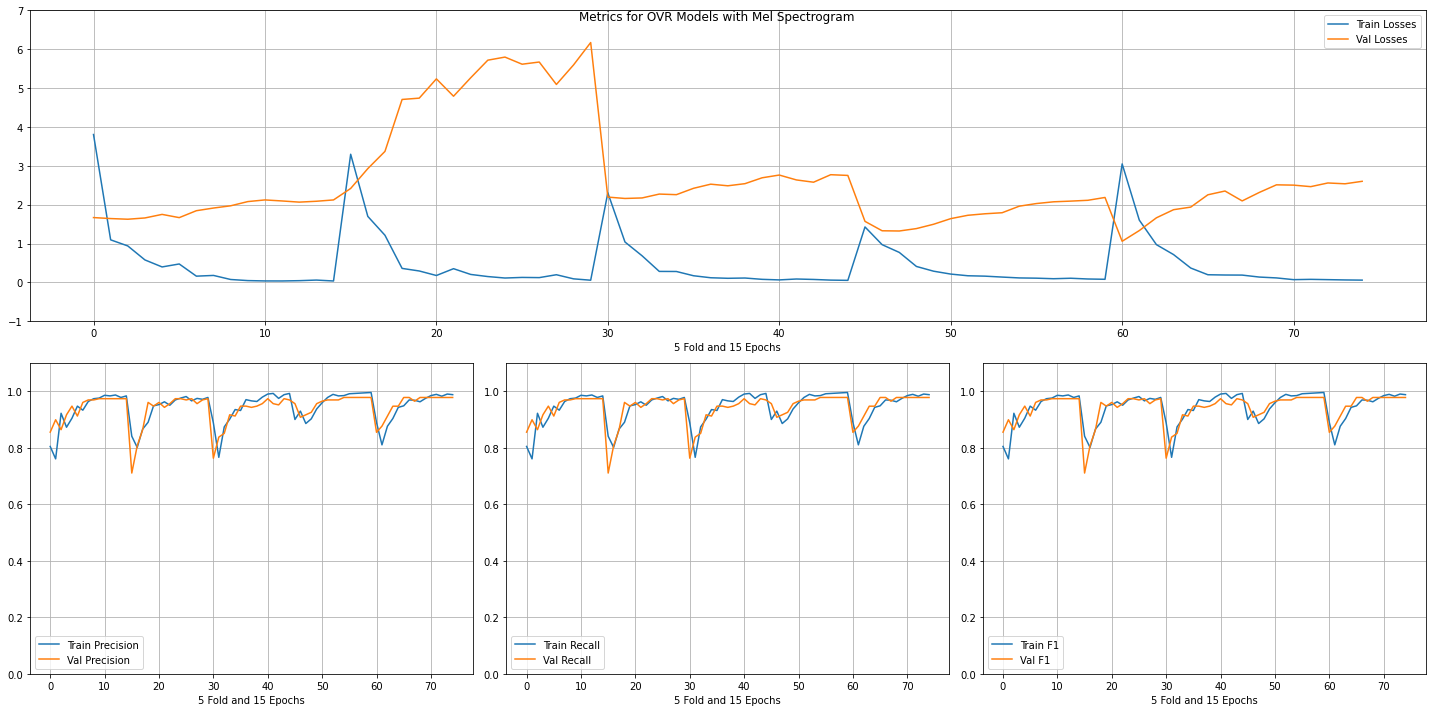

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.984632       0.978070  ...      0.113753           1.960762
14  0.995609       0.978070  ...      0.078829           2.185005
13  0.994512       0.978070  ...      0.086416           2.112253
12  0.993414       0.978070  ...      0.105649           2.090993
10  0.991218       0.978070  ...      0.107415           2.028454
..       ...            ...  ...           ...                ...
2   0.873765       0.850877  ...      0.682939           2.172614
1   0.766191       0.837719  ...      1.038948           2.159296
1   0.801317       0.807018  ...      1.697419           2.927888
0   0.888035       0.763158  ...      2.304173           2.194488
0   0.840834       0.710526  ...      3.297233           2.416953

[75 rows x 8 columns]
Training for ['పాడి'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52247706 11.62244898]
Epoch 1/15 : Training Loss: 3.608 / Validation Loss :

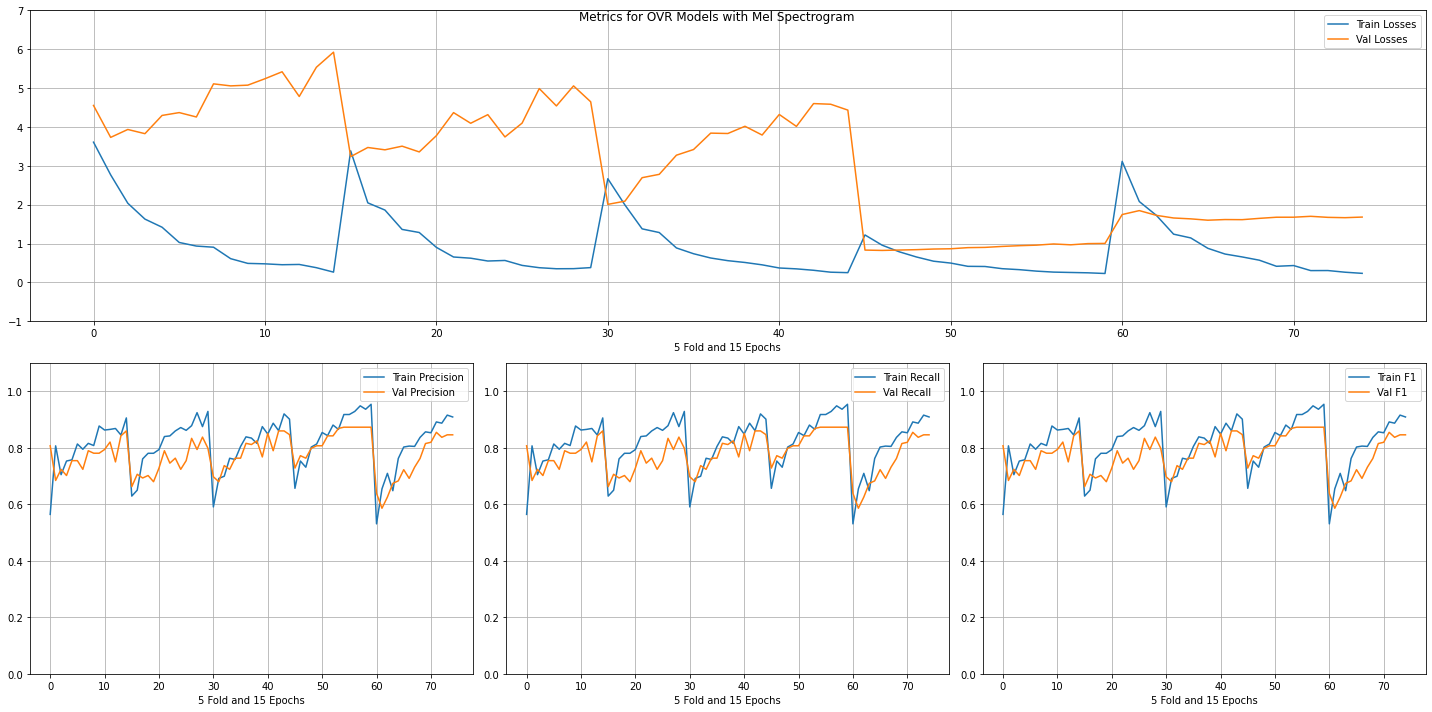

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.936334       0.872807  ...      0.245547           0.997056
14  0.953897       0.872807  ...      0.227933           1.002068
9   0.917673       0.872807  ...      0.326824           0.943680
10  0.917673       0.872807  ...      0.288920           0.957268
11  0.928650       0.872807  ...      0.263659           0.988031
..       ...            ...  ...           ...                ...
3   0.648026       0.674009  ...      1.240512           1.656503
0   0.628979       0.662281  ...      3.384955           3.236122
0   0.530702       0.638767  ...      3.114078           1.745377
2   0.709430       0.625551  ...      1.722839           1.724377
1   0.654605       0.585903  ...      2.079985           1.846802

[75 rows x 8 columns]
Training for ['బౌళి'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53274088 8.13571429]
Epoch 1/15 : Training Loss: 4.436 / Validation Loss : 6

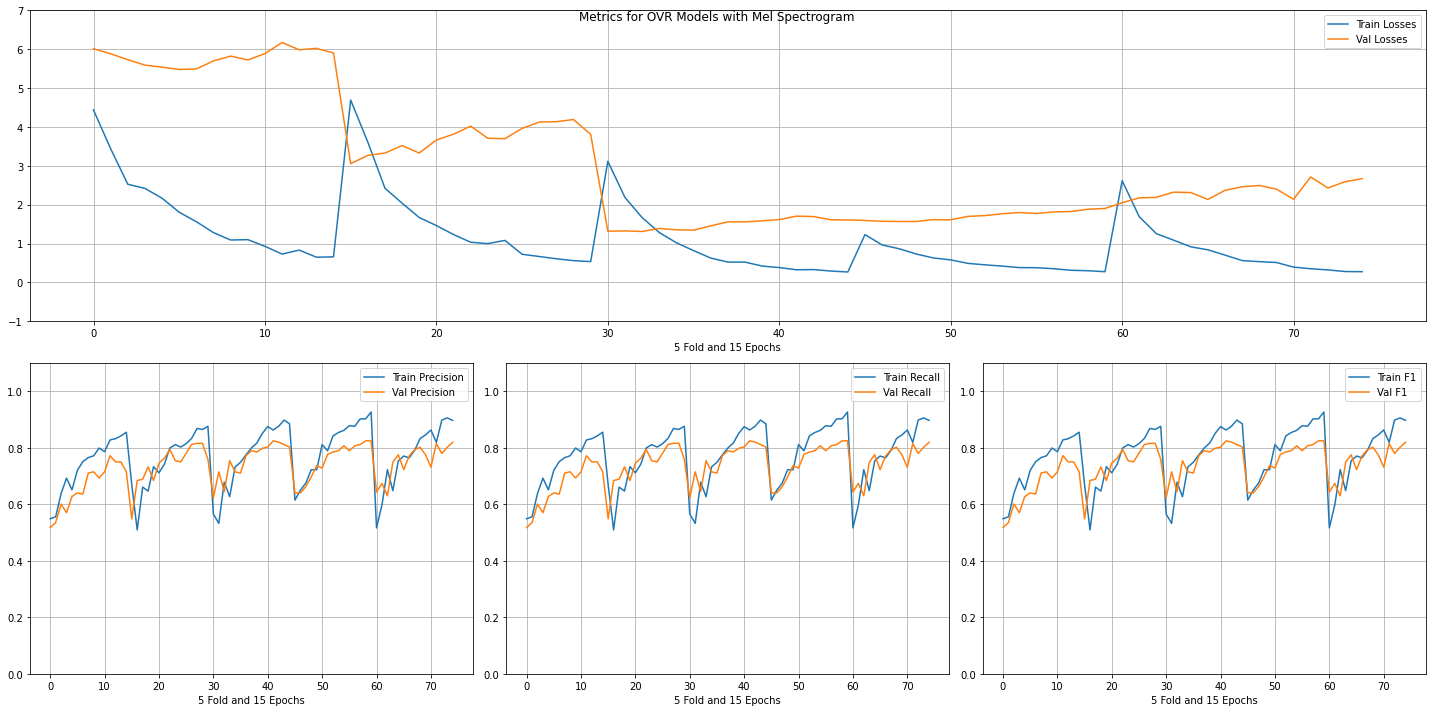

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.862788       0.824561  ...      0.324026           1.703435
14  0.926454       0.824561  ...      0.273714           1.902036
13  0.902305       0.824561  ...      0.299415           1.881905
12  0.875960       0.820175  ...      0.328337           1.694491
14  0.896930       0.819383  ...      0.273749           2.668666
..       ...            ...  ...           ...                ...
2   0.637761       0.600877  ...      2.525028           5.731192
3   0.692645       0.570175  ...      2.418602           5.591212
0   0.668496       0.548246  ...      4.692659           3.055023
1   0.555434       0.535088  ...      3.438791           5.883171
0   0.548847       0.517544  ...      4.436393           6.015014

[75 rows x 8 columns]
Training for ['బౌళిరామక్రియ'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50577265 43.80769231]
Epoch 1/15 : Training Loss: 3.247 / Validatio

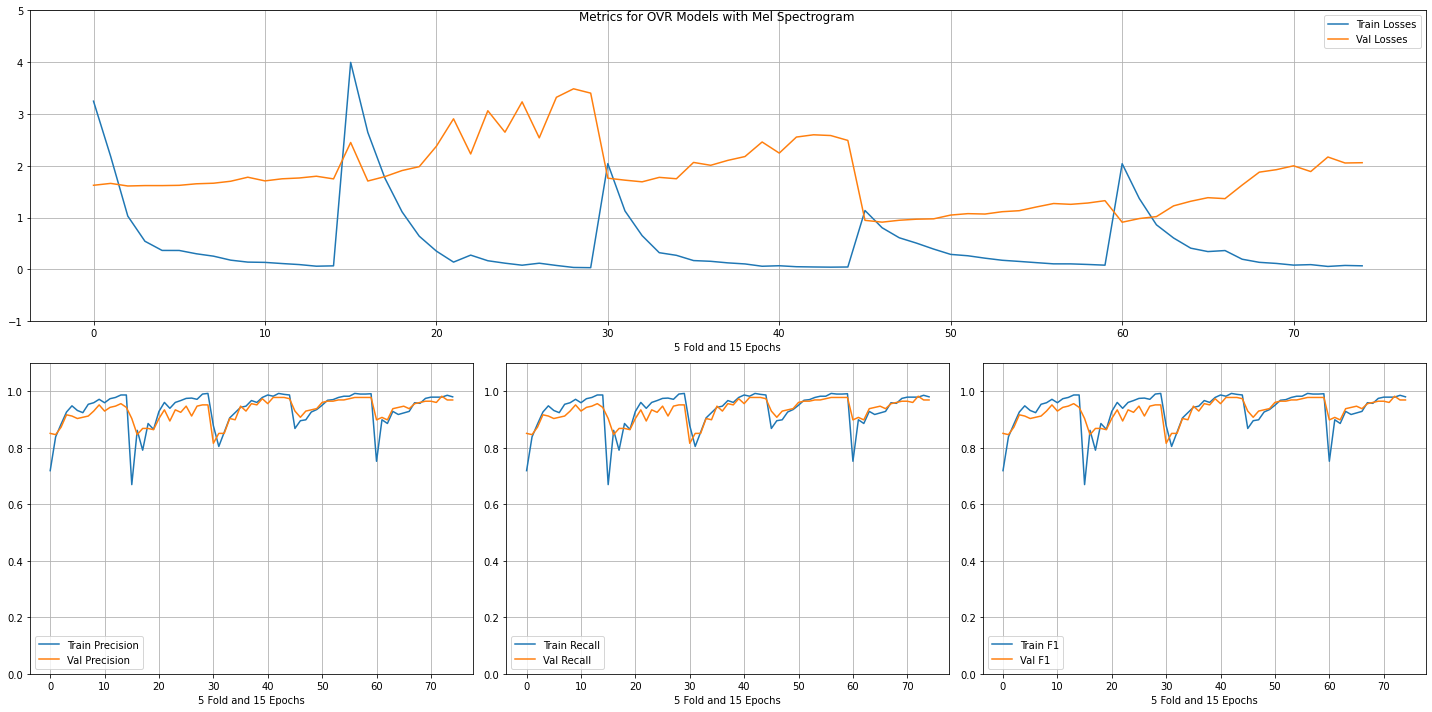

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.979167       0.982379  ...      0.057258           2.170045
11  0.992316       0.978070  ...      0.107109           1.271750
11  0.982437       0.978070  ...      0.051780           2.554852
12  0.992316       0.978070  ...      0.046751           2.598558
13  0.989023       0.978070  ...      0.043419           2.584315
..       ...            ...  ...           ...                ...
2   0.855104       0.850877  ...      0.651883           1.690541
0   0.718990       0.850877  ...      3.247419           1.624023
1   0.861690       0.846491  ...      2.645251           1.706001
1   0.838639       0.846491  ...      2.181962           1.660304
0   0.878156       0.815789  ...      2.041920           1.760811

[75 rows x 8 columns]
Training for ['భూపాలం'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51445348 17.796875  ]
Epoch 1/15 : Training Loss: 3.450 / Validation Loss

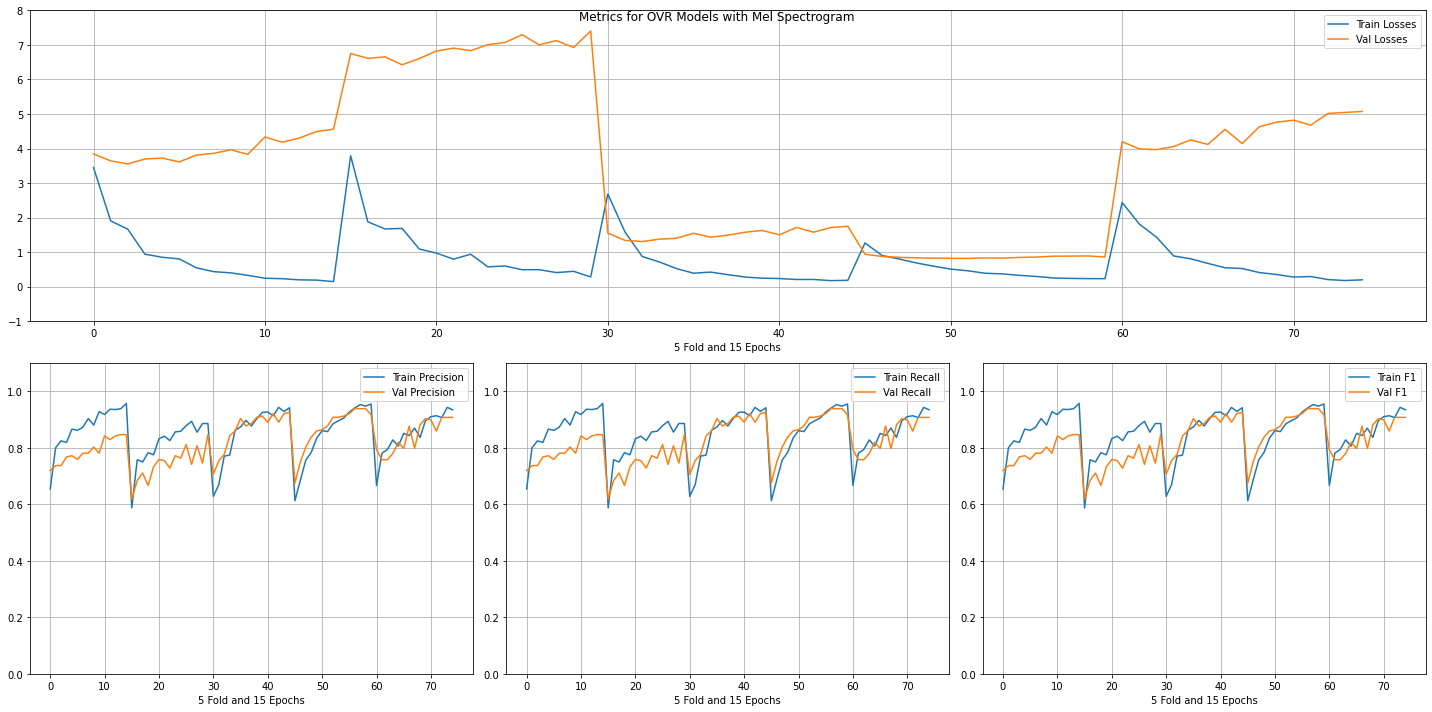

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.947311       0.938596  ...      0.232970           0.889658
12  0.952799       0.938596  ...      0.239086           0.885511
11  0.940724       0.938596  ...      0.250771           0.882386
14  0.941822       0.925439  ...      0.184125           1.749446
10  0.926454       0.921053  ...      0.295028           0.856619
..       ...            ...  ...           ...                ...
0   0.627881       0.706140  ...      2.682837           1.547992
1   0.757409       0.684211  ...      1.878664           6.610358
0   0.612514       0.675439  ...      1.264397           0.937352
3   0.782656       0.666667  ...      1.686848           6.425079
0   0.587267       0.618421  ...      3.790100           6.751462

[75 rows x 8 columns]
Training for ['భైరవి'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51214029 21.09259259]
Epoch 1/15 : Training Loss: 6.013 / Validation Loss 

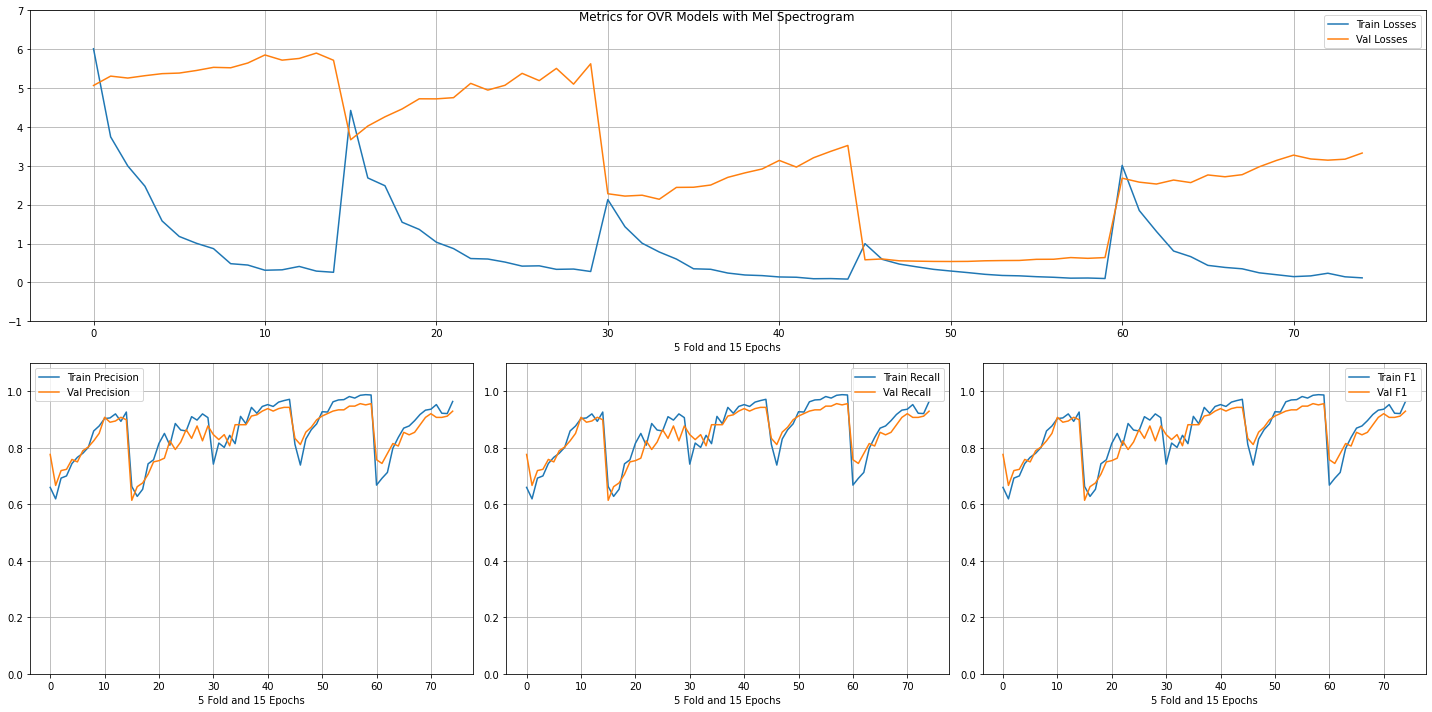

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.986828       0.956140  ...      0.098749           0.637827
12  0.985730       0.956140  ...      0.107819           0.637642
13  0.987925       0.951754  ...      0.111706           0.618279
11  0.975851       0.947368  ...      0.130577           0.594656
10  0.981339       0.947368  ...      0.145574           0.592593
..       ...            ...  ...           ...                ...
3   0.743139       0.706140  ...      1.547867           4.463164
2   0.653128       0.675439  ...      2.486887           4.260551
1   0.619100       0.666667  ...      3.743888           5.308501
1   0.627881       0.662281  ...      2.687135           4.023507
0   0.663008       0.614035  ...      4.425054           3.670003

[75 rows x 8 columns]
Training for ['మలహరి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 4.363 / Validation Loss 

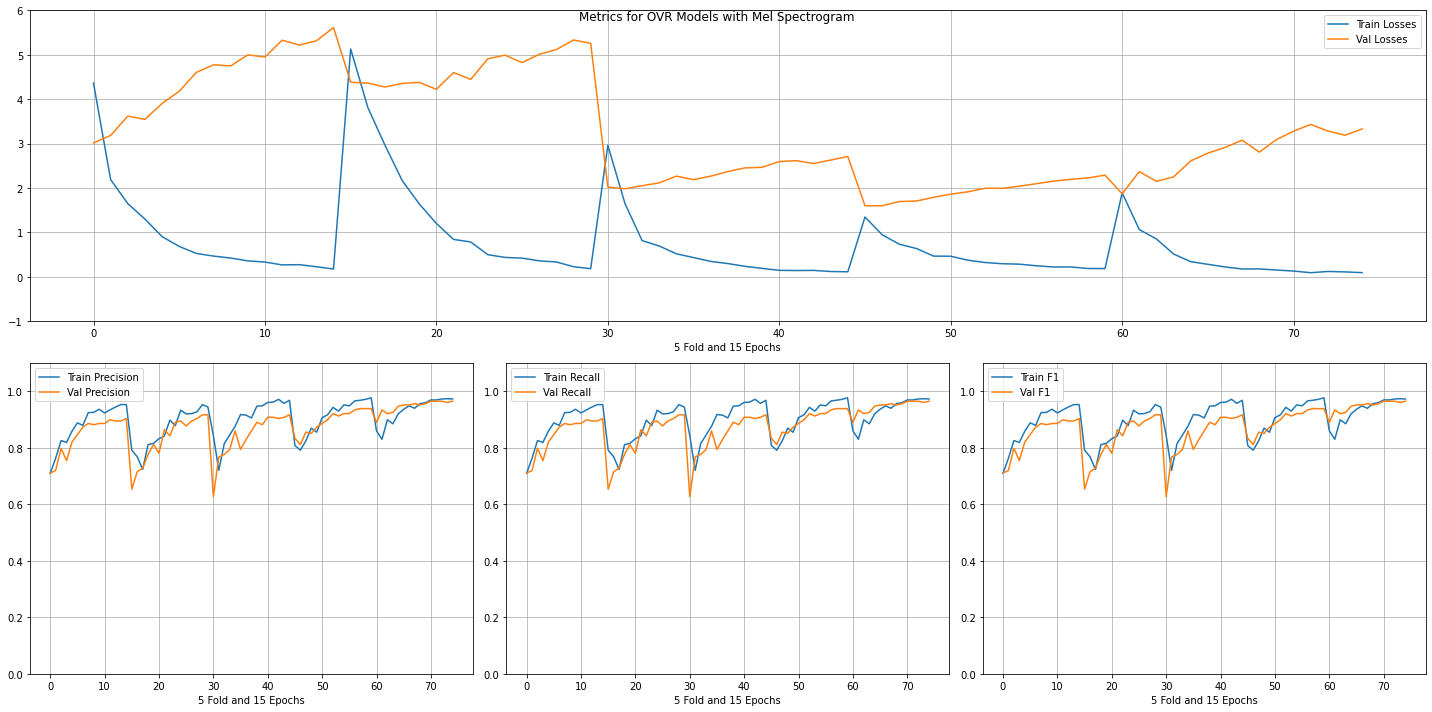

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.972588       0.964758  ...      0.093601           3.330305
12  0.972588       0.964758  ...      0.120107           3.284484
11  0.969298       0.964758  ...      0.092258           3.430559
10  0.969298       0.964758  ...      0.129373           3.279906
13  0.973684       0.960352  ...      0.110573           3.189289
..       ...            ...  ...           ...                ...
1   0.762898       0.719298  ...      2.189251           3.185171
1   0.768386       0.714912  ...      3.814279           4.362717
0   0.709111       0.710526  ...      4.362649           3.014962
0   0.791438       0.653509  ...      5.132090           4.382436
0   0.843030       0.627193  ...      2.961931           2.020991

[75 rows x 8 columns]
Training for ['మాళవి'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 5.019 / Validation Loss 

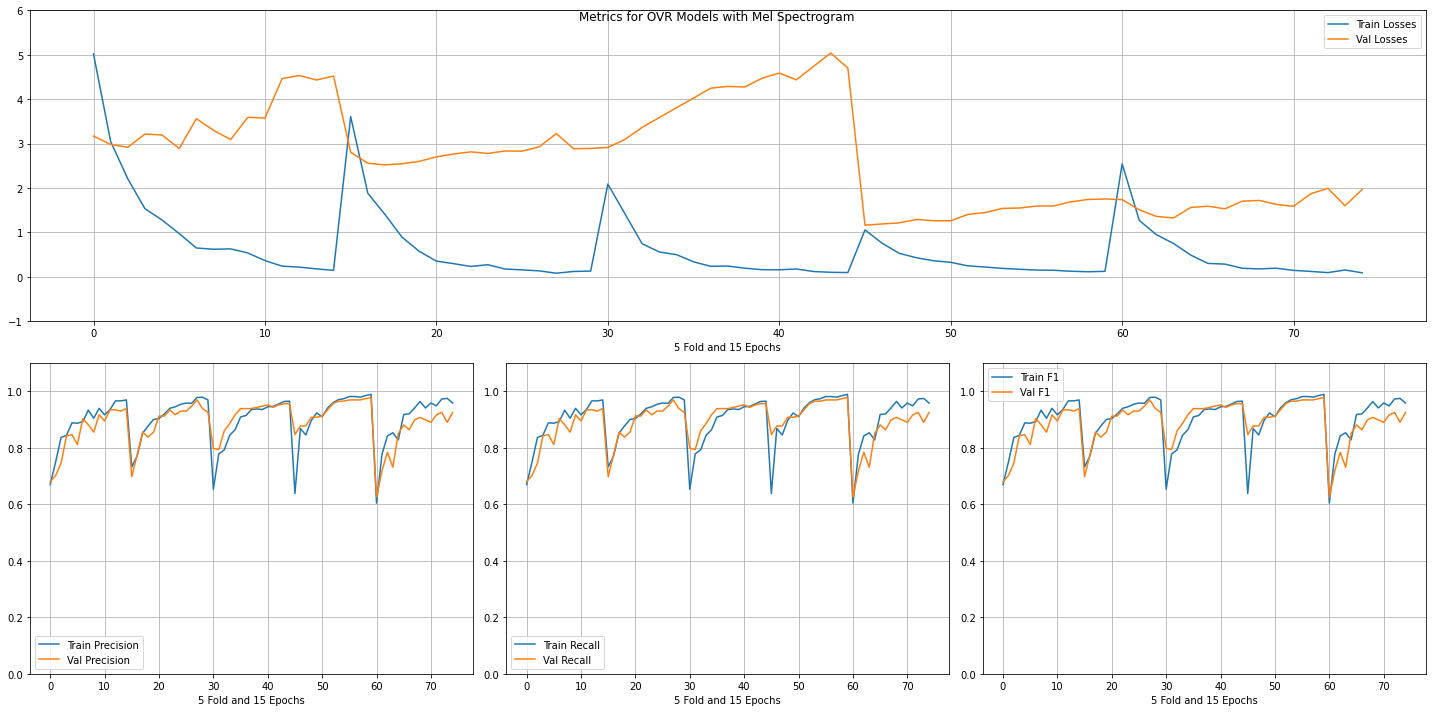

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.989023       0.978070  ...      0.122944           1.754081
13  0.984632       0.973684  ...      0.114056           1.741767
12  0.979144       0.969298  ...      0.125135           1.688302
11  0.981339       0.969298  ...      0.146881           1.595706
10  0.981339       0.969298  ...      0.151621           1.593022
..       ...            ...  ...           ...                ...
1   0.776316       0.718062  ...      1.269716           1.507942
1   0.749726       0.701754  ...      3.046469           2.981862
0   0.732162       0.697368  ...      3.608041           2.806246
0   0.669594       0.679825  ...      5.018999           3.168338
0   0.604167       0.625551  ...      2.543275           1.737642

[75 rows x 8 columns]
Training for ['మాళవిగౌళ'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 4.334 / Validation Lo

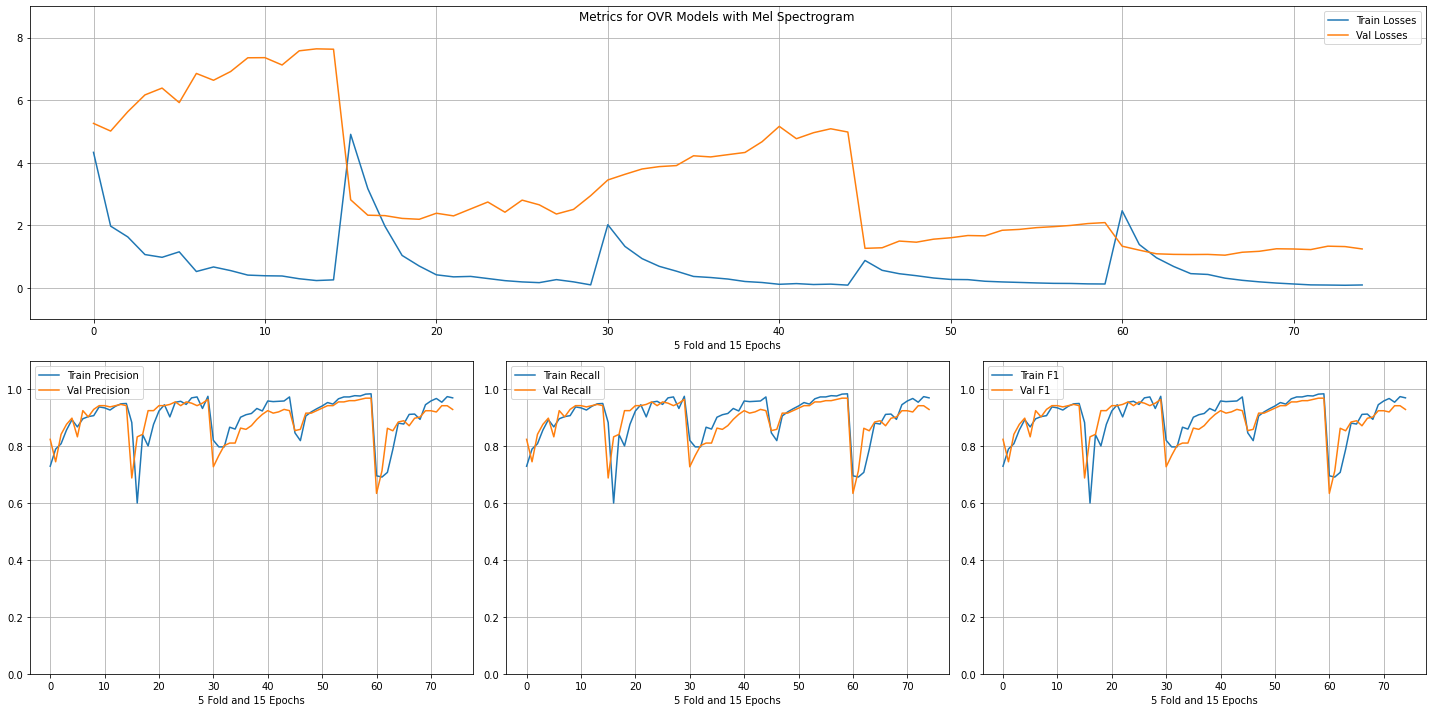

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.983535       0.969298  ...      0.129078           2.057535
14  0.984632       0.969298  ...      0.125275           2.088539
14  0.975851       0.964912  ...      0.097411           2.949431
12  0.976948       0.964912  ...      0.142517           1.997808
10  0.973655       0.960526  ...      0.159213           1.927079
..       ...            ...  ...           ...                ...
1   0.790340       0.745614  ...      1.975193           5.014844
0   0.821076       0.728070  ...      2.020391           3.450853
1   0.691886       0.713656  ...      1.387859           1.207640
0   0.883644       0.688596  ...      4.910003           2.817745
0   0.696272       0.634361  ...      2.466816           1.334182

[75 rows x 8 columns]
Training for ['ముఖారి'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.525369   10.35454545]
Epoch 1/15 : Training Loss: 3.472 / Validation Loss

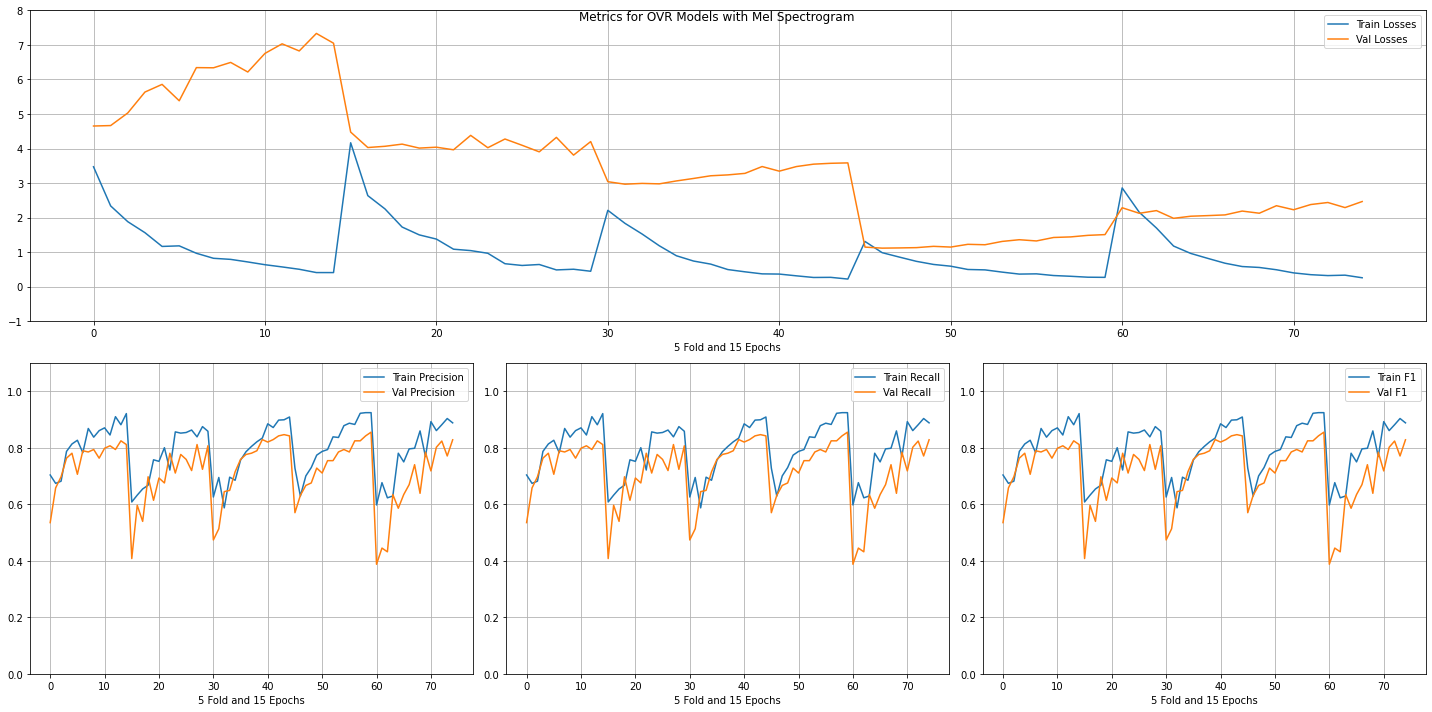

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.924259       0.855263  ...      0.269677           1.507448
13  0.899012       0.846491  ...      0.269966           3.572412
12  0.897914       0.842105  ...      0.266189           3.547479
13  0.924259       0.842105  ...      0.273989           1.485921
14  0.908891       0.842105  ...      0.220366           3.584196
..       ...            ...  ...           ...                ...
0   0.625686       0.473684  ...      2.210677           3.039564
1   0.676535       0.444934  ...      2.152984           2.124701
2   0.622807       0.431718  ...      1.698897           2.202629
0   0.608123       0.407895  ...      4.166994           4.476467
0   0.597588       0.387665  ...      2.859545           2.285518

[75 rows x 8 columns]
Training for ['రామక్రియ'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.52829314 9.33606557]
Epoch 1/15 : Training Loss: 4.298 / Validation Loss

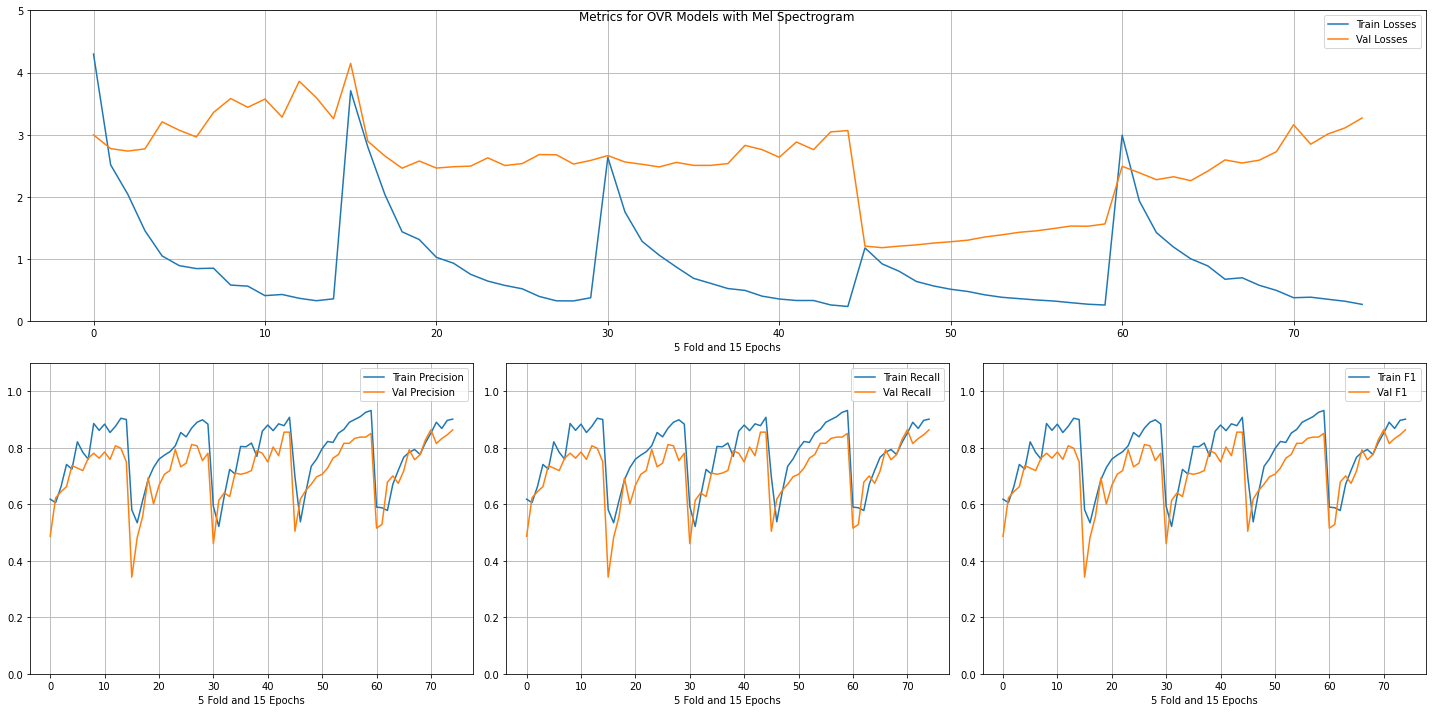

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.901316       0.863436  ...      0.270492           3.269737
10  0.851974       0.863436  ...      0.377881           3.160270
13  0.878156       0.855263  ...      0.261572           3.045536
14  0.907794       0.855263  ...      0.236762           3.066613
14  0.931943       0.850877  ...      0.260084           1.564278
..       ...            ...  ...           ...                ...
0   0.697036       0.504386  ...      1.178673           1.207991
0   0.618002       0.486842  ...      4.297505           2.997133
1   0.534577       0.482456  ...      2.802862           2.895832
0   0.592755       0.460526  ...      2.635885           2.664464
0   0.580681       0.342105  ...      3.707476           4.147789

[75 rows x 8 columns]
Training for ['లలిత'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54707012 5.81122449]
Epoch 1/15 : Training Loss: 4.633 / Validation Loss : 3

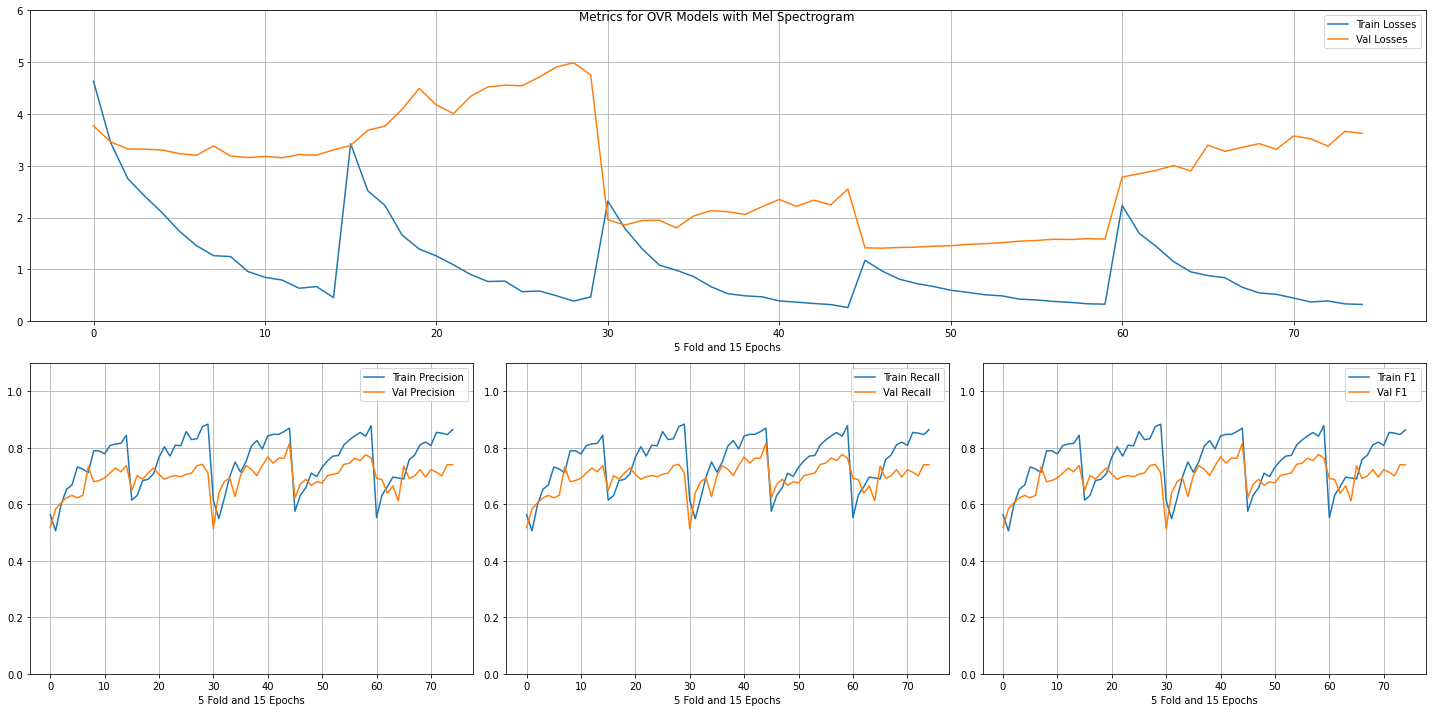

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.869374       0.815789  ...      0.263817           2.549827
13  0.840834       0.776316  ...      0.335477           1.594211
10  0.841932       0.767544  ...      0.391763           2.351256
13  0.857300       0.763158  ...      0.320903           2.245701
14  0.878156       0.763158  ...      0.328832           1.586810
..       ...            ...  ...           ...                ...
4   0.692982       0.612335  ...      0.952611           2.899279
2   0.598244       0.605263  ...      2.753636           3.323991
1   0.506037       0.583333  ...      3.446909           3.462312
0   0.563117       0.517544  ...      4.632533           3.770631
0   0.613611       0.513158  ...      2.319218           1.958077

[75 rows x 8 columns]
Training for ['వరాళి'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50984781 25.88636364]
Epoch 1/15 : Training Loss: 5.265 / Validation Loss 

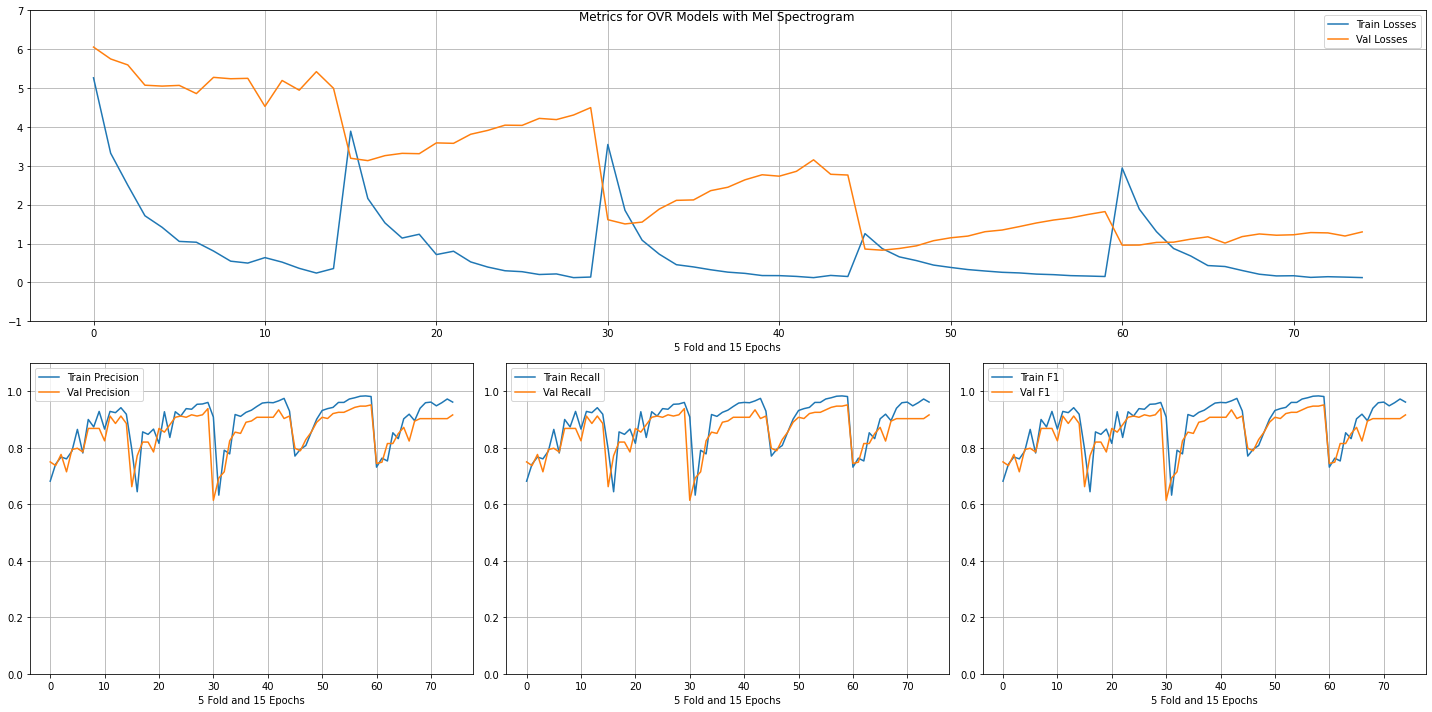

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.981339       0.951754  ...      0.150361           1.821373
13  0.983535       0.947368  ...      0.162439           1.746099
12  0.982437       0.947368  ...      0.172881           1.659380
11  0.976948       0.942982  ...      0.198041           1.604170
14  0.960483       0.938596  ...      0.136541           4.497567
..       ...            ...  ...           ...                ...
2   0.791438       0.714912  ...      1.085107           1.551177
3   0.760703       0.714912  ...      1.713546           5.074378
1   0.632272       0.692982  ...      1.854761           1.503490
0   0.794731       0.662281  ...      3.890220           3.193880
0   0.908891       0.614035  ...      3.548755           1.612707

[75 rows x 8 columns]
Training for ['శంకరాభరణం'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53174603 8.375     ]
Epoch 1/15 : Training Loss: 5.481 / Validation Los

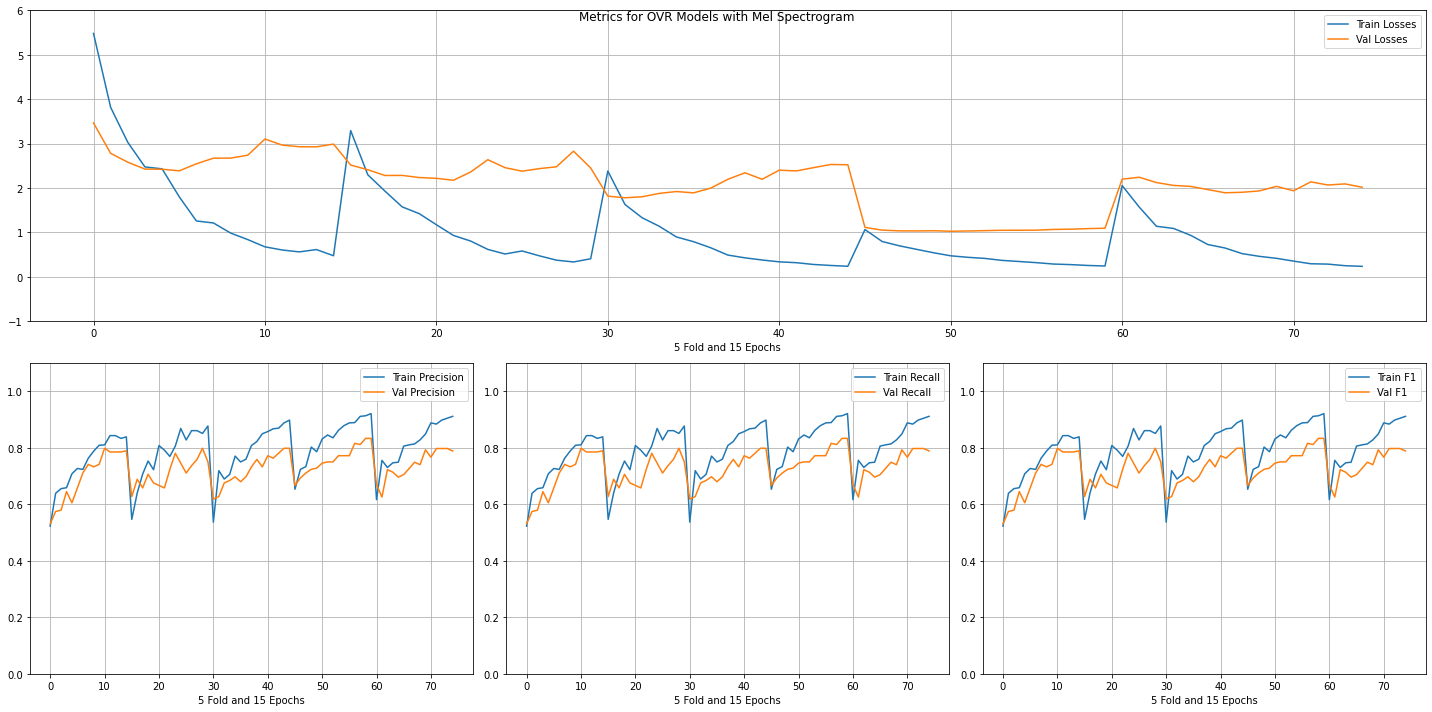

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.913282       0.833333  ...      0.255384           1.084894
14  0.920966       0.833333  ...      0.243232           1.094575
11  0.889133       0.815789  ...      0.287180           1.066538
12  0.911087       0.811404  ...      0.274477           1.072612
13  0.888035       0.798246  ...      0.255380           2.529834
..       ...            ...  ...           ...                ...
0   0.536773       0.618421  ...      2.382383           1.816837
4   0.708013       0.605263  ...      2.431936           2.422733
2   0.655324       0.578947  ...      3.028086           2.581235
1   0.638858       0.574561  ...      3.815922           2.780418
0   0.522503       0.530702  ...      5.480763           3.464973

[75 rows x 8 columns]
Training for ['శుద్ధవసంతం'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51491863 17.25757576]
Epoch 1/15 : Training Loss: 3.806 / Validation 

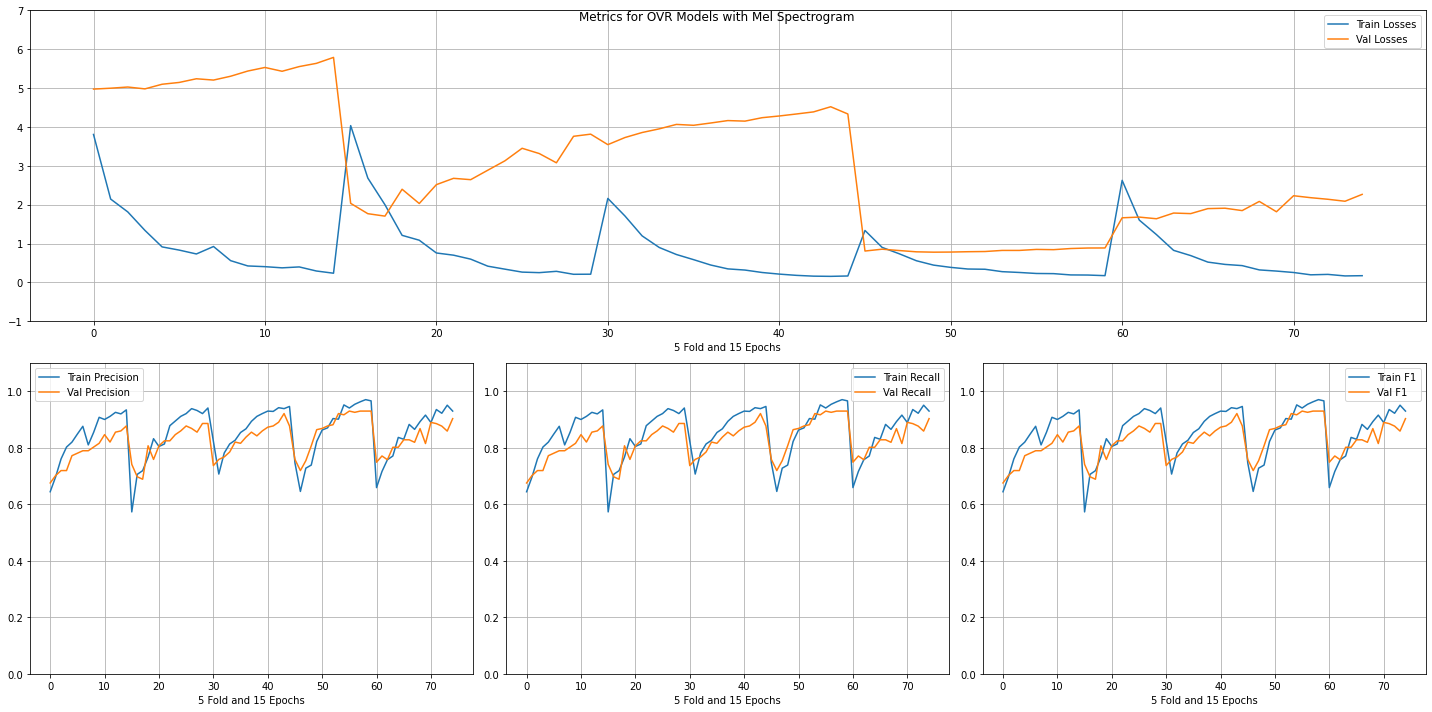

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.970362       0.929825  ...      0.188062           0.883593
10  0.940724       0.929825  ...      0.228416           0.847733
12  0.962678       0.929825  ...      0.191041           0.870758
14  0.965971       0.929825  ...      0.172294           0.885015
11  0.953897       0.925439  ...      0.224254           0.841323
..       ...            ...  ...           ...                ...
2   0.760703       0.719298  ...      1.812526           5.027619
1   0.697036       0.701754  ...      2.143914           4.997405
1   0.705818       0.697368  ...      2.684810           1.767506
2   0.718990       0.688596  ...      1.997402           1.704647
0   0.644347       0.675439  ...      3.806374           4.974365

[75 rows x 8 columns]
Training for ['శ్రీరాగం'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53026071 8.76153846]
Epoch 1/15 : Training Loss: 5.005 / Validation Loss

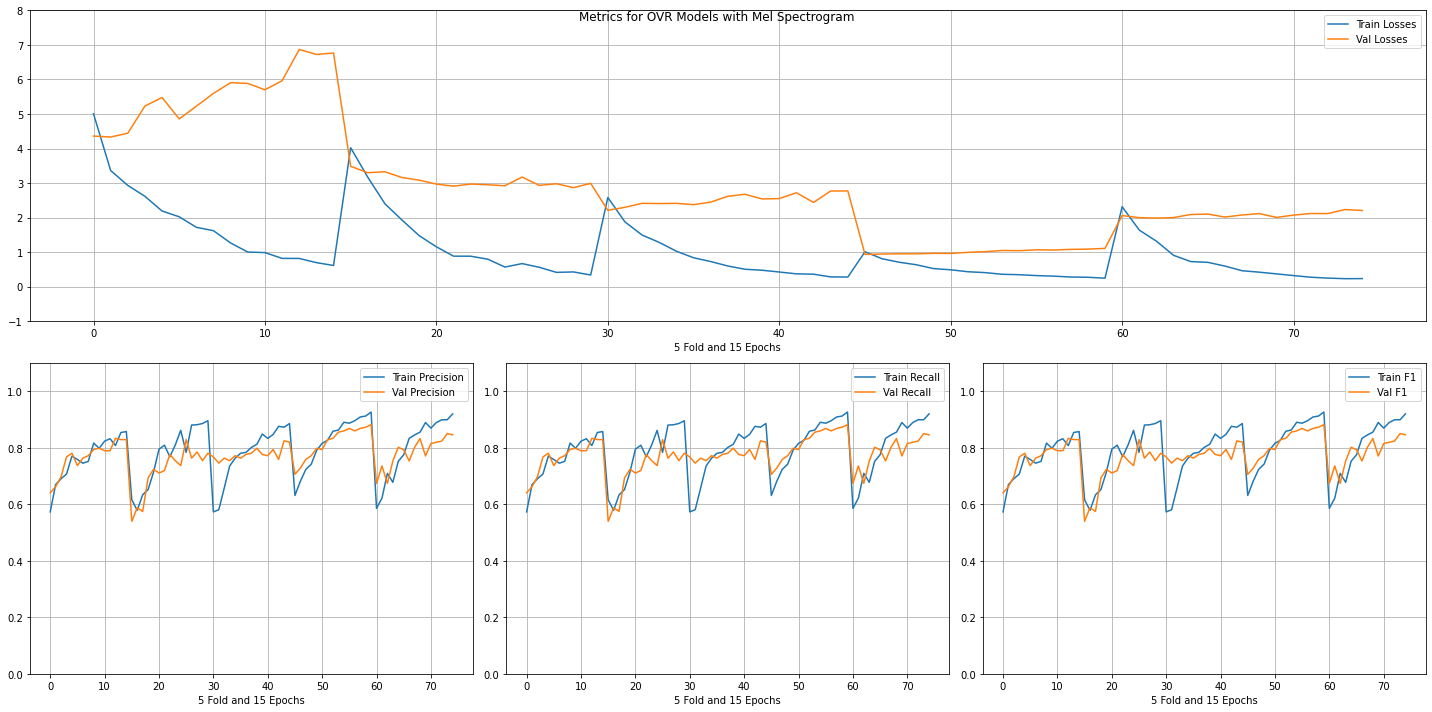

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.926454       0.881579  ...      0.246162           1.108307
13  0.912184       0.872807  ...      0.271891           1.087335
10  0.886937       0.868421  ...      0.320392           1.066947
12  0.908891       0.868421  ...      0.279461           1.079849
11  0.895719       0.859649  ...      0.305130           1.060670
..       ...            ...  ...           ...                ...
1   0.669594       0.662281  ...      3.363249           4.333620
0   0.572997       0.640351  ...      5.005216           4.360353
1   0.578485       0.587719  ...      3.168002           3.300386
2   0.633370       0.574561  ...      2.398578           3.326609
0   0.615807       0.539474  ...      4.022720           3.484353

[75 rows x 8 columns]
Training for ['సామంతం'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54238095 6.3988764 ]
Epoch 1/15 : Training Loss: 4.421 / Validation Loss :

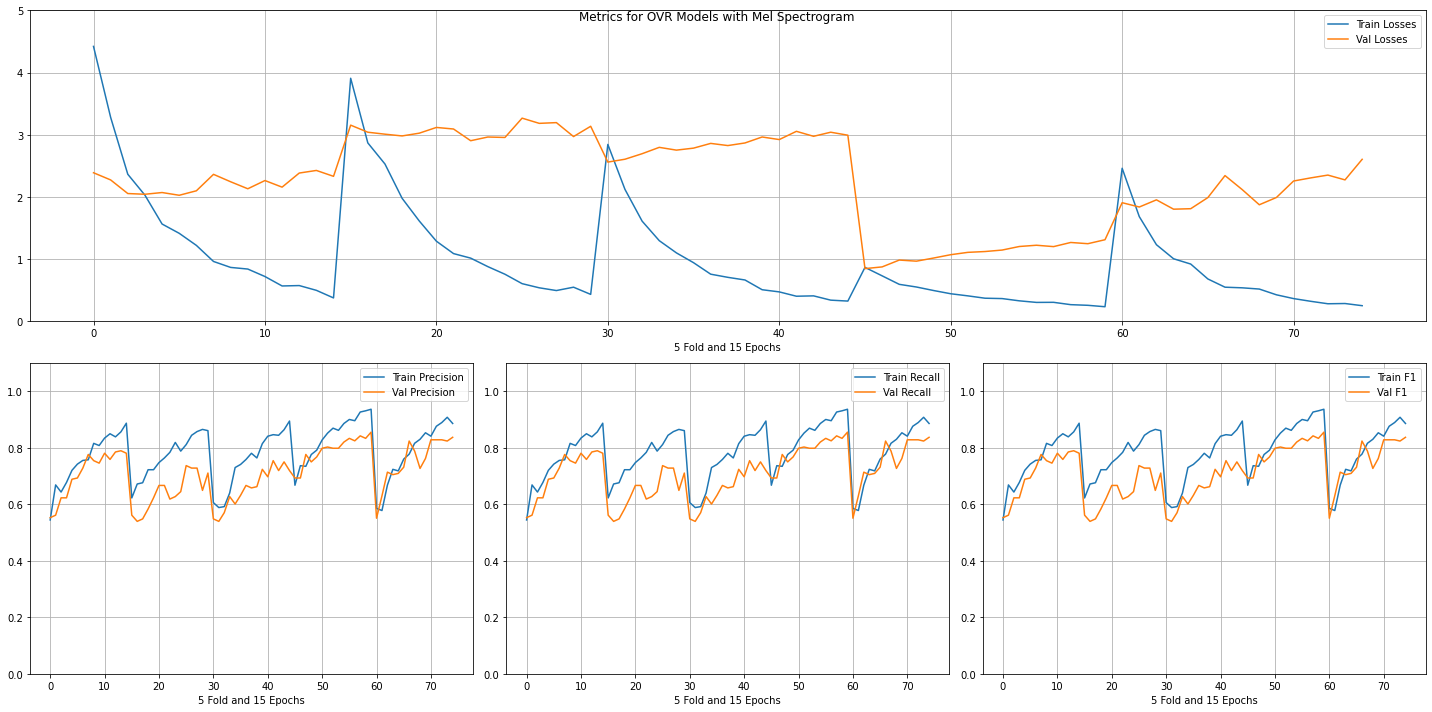

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.936334       0.855263  ...      0.232689           1.310637
12  0.926454       0.842105  ...      0.266129           1.266580
14  0.885965       0.837004  ...      0.249577           2.604312
10  0.900110       0.833333  ...      0.302345           1.221940
13  0.930845       0.833333  ...      0.255648           1.246867
..       ...            ...  ...           ...                ...
0   0.585526       0.550661  ...      2.460427           1.906284
2   0.676180       0.548246  ...      2.528831           3.008661
0   0.605928       0.548246  ...      2.843921           2.559834
1   0.671789       0.539474  ...      2.868537           3.040183
1   0.588364       0.539474  ...      2.120414           2.605719

[75 rows x 8 columns]
Training for ['సాళంగం'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 6.100 / Validation Loss

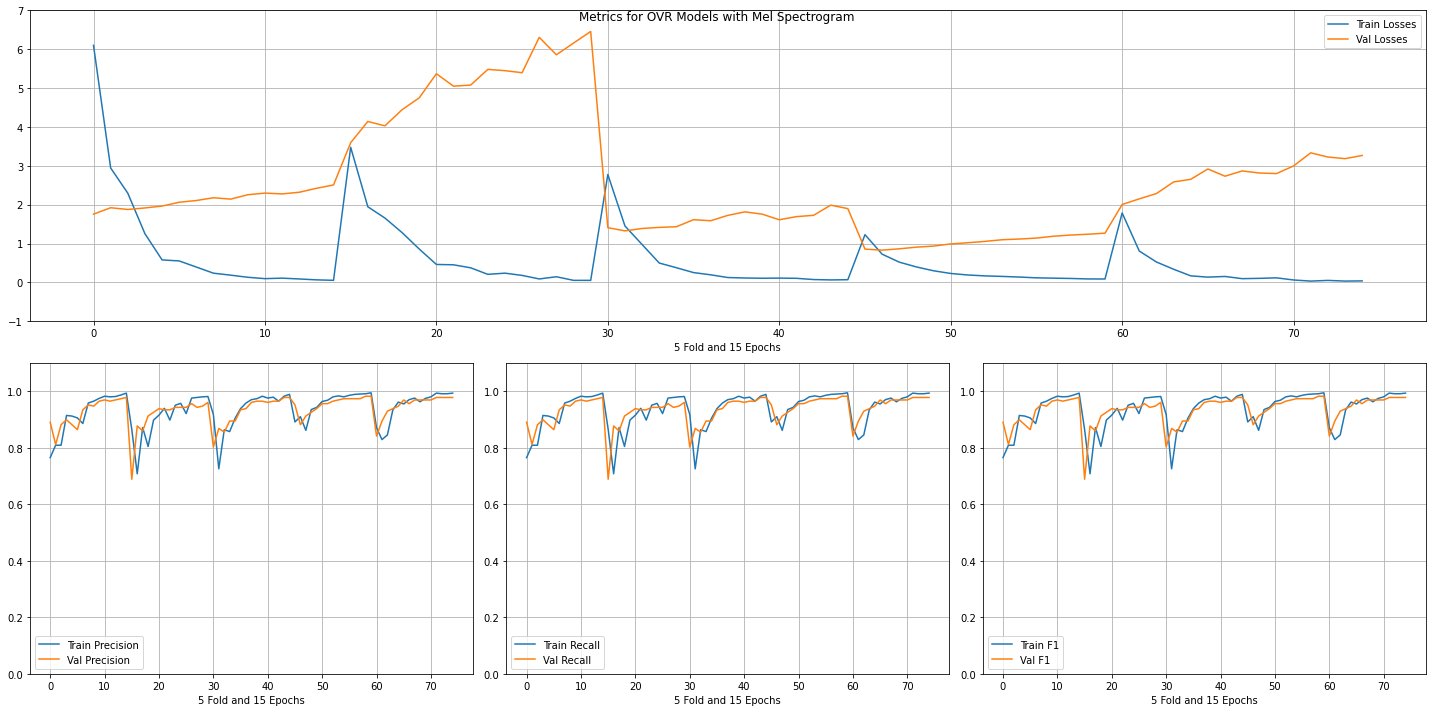

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.994512       0.982456  ...      0.086128           1.265533
13  0.991218       0.982456  ...      0.087993           1.238519
13  0.982437       0.978070  ...      0.062547           1.986508
14  0.993414       0.978070  ...      0.051727           2.506892
14  0.989023       0.978070  ...      0.067685           1.898056
..       ...            ...  ...           ...                ...
2   0.863886       0.855263  ...      0.973187           1.386749
0   0.870614       0.841410  ...      1.786675           2.003776
1   0.809001       0.811404  ...      2.944519           1.920574
0   0.917673       0.802632  ...      2.775817           1.407783
0   0.864984       0.688596  ...      3.476547           3.594419

[75 rows x 8 columns]
Training for ['సాళంగనాట'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54497608 6.05851064]
Epoch 1/15 : Training Loss: 4.901 / Validation Loss

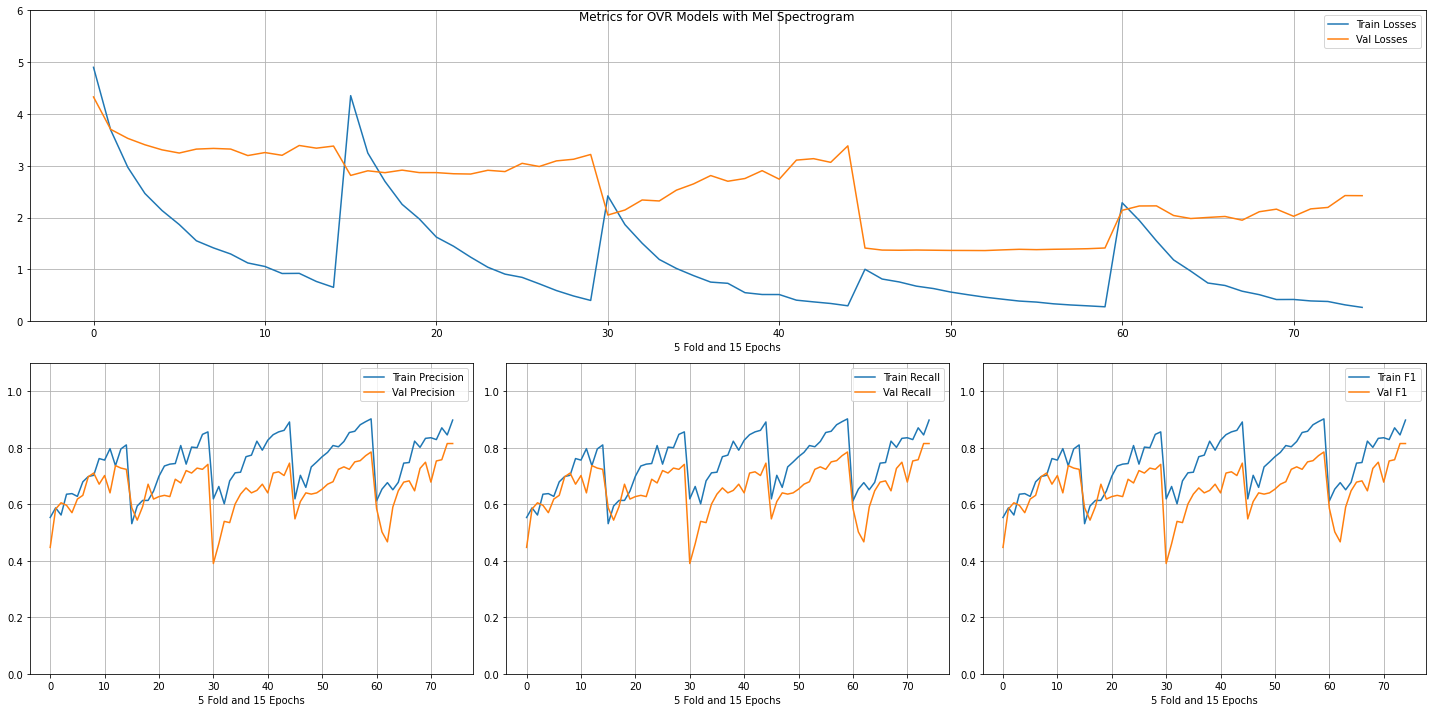

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.898026       0.814978  ...      0.266481           2.423159
13  0.845395       0.814978  ...      0.315455           2.425265
14  0.902305       0.785088  ...      0.278013           1.413233
13  0.892426       0.771930  ...      0.296371           1.399556
12  0.870614       0.757709  ...      0.380739           2.196438
..       ...            ...  ...           ...                ...
1   0.653509       0.502203  ...      1.945873           2.224303
2   0.676535       0.466960  ...      1.550677           2.226450
1   0.663008       0.460526  ...      1.864138           2.146923
0   0.553238       0.447368  ...      4.900900           4.329091
0   0.619100       0.390351  ...      2.419299           2.049058

[75 rows x 8 columns]


In [28]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MelMatrixDataset, MelRaga, "OVR Models with Mel Spectrogram", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-6, epochs=15, n_folds=5, feature='mel_spec')

In [29]:
for k in ovr_res:
  print(le.inverse_transform([k]))
  print(results_to_df(ovr_res[k]).head())

['ఆహిరి']
    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.887061       0.885463  ...      0.220530           2.914443
13  0.929748       0.881579  ...      0.202822           5.439974
14  0.926454       0.881579  ...      0.215044           5.327569
14  0.946272       0.881057  ...      0.181549           2.890033
13  0.952851       0.876652  ...      0.188458           2.837072

[5 rows x 8 columns]
['కన్నడగౌళ']
    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.989023       0.978070  ...      0.119467           1.497123
14  0.990121       0.978070  ...      0.104329           1.542797
12  0.986828       0.973684  ...      0.124569           1.487753
11  0.985730       0.973684  ...      0.122425           1.419740
10  0.984632       0.973684  ...      0.154258           1.341329

[5 rows x 8 columns]
['కాంబోది']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.987925       0.973684  ...      0.118548           1.5749

# Mapping each Raga with Janaka Ragam

In [30]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [31]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [32]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

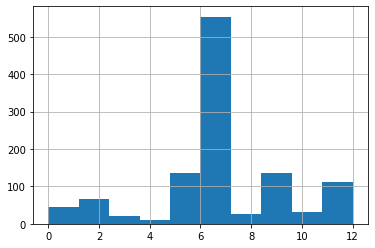

In [33]:
data['JanakaRagamCode'].hist()

In [34]:
class MelsJanakaRagaDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelsJanakaRagaDataset(train_lbls, train_vals)
      test_data = MelsJanakaRagaDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [ ]:
mc = jle.transform(['Unknown'])
data = data[data['JanakaRagamCode']!=mc[0]]


Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51192748 21.46      ]
Epoch 1/15 : Training Loss: 14.067 / Validation Loss : 5.624 [Time Taken : 3.036261 seconds]
Epoch 2/15 : Training Loss: 4.924 / Validation Loss : 5.674 [Time Taken : 2.998531 seconds]
Epoch 3/15 : Training Loss: 0.938 / Validation Loss : 9.568 [Time Taken : 3.023671 seconds]
Epoch 4/15 : Training Loss: 0.599 / Validation Loss : 7.069 [Time Taken : 3.002289 seconds]
Epoch 5/15 : Training Loss: 0.144 / Validation Loss : 9.151 [Time Taken : 3.004234 seconds]
Epoch 6/15 : Training Loss: 0.111 / Validation Loss : 8.485 [Time Taken : 2.999951 seconds]
Epoch 7/15 : Training Loss: 0.062 / Validation Loss : 8.526 [Time Taken : 3.015284 seconds]
Epoch 8/15 : Training Loss: 0.050 / Validation Loss : 8.296 [Time Taken : 3.002879 seconds]
Epoch 9/15 : Training Loss: 0.038 / Validation Loss : 8.662 [Time Taken : 3.016255 seconds]
Epoch 10/15 : Training Loss: 0.031

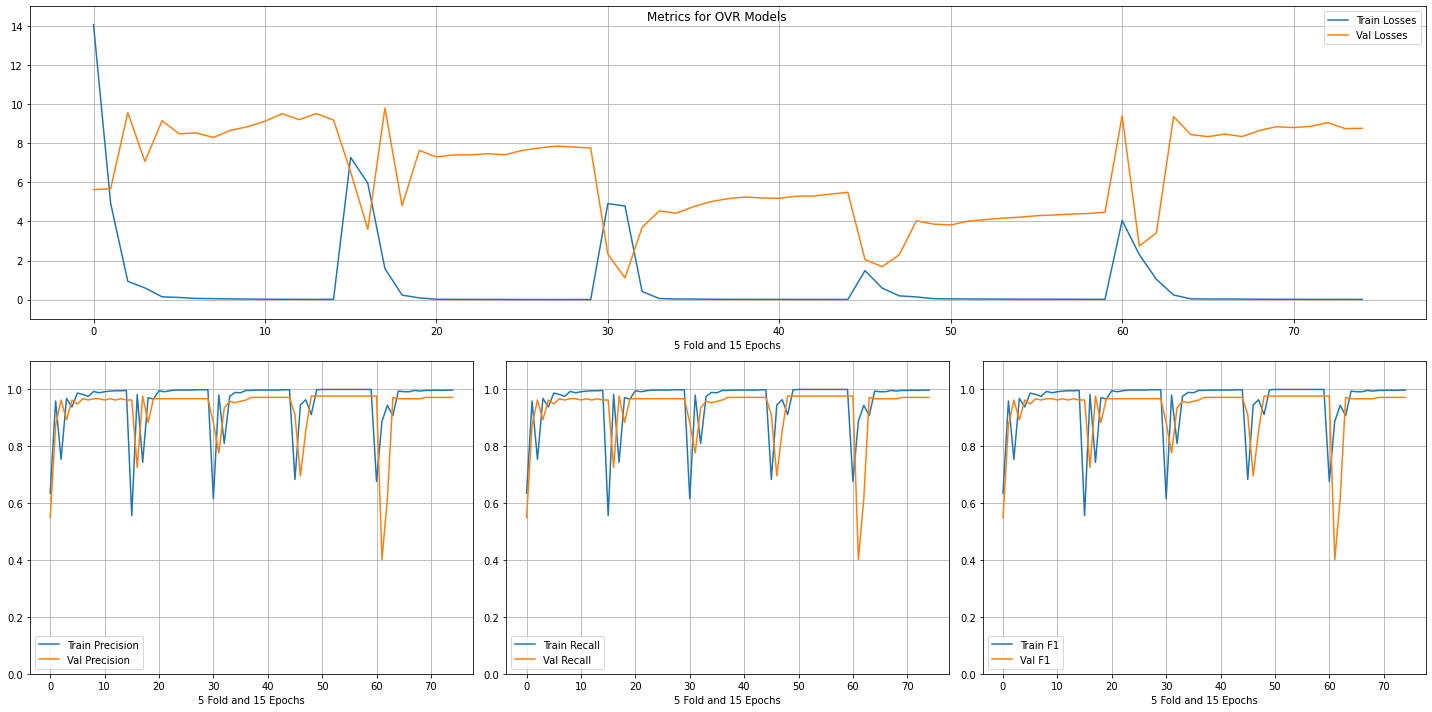

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.743590       0.976744  ...      1.588891           9.801864
9   1.000000       0.976636  ...      0.024723           4.215312
13  1.000000       0.976636  ...      0.019142           4.405687
7   1.000000       0.976636  ...      0.030996           4.089850
8   1.000000       0.976636  ...      0.028336           4.166130
..       ...            ...  ...           ...                ...
1   0.982517       0.725581  ...      5.952343           3.596885
1   0.945285       0.696262  ...      0.590478           1.689650
2   0.944121       0.616822  ...      1.035431           3.419699
0   0.635198       0.548837  ...     14.067435           5.624097
1   0.888242       0.401869  ...      2.304515           2.740743

[75 rows x 8 columns]
Training for ['Hanumatodi'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.50949668 26.825     ]
Epoch 1/15 : Training Loss: 8.115 / Validation 

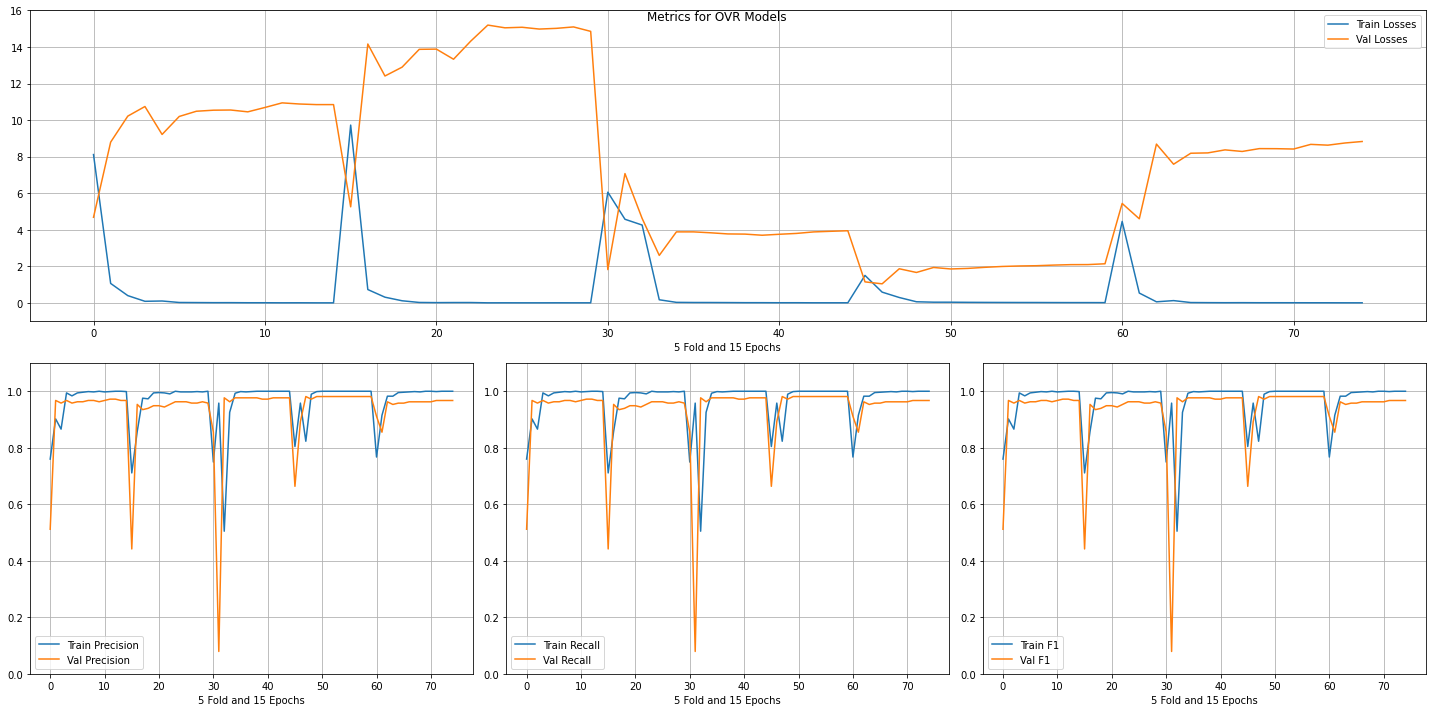

    train_f1  validation_f1  ...  train_losses  validation_losses
9   1.000000       0.981308  ...      0.023316           2.020955
7   1.000000       0.981308  ...      0.028261           1.946924
6   1.000000       0.981308  ...      0.032188           1.887822
10  1.000000       0.981308  ...      0.022378           2.035183
11  1.000000       0.981308  ...      0.019696           2.068751
..       ...            ...  ...           ...                ...
1   0.915017       0.855140  ...      0.539663           4.601046
0   0.804424       0.663551  ...      1.504313           1.151156
0   0.759907       0.511628  ...      8.114543           4.684302
0   0.710956       0.441860  ...      9.726673           5.256071
1   0.958042       0.079070  ...      4.575752           7.074635

[75 rows x 8 columns]
Training for ['Harikambhoji'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.53277061 8.12878788]
Epoch 1/15 : Training Loss: 5.942 / Validation 

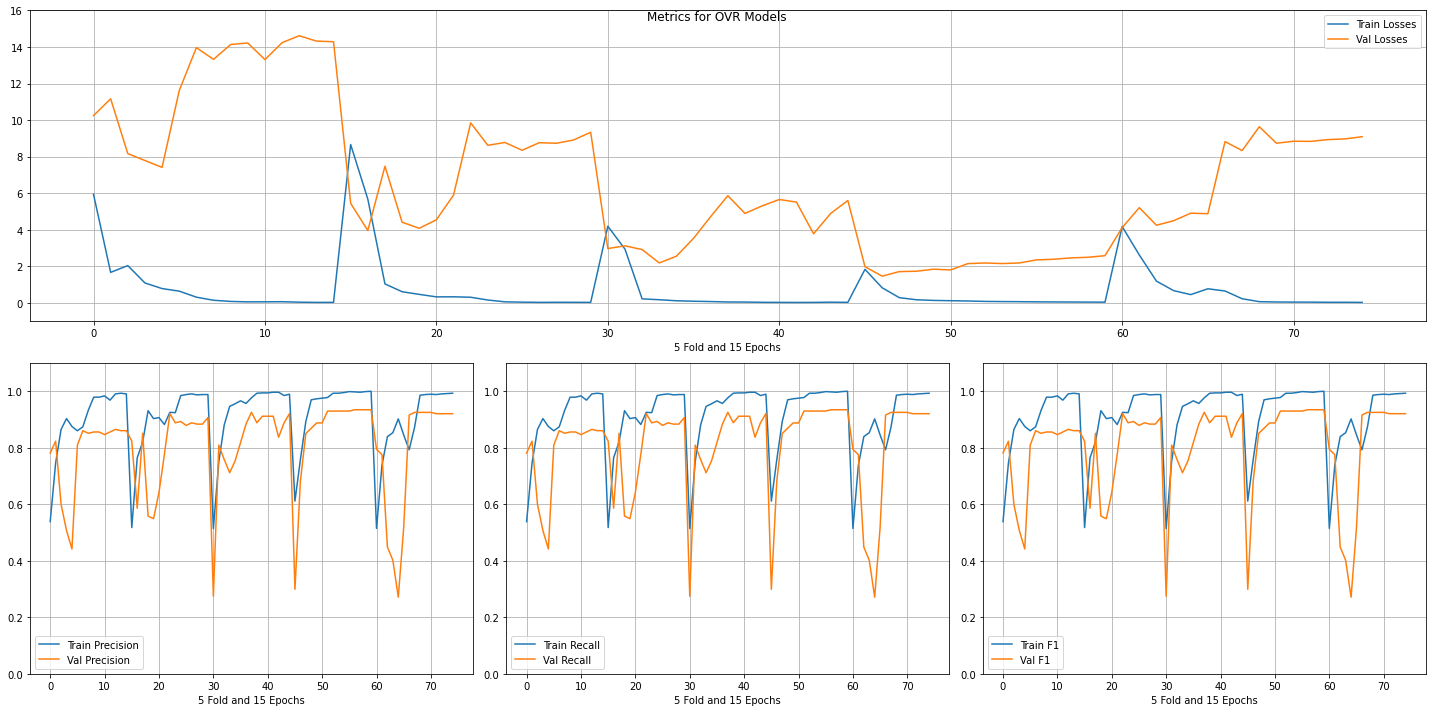

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.934579  ...      0.040520           2.583790
13  0.998836       0.934579  ...      0.045180           2.496021
11  0.997672       0.934579  ...      0.053467           2.387712
12  0.996508       0.934579  ...      0.049161           2.461947
6   0.977881       0.929907  ...      0.104323           2.149517
..       ...            ...  ...           ...                ...
4   0.875291       0.441860  ...      0.784484           7.413489
3   0.853318       0.401869  ...      0.673401           4.494168
0   0.611176       0.299065  ...      1.835977           1.979754
0   0.513986       0.274419  ...      4.193776           2.974204
4   0.902212       0.271028  ...      0.454417           4.907924

[75 rows x 8 columns]
Training for ['Jhalavarali'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51046622 24.38636364]
Epoch 1/15 : Training Loss: 8.984 / Validation

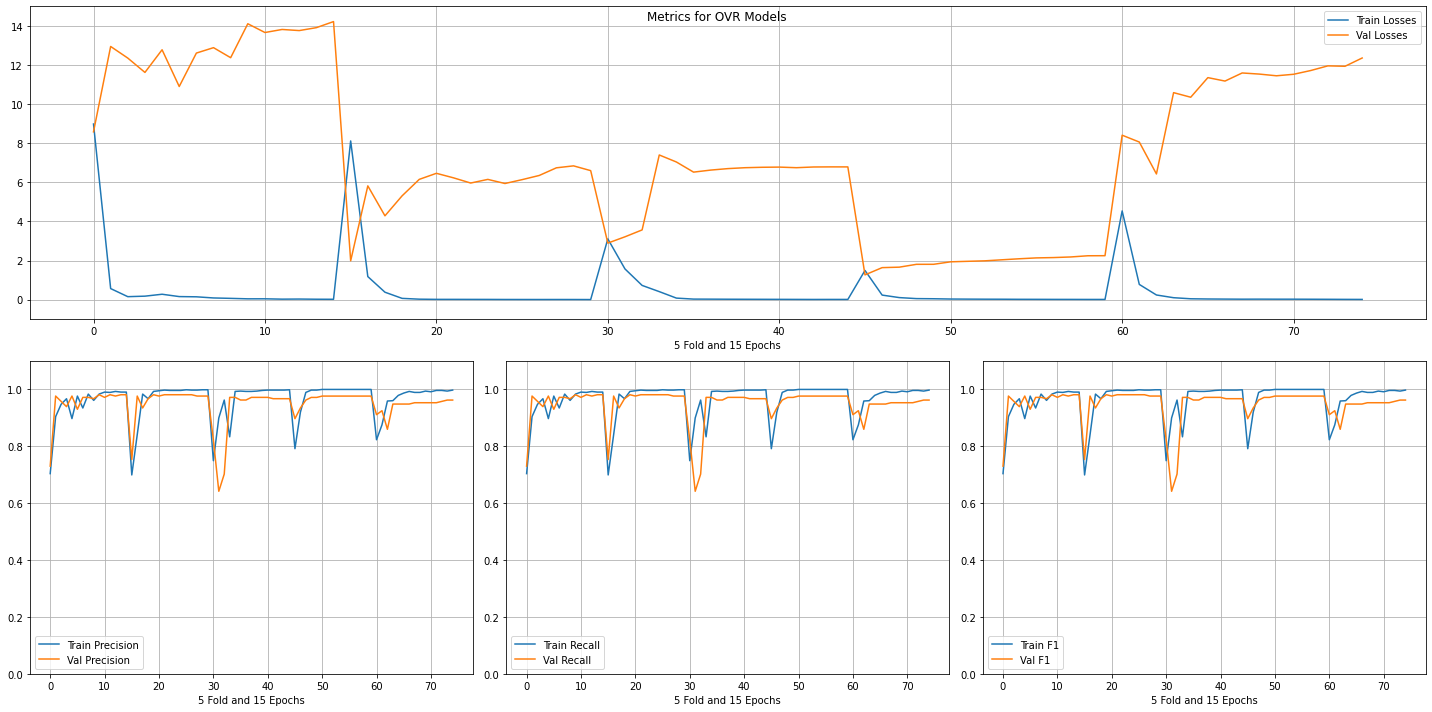

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.996503       0.981395  ...      0.008873           5.940887
4   0.993007       0.981395  ...      0.024292           6.152143
11  0.997669       0.981395  ...      0.007270           6.352338
10  0.998834       0.981395  ...      0.008057           6.138303
8   0.996503       0.981395  ...      0.011878           6.151157
..       ...            ...  ...           ...                ...
0   0.749417       0.823256  ...      3.107588           2.893605
0   0.699301       0.753488  ...      8.118150           1.986895
0   0.703963       0.730233  ...      8.983880           8.585944
2   0.962704       0.702326  ...      0.727614           3.567077
1   0.899767       0.641860  ...      1.571098           3.214467

[75 rows x 8 columns]
Training for ['Kalyani'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.50517891 48.77272727]
Epoch 1/15 : Training Loss: 9.675 / Validation Los

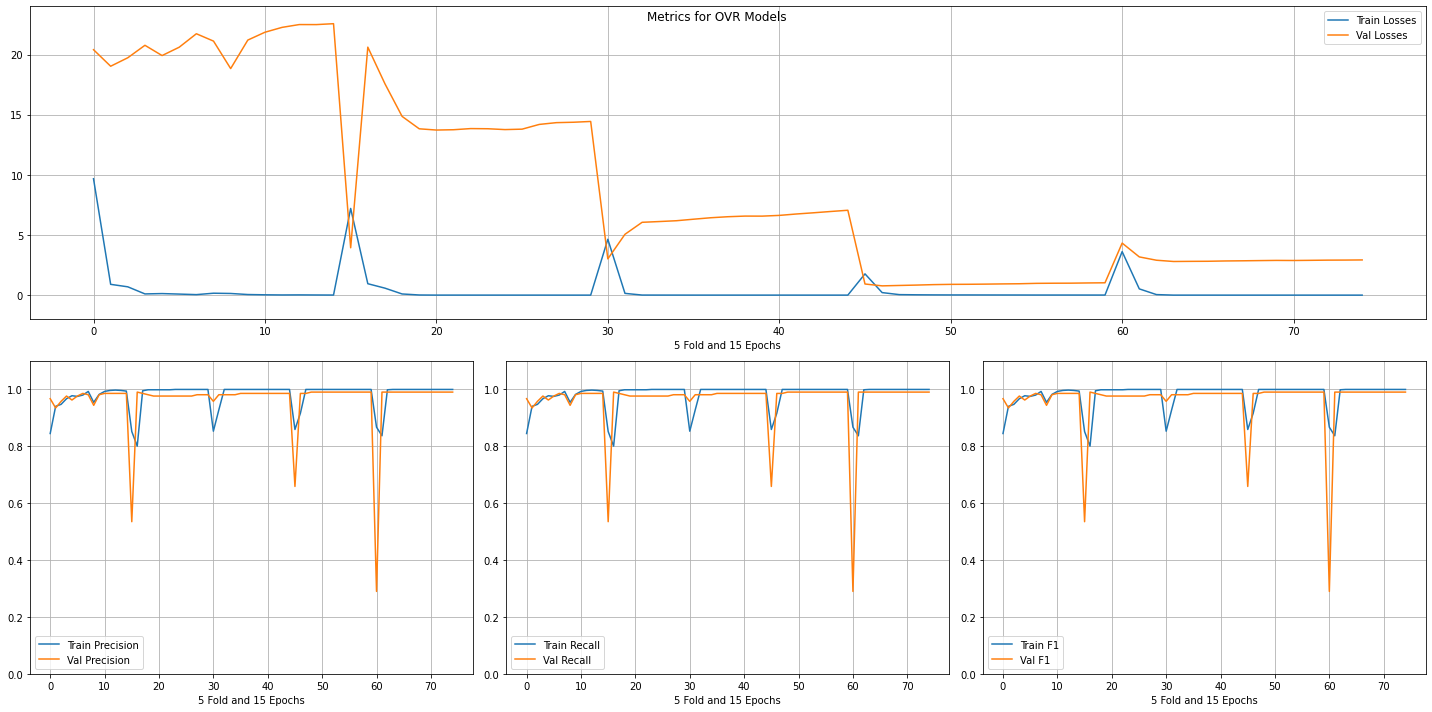

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.800699       0.990698  ...      0.949837          20.612487
14  1.000000       0.990654  ...      0.000962           2.925986
1   0.837020       0.990654  ...      0.519957           3.177756
3   1.000000       0.990654  ...      0.028433           0.835798
4   1.000000       0.990654  ...      0.020656           0.873749
..       ...            ...  ...           ...                ...
8   0.954545       0.944186  ...      0.138556          18.831054
1   0.940559       0.934884  ...      0.897498          19.026237
0   0.859139       0.658879  ...      1.768045           0.925516
0   0.851981       0.534884  ...      7.206597           3.936443
0   0.867288       0.289720  ...      3.618398           4.325623

[75 rows x 8 columns]
Training for ['Kharaharapriya'] with 135 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.57196162 3.97407407]
Epoch 1/15 : Training Loss: 5.645 / Validati

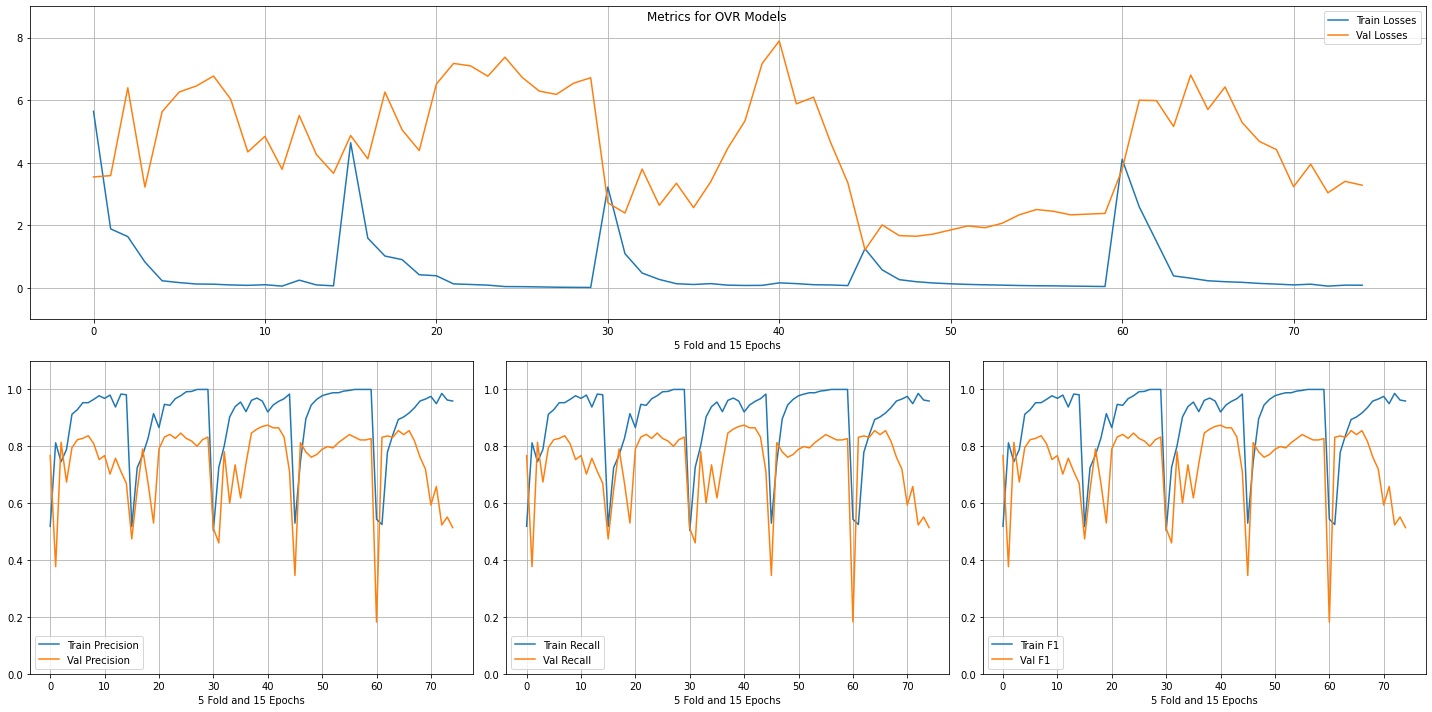

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.920746       0.874419  ...      0.161261           7.895313
9   0.959207       0.869767  ...      0.081657           7.173286
12  0.958042       0.865116  ...      0.102554           6.097917
11  0.945221       0.865116  ...      0.137535           5.885964
8   0.969697       0.860465  ...      0.078368           5.340323
..       ...            ...  ...           ...                ...
0   0.517483       0.474419  ...      4.641266           4.871491
1   0.726107       0.460465  ...      1.095405           2.393895
1   0.812354       0.376744  ...      1.887539           3.590185
0   0.529686       0.345794  ...      1.253288           1.219308
0   0.543655       0.182243  ...      4.112264           3.792972

[75 rows x 8 columns]
Training for ['Mayamalavagowla'] with 465 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.88240132 1.15376344]
Epoch 1/15 : Training Loss: 4.867 / Validat

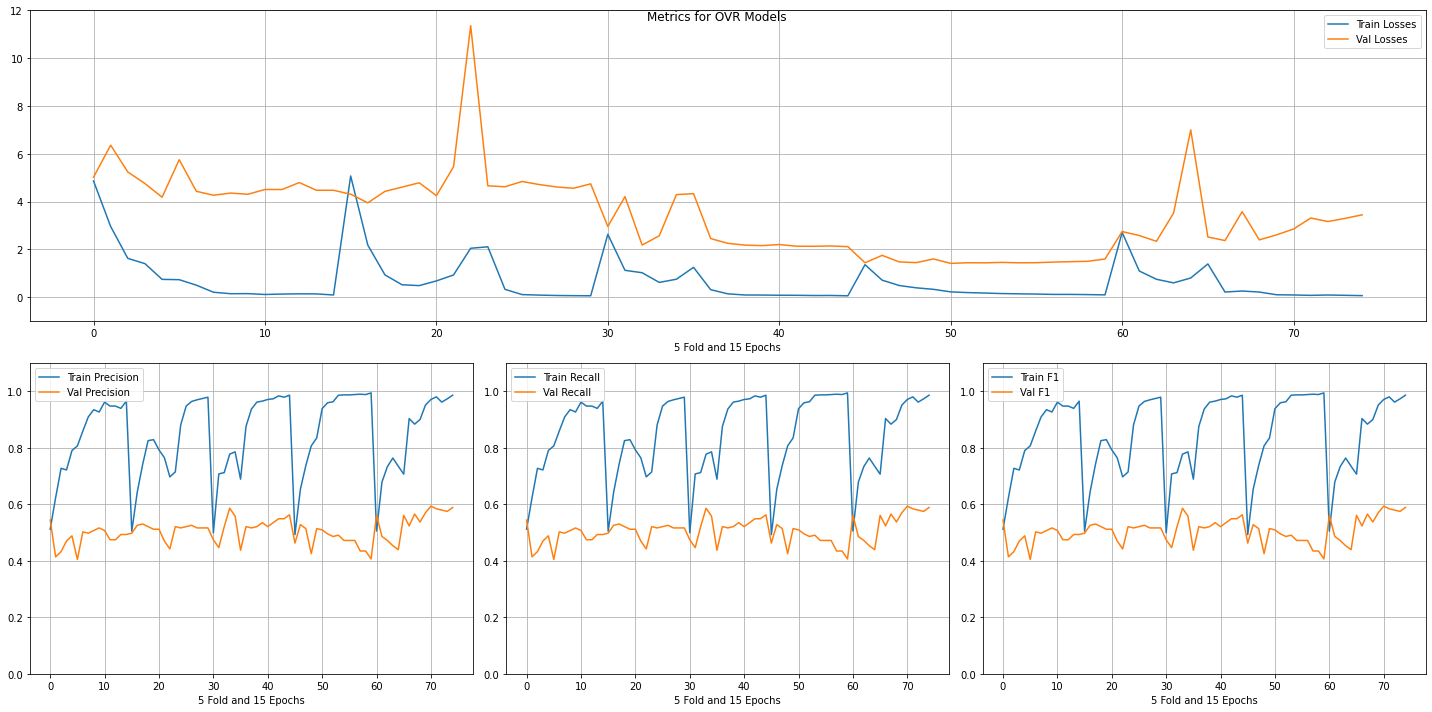

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.970896       0.593458  ...      0.096702           2.856052
14  0.986030       0.588785  ...      0.069697           3.449040
3   0.777389       0.586047  ...      0.622428           2.573752
11  0.980210       0.584112  ...      0.081024           3.316137
12  0.961583       0.579439  ...      0.095775           3.167507
..       ...            ...  ...           ...                ...
2   0.727273       0.432558  ...      1.628097           5.241260
3   0.806752       0.425234  ...      0.395274           1.450875
1   0.623543       0.413953  ...      2.962211           6.362164
14  0.994179       0.406542  ...      0.101479           1.601490
5   0.806527       0.404651  ...      0.736465           5.754799

[75 rows x 8 columns]
Training for ['Naganandini'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.54522358 6.02808989]
Epoch 1/15 : Training Loss: 5.491 / Validation L

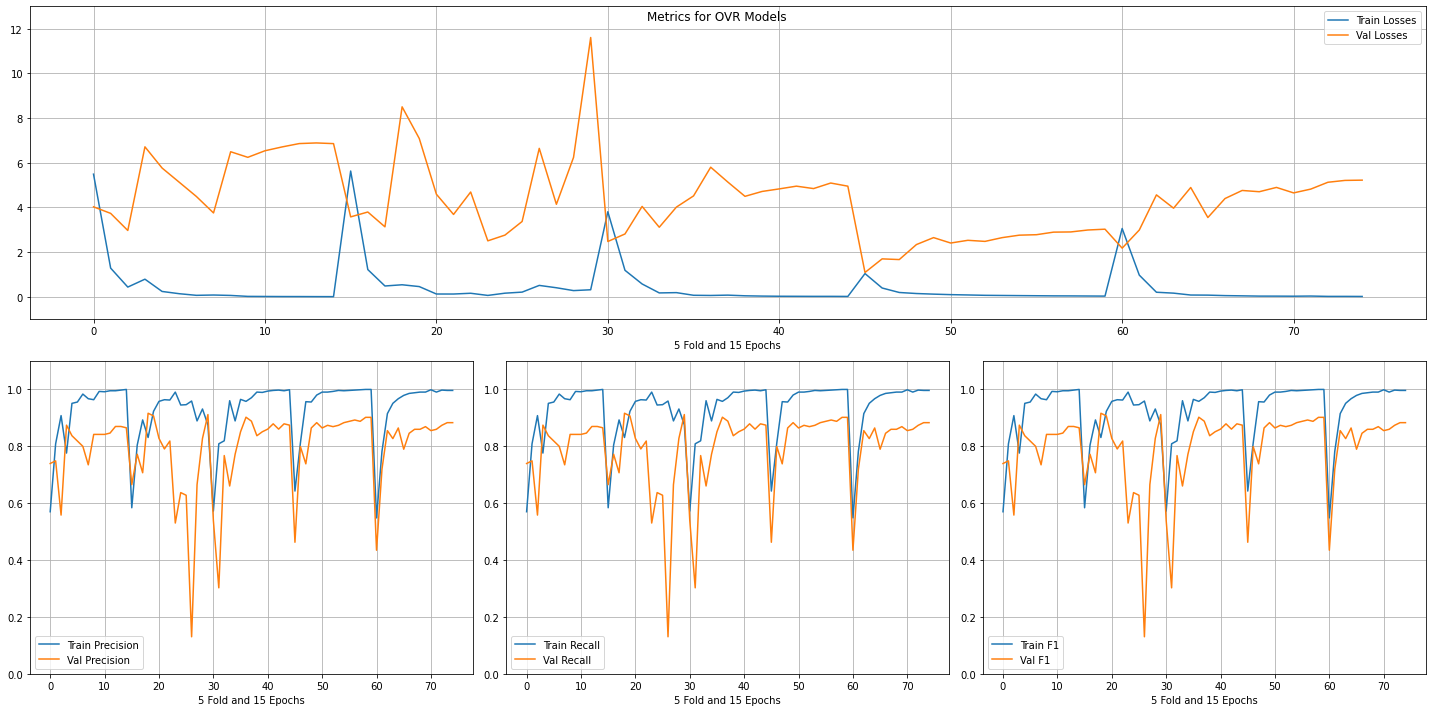

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.831002       0.916279  ...      0.540954           8.504624
14  0.875291       0.911628  ...      0.317442          11.607973
4   0.923077       0.906977  ...      0.460291           7.089289
6   0.958042       0.902326  ...      0.062418           5.803188
14  1.000000       0.901869  ...      0.033709           3.028617
..       ...            ...  ...           ...                ...
8   0.990676       0.530233  ...      0.064547           2.507028
0   0.642608       0.462617  ...      1.042049           1.091373
0   0.548312       0.434579  ...      3.059769           2.180043
1   0.808858       0.302326  ...      1.188689           2.814571
11  0.959207       0.130233  ...      0.512482           6.646091

[75 rows x 8 columns]
Training for ['Natabhairavi'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51290631 19.87037037]
Epoch 1/15 : Training Loss: 5.775 / Validatio

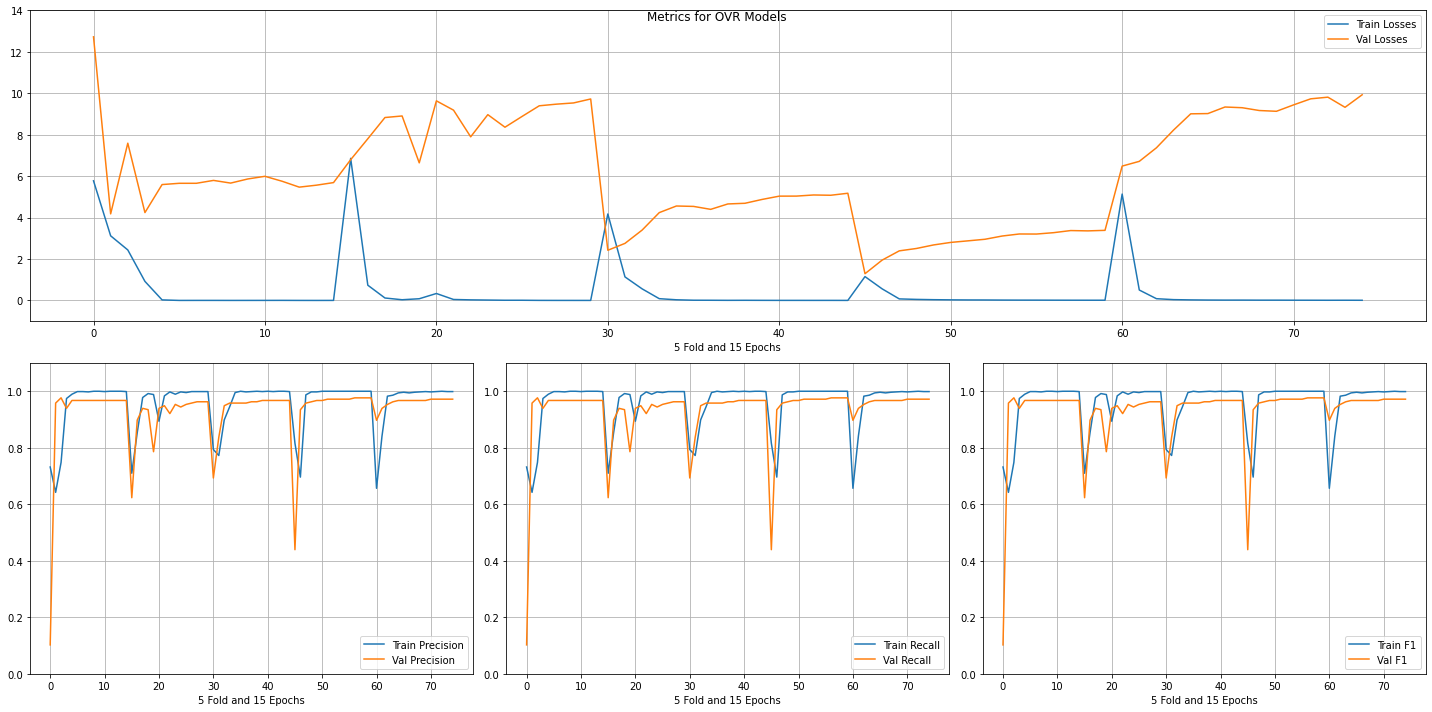

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.748252       0.976744  ...      2.438635           7.591152
14  1.000000       0.976636  ...      0.012307           3.384597
13  1.000000       0.976636  ...      0.012372           3.359028
12  1.000000       0.976636  ...      0.013209           3.374643
11  1.000000       0.976636  ...      0.014584           3.272486
..       ...            ...  ...           ...                ...
4   0.988345       0.786047  ...      0.083564           6.642637
0   0.793706       0.693023  ...      4.175100           2.423856
0   0.709790       0.623256  ...      6.859829           6.794868
0   0.816065       0.439252  ...      1.152788           1.292341
0   0.731935       0.102326  ...      5.774687          12.725031

[75 rows x 8 columns]
Training for ['Shankarabharanam'] with 136 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [0.57257204 3.94485294]
Epoch 1/15 : Training Loss: 5.499 / Valida

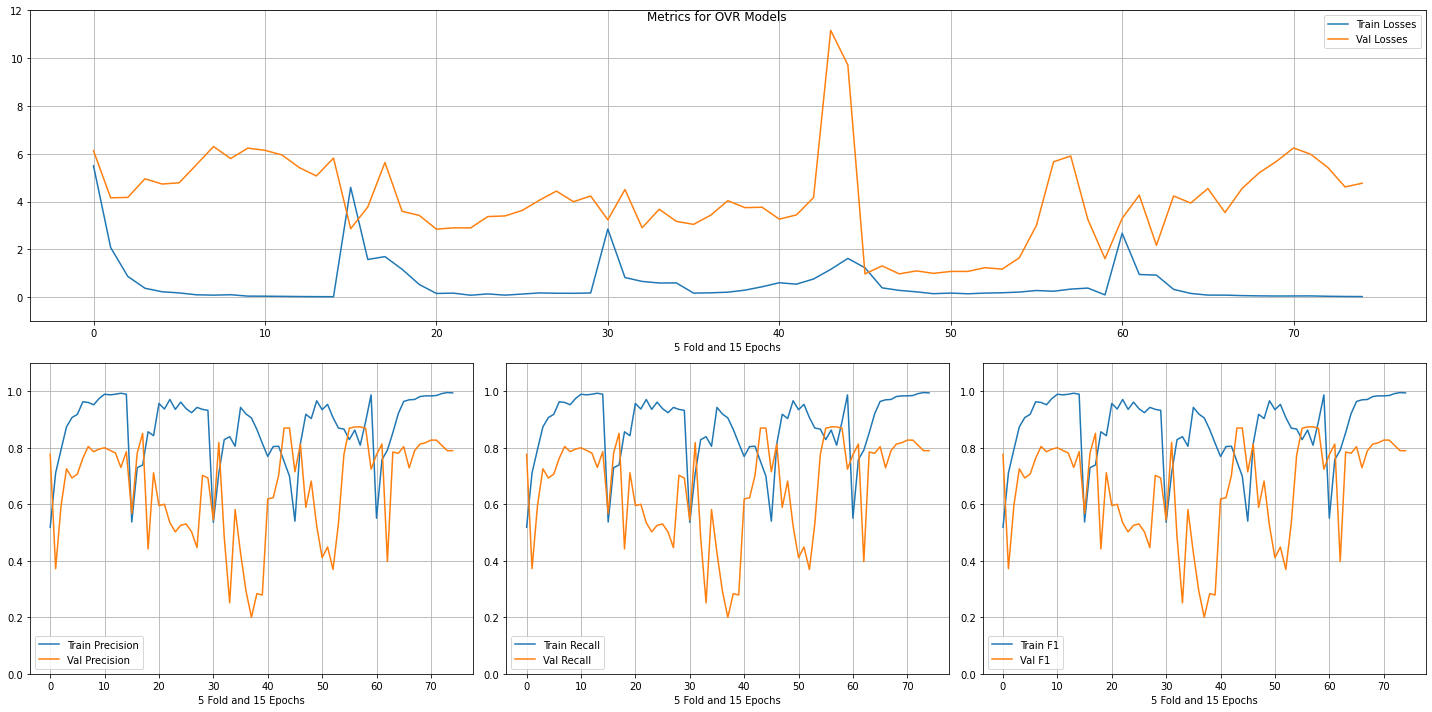

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.809080       0.873832  ...      0.342267           5.909404
11  0.862631       0.873832  ...      0.253467           5.668151
13  0.751748       0.869767  ...      1.166795          11.164121
14  0.699301       0.869767  ...      1.625945           9.717684
10  0.828871       0.869159  ...      0.283703           3.005849
..       ...            ...  ...           ...                ...
6   0.919580       0.293023  ...      0.186368           3.434107
8   0.864802       0.283721  ...      0.298796           3.749571
9   0.815851       0.279070  ...      0.440315           3.766864
3   0.839161       0.251163  ...      0.596899           3.683121
7   0.905594       0.200000  ...      0.214113           4.041184

[75 rows x 8 columns]
Training for ['Shubhapantuvarali'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.51536984 16.765625  ]
Epoch 1/15 : Training Loss: 8.049 / Vali

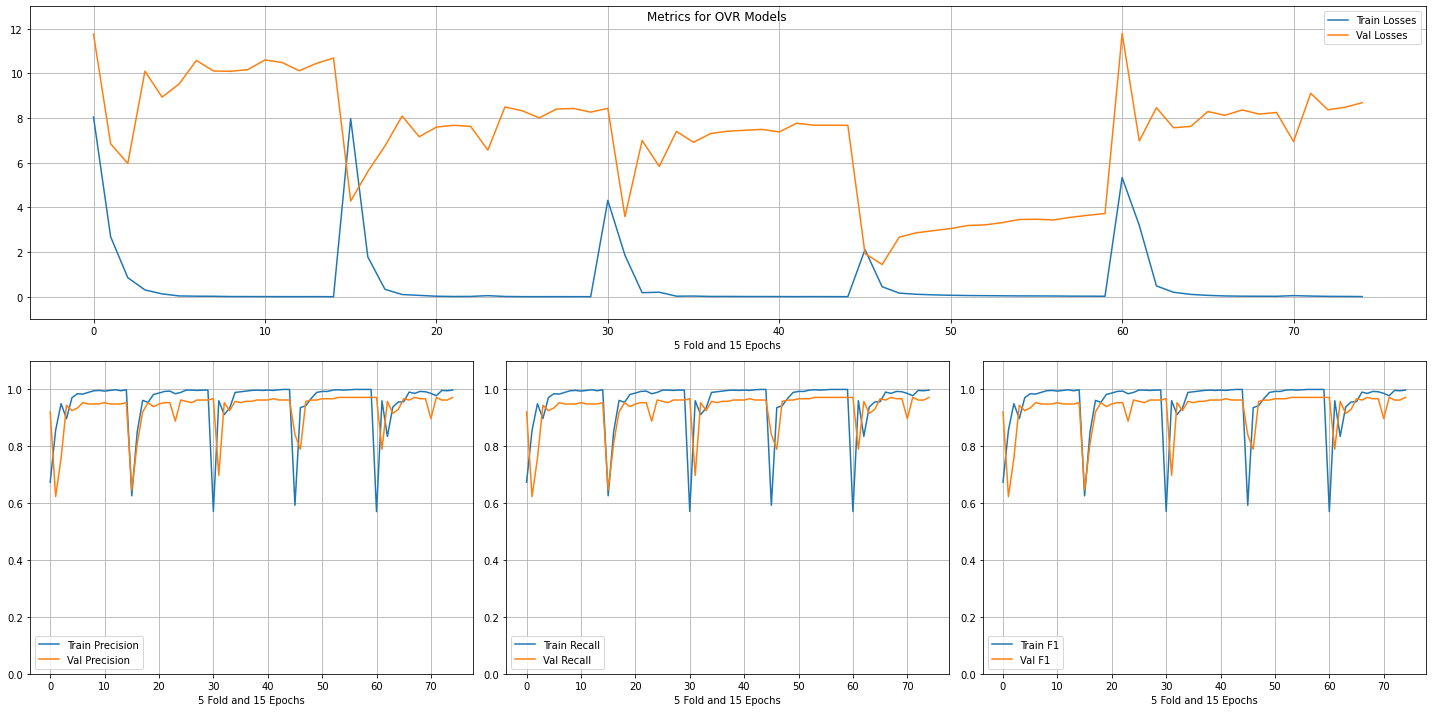

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.997672       0.971963  ...      0.013526           8.689713
0   0.570431       0.971963  ...      5.339142          11.785853
9   0.997672       0.971963  ...      0.041979           3.462486
10  0.998836       0.971963  ...      0.040654           3.473726
11  1.000000       0.971963  ...      0.038156           3.441757
..       ...            ...  ...           ...                ...
1   0.935972       0.789720  ...      0.453443           1.448760
2   0.949883       0.758140  ...      0.856971           5.970005
1   0.960373       0.697674  ...      1.859676           3.589050
0   0.625874       0.646512  ...      7.978752           4.287650
1   0.856643       0.623256  ...      2.689269           6.850269

[75 rows x 8 columns]
Training for ['Vakulabharanam'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 858/215
Class Weights : [ 0.52188716 11.92222222]
Epoch 1/15 : Training Loss: 5.914 / Validat

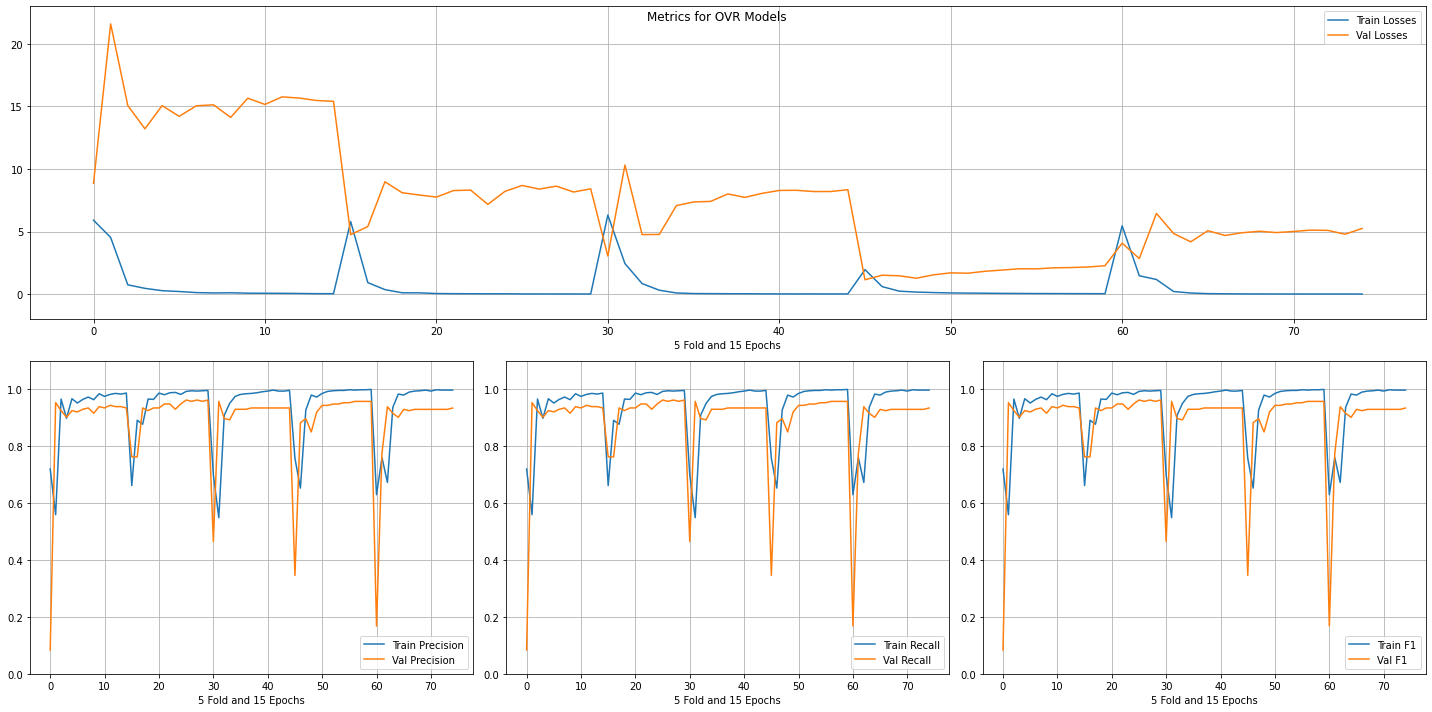

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.994172       0.962791  ...      0.017168           8.634524
14  0.996503       0.962791  ...      0.013928           8.419562
10  0.993007       0.962791  ...      0.019326           8.687001
11  0.995338       0.958140  ...      0.017436           8.396026
1   0.548951       0.958140  ...      2.442406          10.318973
..       ...            ...  ...           ...                ...
1   0.891608       0.762791  ...      0.923131           5.407824
0   0.699301       0.465116  ...      6.323917           3.046946
0   0.757858       0.345794  ...      1.958283           1.150981
0   0.629802       0.168224  ...      5.463740           4.078469
0   0.720280       0.083721  ...      5.913613           8.865927

[75 rows x 8 columns]


In [47]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
labels = jle.transform(jle.classes_)
n_labels = len(data['JanakaRagamCode'].unique())

jovr_res = ovr_train_model(data, MelsJanakaRagaDataset, MelRaga, "OVR Models", labels, 
                           jle.classes_, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-5, epochs=15, n_folds=5, 
                           feature='mel_spec')

In [48]:
for k in jovr_res:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
2    0.74359       0.976744  ...      1.588891           9.801864
9    1.00000       0.976636  ...      0.024723           4.215312
13   1.00000       0.976636  ...      0.019142           4.405687
7    1.00000       0.976636  ...      0.030996           4.089850
8    1.00000       0.976636  ...      0.028336           4.166130

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
9        1.0       0.981308  ...      0.023316           2.020955
7        1.0       0.981308  ...      0.028261           1.946924
6        1.0       0.981308  ...      0.032188           1.887822
10       1.0       0.981308  ...      0.022378           2.035183
11       1.0       0.981308  ...      0.019696           2.068751

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.934579  ...      0.040520      

# OVR Experiment without Mayamalavagowla Raga

In [49]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
cl = [x for x in cl if not x in ['Mayamalavagowla','Unknown'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 536/537
Class Weights : [ 0.51192748 21.46      ]
Epoch 1/15 : Training Loss: 12.995 / Validation Loss : 5.984 [Time Taken : 2.632712 seconds]
Epoch 2/15 : Training Loss: 7.326 / Validation Loss : 5.349 [Time Taken : 2.625366 seconds]
Epoch 3/15 : Training Loss: 1.938 / Validation Loss : 5.353 [Time Taken : 2.600434 seconds]
Epoch 4/15 : Training Loss: 0.521 / Validation Loss : 4.922 [Time Taken : 2.624508 seconds]
Epoch 5/15 : Training Loss: 0.333 / Validation Loss : 5.463 [Time Taken : 2.570779 seconds]
Epoch 6/15 : Training Loss: 0.037 / Validation Loss : 7.049 [Time Taken : 2.630801 seconds]
Epoch 7/15 : Training Loss: 0.047 / Validation Loss : 6.189 [Time Taken : 2.608231 seconds]
Epoch 8/15 : Training Loss: 0.028 / Validation Loss : 6.160 [Time Taken : 2.603349 seconds]
Epoch 9/15 : Training Loss: 0.024 / Validation Loss : 6.374 [Time Taken : 2.60512 seconds]
Epoch 10/15 : Training Loss: 0.020 

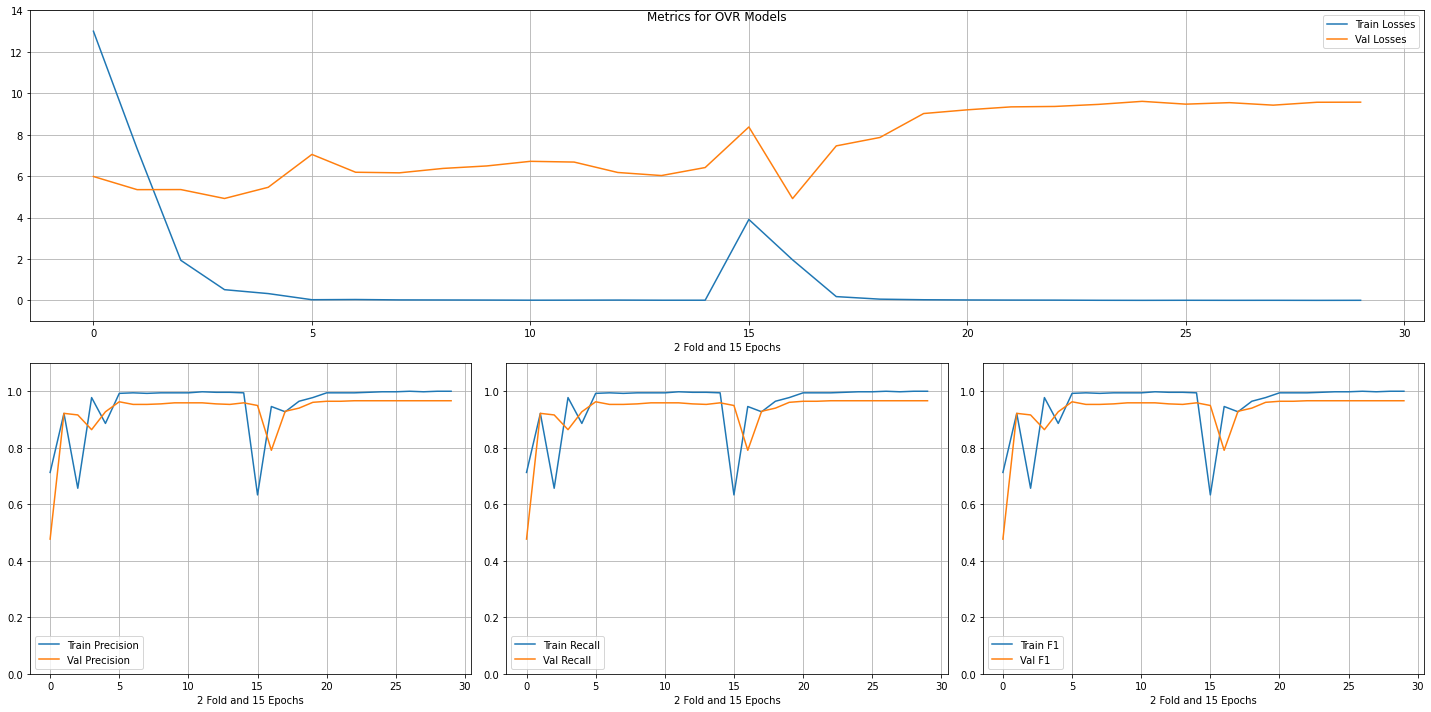

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.966418  ...      0.008427           9.571129
13  1.000000       0.966418  ...      0.005572           9.566636
12  0.998138       0.966418  ...      0.008379           9.426805
11  1.000000       0.966418  ...      0.007494           9.547431
7   0.994413       0.966418  ...      0.017200           9.364380
8   0.996276       0.966418  ...      0.009368           9.464048
9   0.998138       0.966418  ...      0.006840           9.610550
10  0.998138       0.966418  ...      0.009591           9.475161
6   0.994413       0.964552  ...      0.019612           9.343953
5   0.994413       0.964552  ...      0.025195           9.201848
5   0.992537       0.962756  ...      0.036639           7.049060
4   0.977654       0.960821  ...      0.035291           9.022912
9   0.994403       0.959032  ...      0.020293           6.492725
11  0.998134       0.959032  ...      0.015986           6.680193
14  0.9944

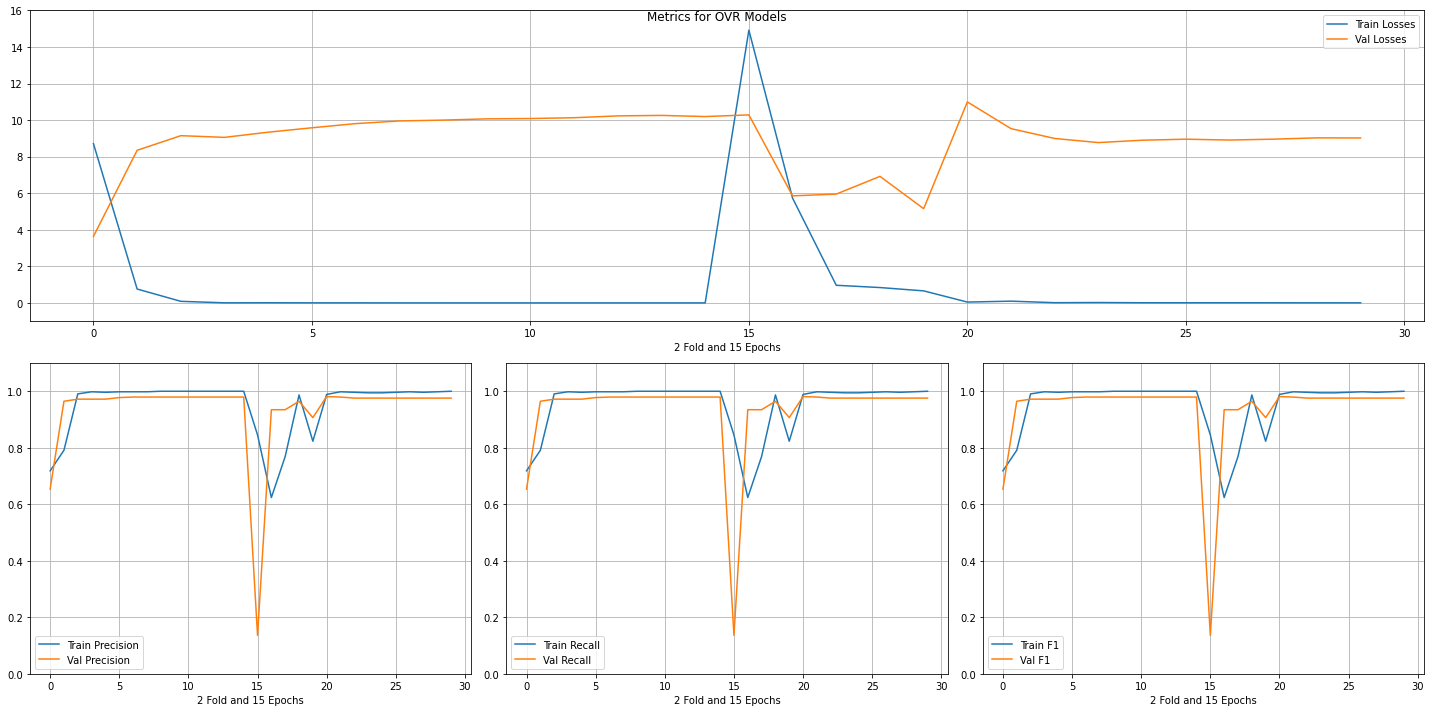

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.988827       0.981343  ...      0.046391          10.993376
14  1.000000       0.979516  ...      0.001189          10.193481
13  1.000000       0.979516  ...      0.000738          10.256129
12  1.000000       0.979516  ...      0.001572          10.229972
11  1.000000       0.979516  ...      0.000743          10.129302
10  1.000000       0.979516  ...      0.001253          10.085317
9   1.000000       0.979516  ...      0.001208          10.067249
8   1.000000       0.979516  ...      0.001624           9.999631
7   0.998134       0.979516  ...      0.001954           9.952683
6   0.998134       0.979516  ...      0.004256           9.806790
6   0.998138       0.979478  ...      0.095958           9.531889
5   0.998134       0.977654  ...      0.004548           9.579017
9   0.994413       0.975746  ...      0.009715           8.899651
10  0.996276       0.975746  ...      0.007804           8.955739
11  0.9981

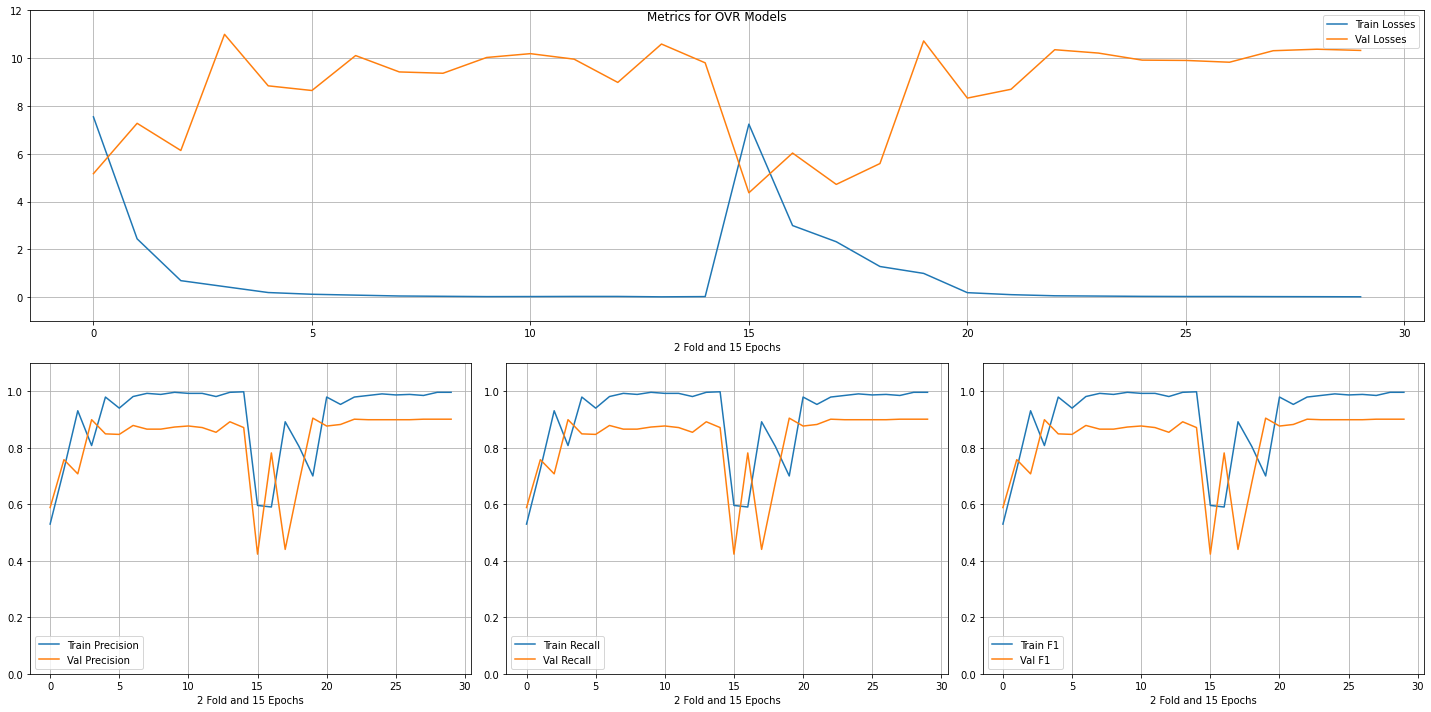

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.700186       0.904851  ...      0.999308          10.724066
14  0.996276       0.901119  ...      0.020930          10.325981
12  0.985102       0.901119  ...      0.028234          10.313910
7   0.979516       0.901119  ...      0.062862          10.355414
13  0.996276       0.901119  ...      0.025086          10.376312
3   0.807836       0.899441  ...      0.447175          10.999271
10  0.986965       0.899254  ...      0.033243           9.907315
9   0.990689       0.899254  ...      0.038935           9.920246
8   0.985102       0.899254  ...      0.050897          10.215099
11  0.988827       0.899254  ...      0.032845           9.832124
13  0.996269       0.891993  ...      0.019157          10.592726
6   0.953445       0.882463  ...      0.110004           8.701150
6   0.981343       0.878957  ...      0.090161          10.110520
10  0.992537       0.877095  ...      0.030828          10.190829
5   0.9795

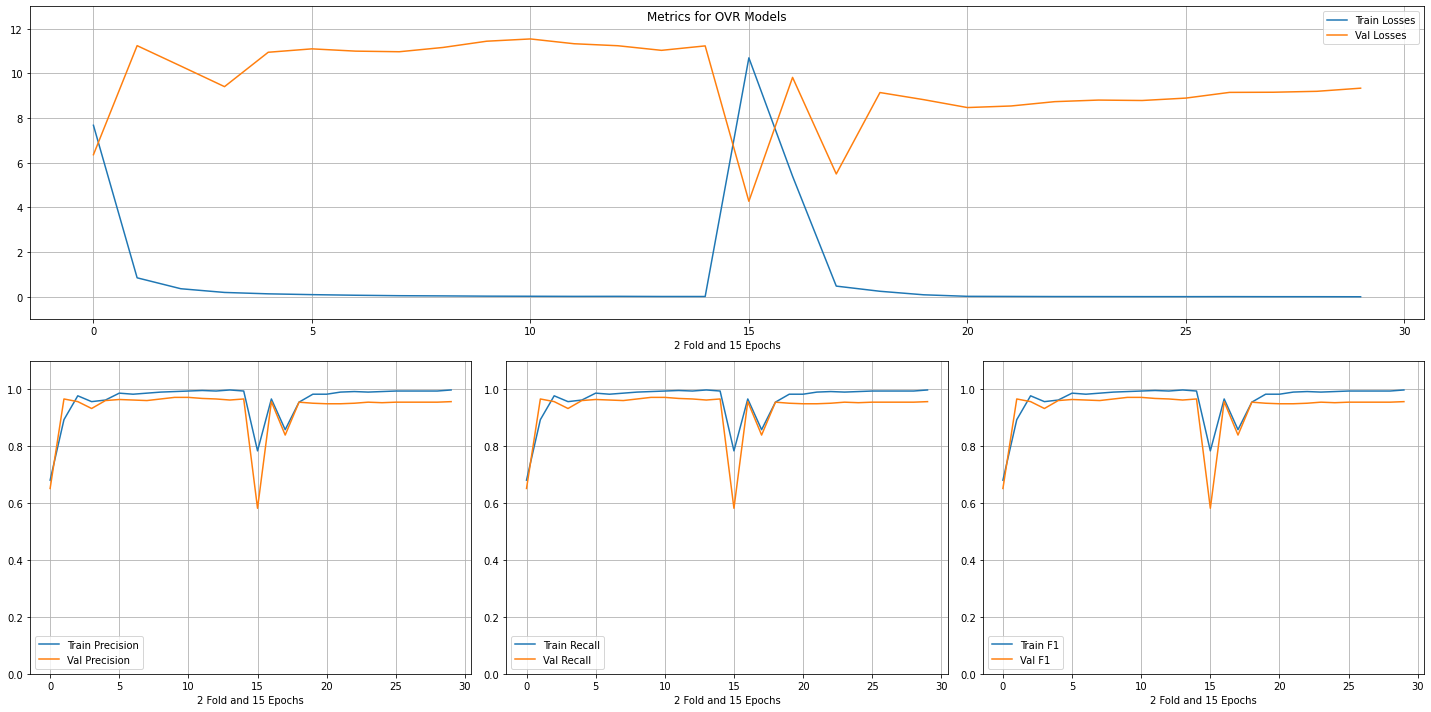

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.992537       0.972067  ...      0.031252          11.441844
10  0.994403       0.972067  ...      0.026819          11.543445
11  0.996269       0.968343  ...      0.021688          11.328739
14  0.994403       0.966480  ...      0.015481          11.232281
1   0.893657       0.966480  ...      0.852125          11.242836
8   0.990672       0.966480  ...      0.042813          11.162415
12  0.994403       0.966480  ...      0.023205          11.239526
5   0.986940       0.964618  ...      0.099432          11.099684
6   0.983209       0.962756  ...      0.072009          10.997815
13  0.998134       0.962756  ...      0.016301          11.033241
4   0.962687       0.960894  ...      0.135233          10.947429
7   0.986940       0.960894  ...      0.051449          10.970802
2   0.977612       0.957169  ...      0.363623          10.329411
1   0.966480       0.957090  ...      5.398275           9.822686
14  0.9981

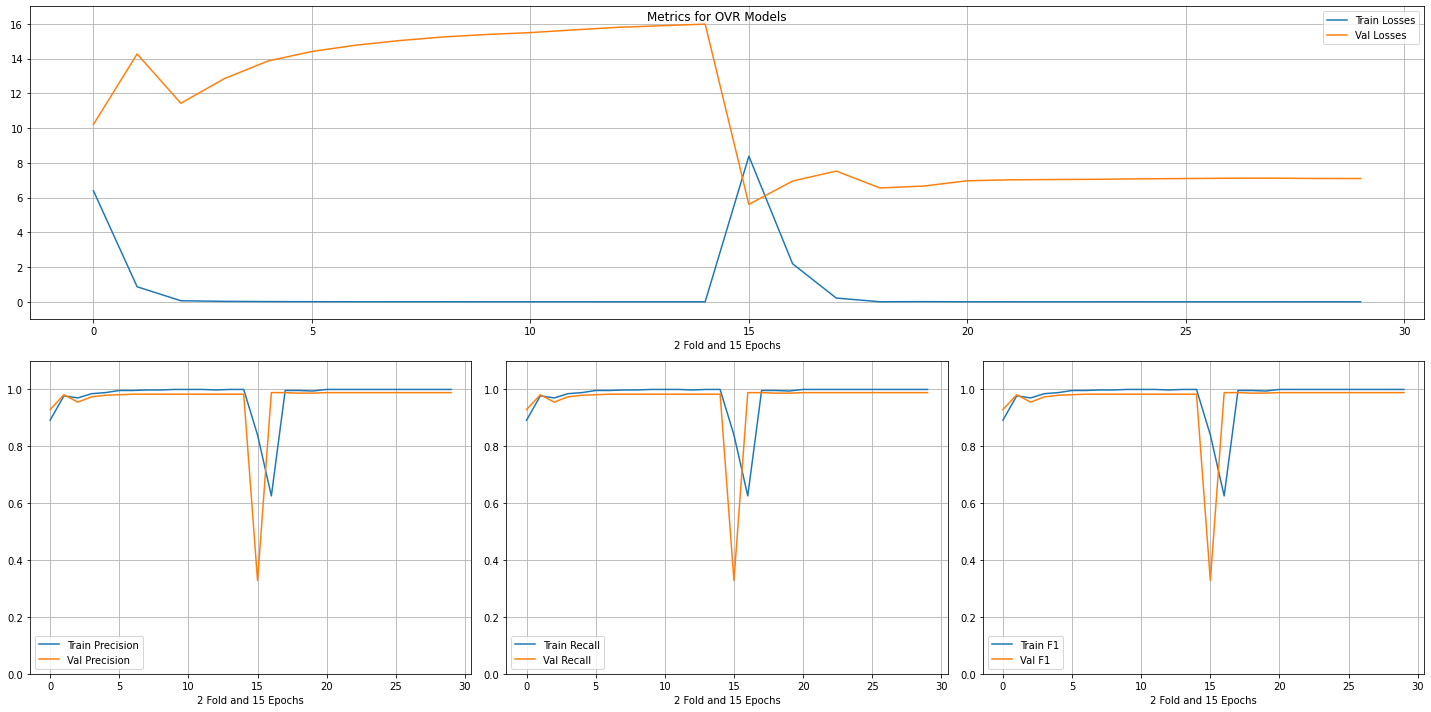

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.988806  ...      0.000769           7.093513
13  1.000000       0.988806  ...      0.001195           7.097468
11  1.000000       0.988806  ...      0.000646           7.111491
10  1.000000       0.988806  ...      0.000535           7.094660
9   1.000000       0.988806  ...      0.000590           7.077770
8   1.000000       0.988806  ...      0.000731           7.051558
7   1.000000       0.988806  ...      0.000955           7.037577
6   1.000000       0.988806  ...      0.001084           7.020275
5   1.000000       0.988806  ...      0.001926           6.965132
2   0.996276       0.988806  ...      0.216369           7.522867
1   0.625698       0.988806  ...      2.191880           6.949372
12  1.000000       0.988806  ...      0.000618           7.115735
3   0.996276       0.986940  ...      0.003894           6.552271
4   0.994413       0.986940  ...      0.011525           6.662256
12  0.9981

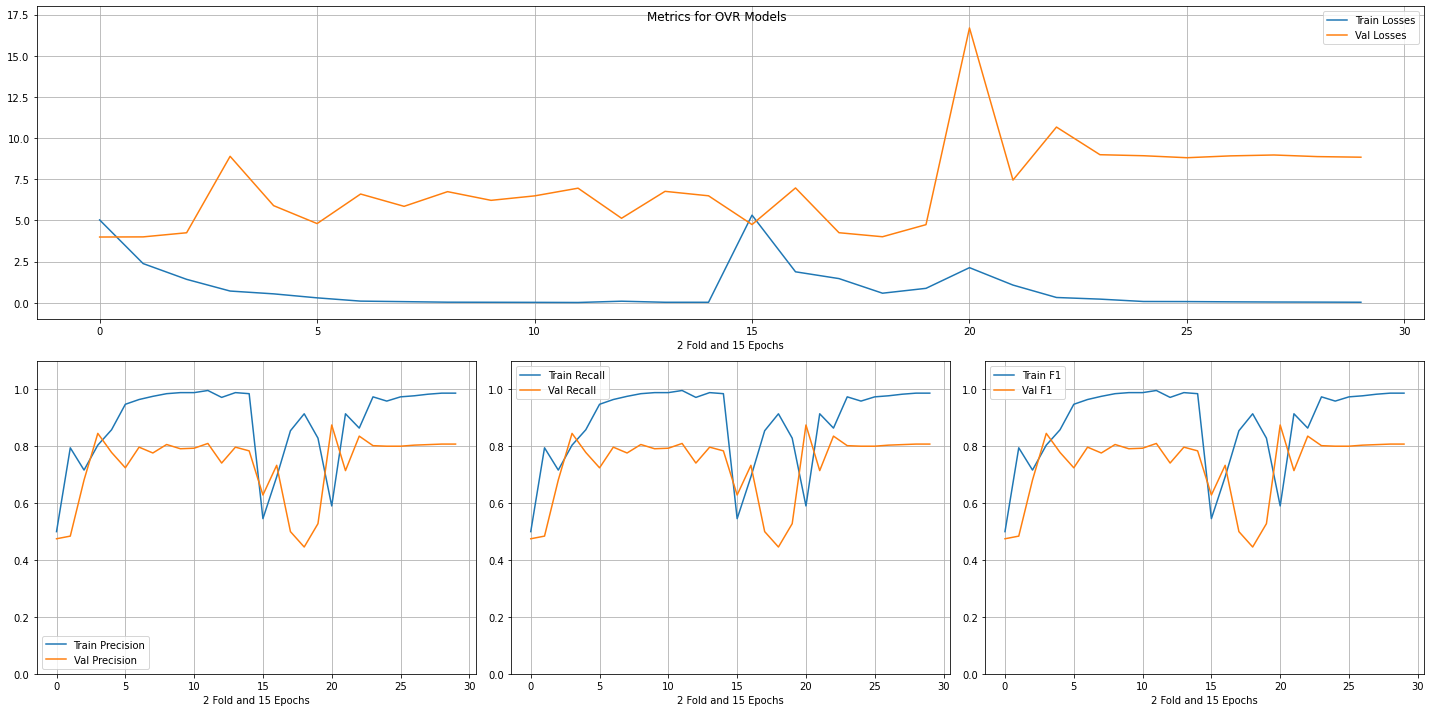

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.590317       0.875000  ...      2.131039          16.691311
3   0.804104       0.845438  ...      0.709933           8.894010
7   0.864060       0.835821  ...      0.318716          10.670454
11  0.996269       0.810056  ...      0.015337           6.958112
14  0.986965       0.807836  ...      0.030061           8.840393
13  0.986965       0.807836  ...      0.037650           8.876314
8   0.985075       0.806331  ...      0.033109           6.747462
12  0.983240       0.805970  ...      0.043659           8.974059
11  0.977654       0.804104  ...      0.055157           8.920500
8   0.973929       0.802239  ...      0.219293           8.991256
9   0.959032       0.800373  ...      0.075608           8.929338
10  0.973929       0.800373  ...      0.069880           8.808458
13  0.988806       0.797020  ...      0.028177           6.765709
6   0.964552       0.797020  ...      0.098080           6.603217
10  0.9888

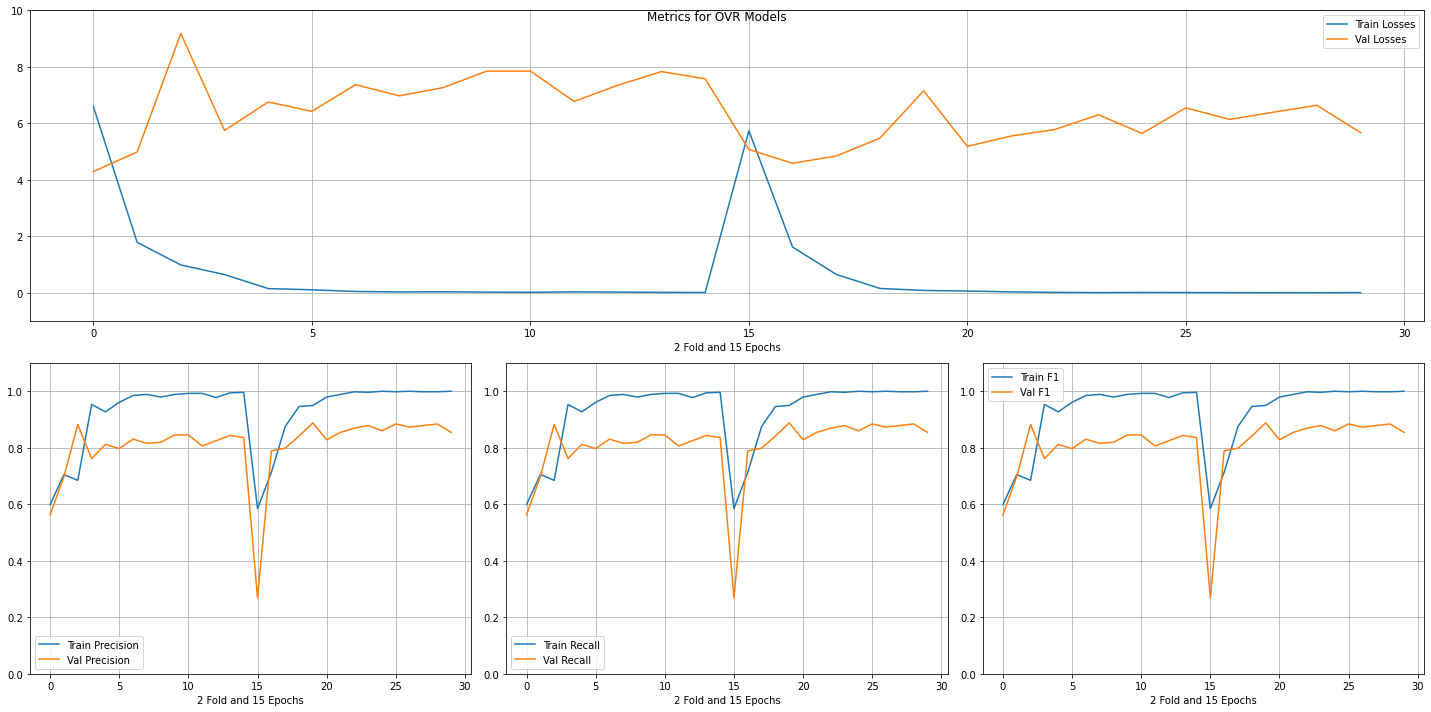

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.949721       0.888060  ...      0.088613           7.152533
13  0.998138       0.884328  ...      0.009608           6.642174
10  0.998138       0.884328  ...      0.014807           6.551376
2   0.684701       0.882682  ...      0.990579           9.183838
12  0.998138       0.878731  ...      0.010908           6.396549
8   0.996276       0.878731  ...      0.013307           6.304927
11  1.000000       0.873134  ...      0.011323           6.141702
7   0.998138       0.869403  ...      0.020525           5.783943
9   1.000000       0.860075  ...      0.018718           5.646097
6   0.988827       0.854478  ...      0.037484           5.553218
14  1.000000       0.854478  ...      0.012772           5.671273
9   0.988806       0.845438  ...      0.030042           7.851495
10  0.992537       0.845438  ...      0.022815           7.852246
13  0.994403       0.843575  ...      0.020405           7.833974
3   0.9459

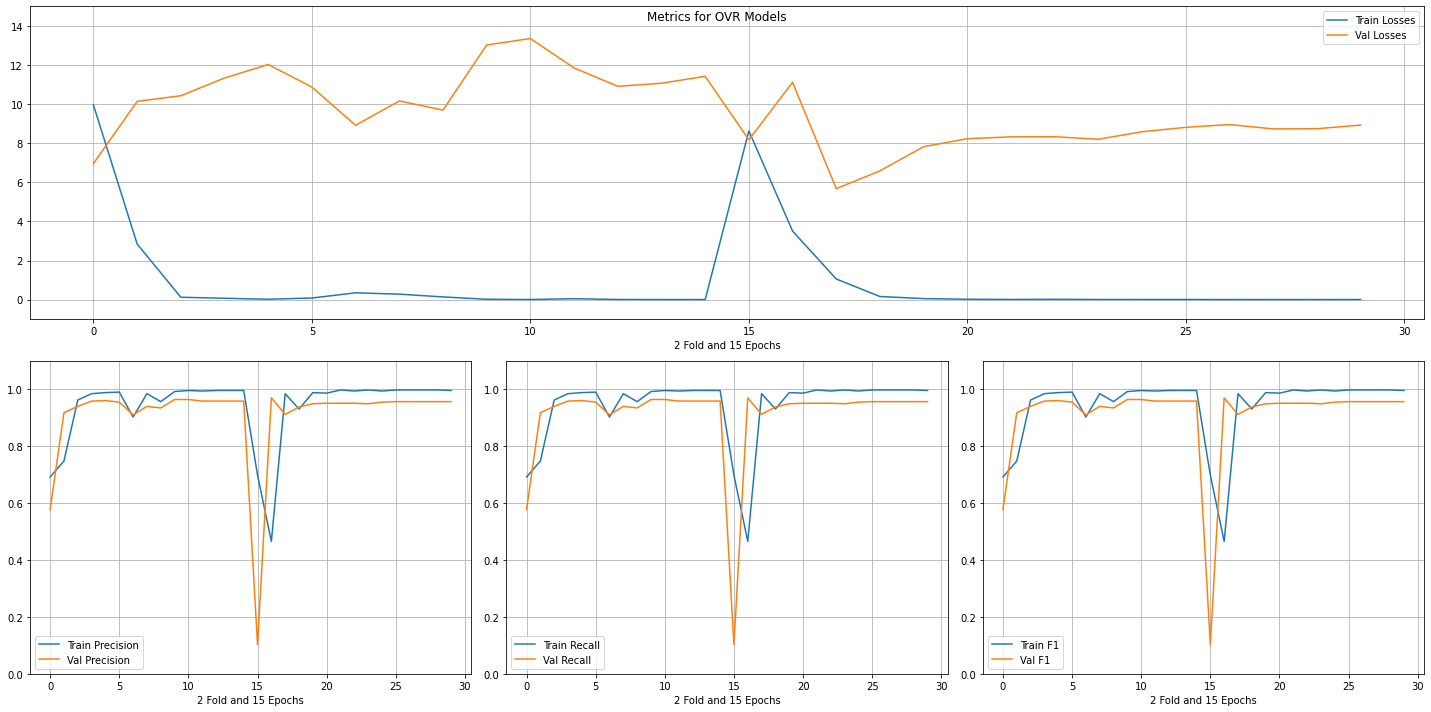

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.465549       0.970149  ...      3.506750          11.117652
9   0.992537       0.964618  ...      0.019787          13.026321
10  0.996269       0.964618  ...      0.006656          13.356560
4   0.988806       0.960894  ...      0.021347          12.027903
14  0.996269       0.959032  ...      0.005478          11.424200
12  0.996269       0.959032  ...      0.008068          10.913461
3   0.985075       0.959032  ...      0.070946          11.335983
13  0.996269       0.959032  ...      0.006070          11.068906
11  0.994403       0.959032  ...      0.047875          11.850629
11  0.998138       0.957090  ...      0.006162           8.955991
10  0.998138       0.957090  ...      0.007924           8.813615
13  0.998138       0.957090  ...      0.005357           8.743716
14  0.996276       0.957090  ...      0.007250           8.929198
12  0.998138       0.957090  ...      0.007063           8.733971
5   0.9906

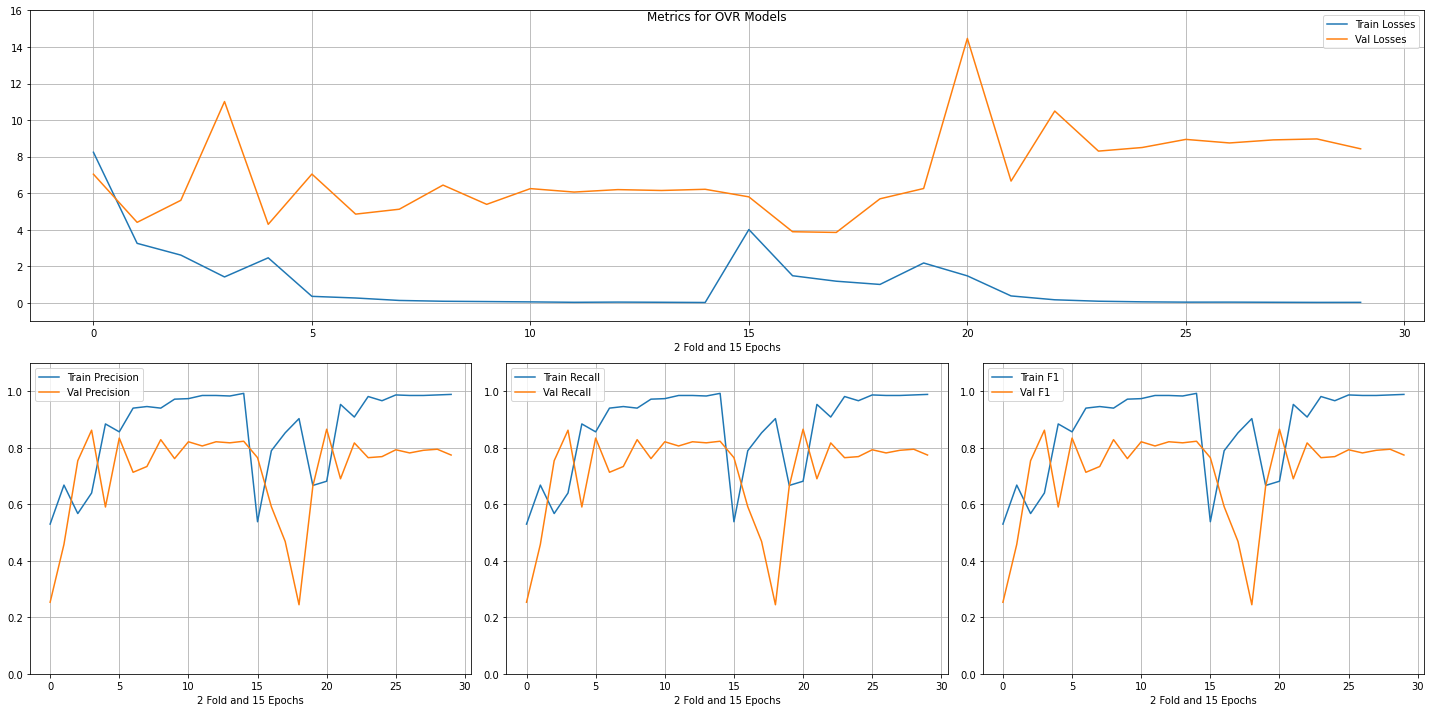

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.681564       0.865672  ...      1.479159          14.467490
3   0.639925       0.862197  ...      1.421040          11.014798
5   0.856343       0.834264  ...      0.359130           7.046894
8   0.940299       0.828678  ...      0.090852           6.444816
14  0.992537       0.823091  ...      0.023118           6.215277
12  0.985075       0.821229  ...      0.045048           6.197409
10  0.973881       0.821229  ...      0.056278           6.252111
13  0.983209       0.817505  ...      0.035325           6.149752
7   0.908752       0.817164  ...      0.171287          10.494625
11  0.985075       0.806331  ...      0.033796           6.063666
13  0.986965       0.794776  ...      0.028861           8.969721
10  0.986965       0.792910  ...      0.042185           8.944048
12  0.985102       0.791045  ...      0.035348           8.917404
11  0.985102       0.781716  ...      0.043536           8.749615
14  0.9888

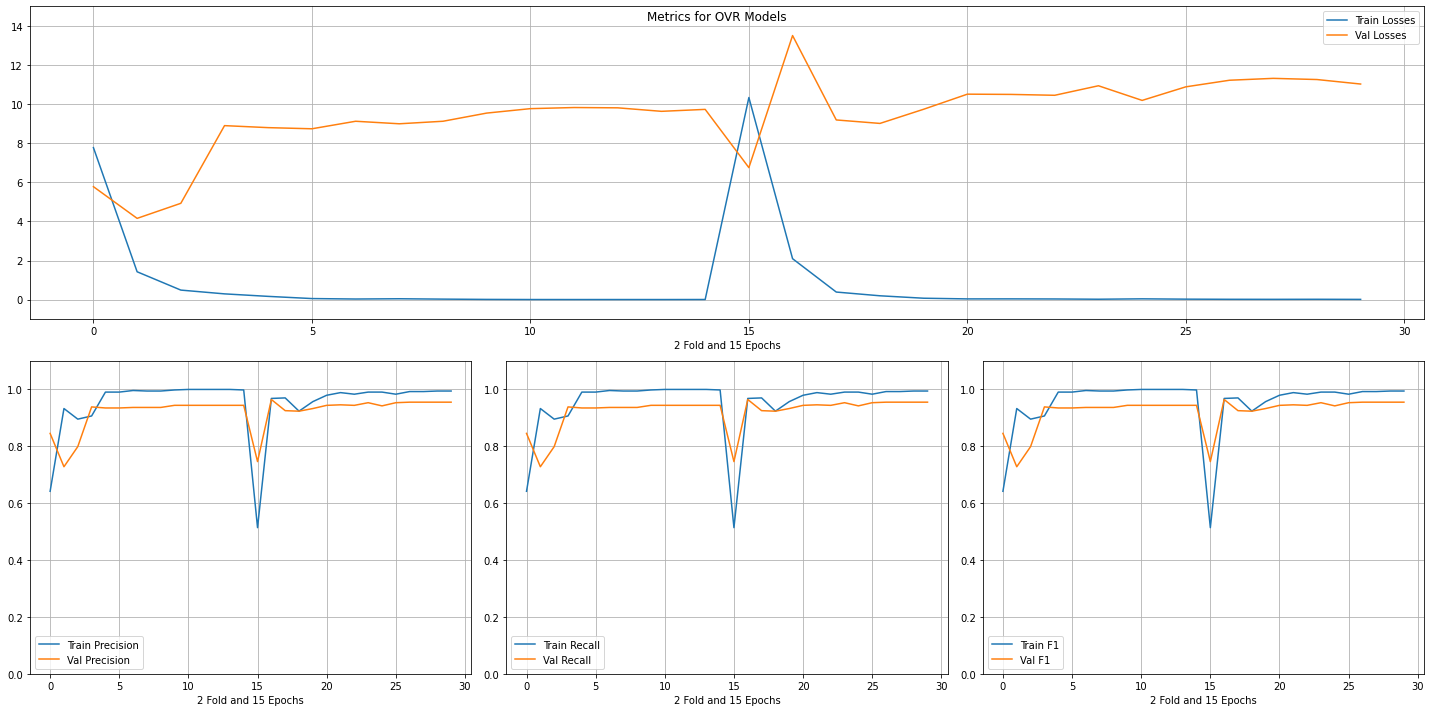

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.968343       0.964552  ...      2.095069          13.509035
14  0.994413       0.955224  ...      0.013548          11.028799
11  0.992551       0.955224  ...      0.017773          11.223093
13  0.994413       0.955224  ...      0.018585          11.259390
12  0.992551       0.955224  ...      0.015837          11.319119
8   0.990689       0.953358  ...      0.021315          10.940552
10  0.983240       0.953358  ...      0.025143          10.885845
6   0.988827       0.945896  ...      0.039554          10.498015
13  1.000000       0.944134  ...      0.005339           9.632795
9   0.998134       0.944134  ...      0.012362           9.542855
10  1.000000       0.944134  ...      0.006361           9.769954
11  1.000000       0.944134  ...      0.005549           9.826992
12  1.000000       0.944134  ...      0.006112           9.811746
14  0.998134       0.944134  ...      0.007426           9.732361
5   0.9795

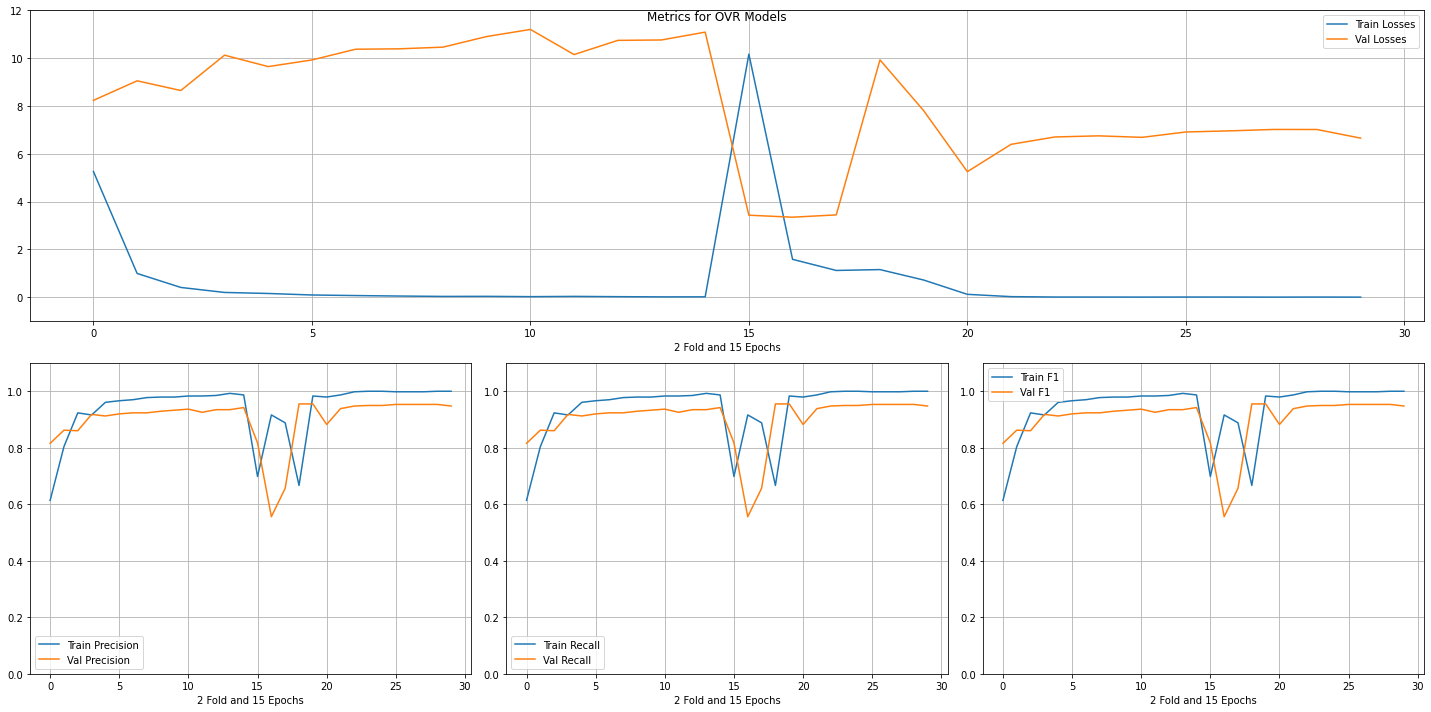

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.983240       0.955224  ...      0.721894           7.807281
3   0.666667       0.955224  ...      1.158980           9.929014
10  0.998138       0.953358  ...      0.010790           6.914385
11  0.998138       0.953358  ...      0.010352           6.961509
12  0.998138       0.953358  ...      0.007179           7.020204
13  1.000000       0.953358  ...      0.010268           7.018264
9   1.000000       0.949627  ...      0.008496           6.690297
8   1.000000       0.949627  ...      0.010196           6.752683
7   0.998138       0.947761  ...      0.010915           6.705400
14  1.000000       0.947761  ...      0.007089           6.657411
14  0.986940       0.942272  ...      0.018777          11.091315
6   0.986965       0.938433  ...      0.027462           6.397063
10  0.983209       0.936685  ...      0.026948          11.203780
12  0.985075       0.934823  ...      0.026092          10.746256
13  0.9925

In [50]:
jovr_res_reduced = ovr_train_model(data, MelsJanakaRagaDataset, MelRaga,
                                   "OVR Models", jlabels1, cl, lbl_encoder=jle,
                                   target='JanakaRagamCode', lr=1e-5, epochs=15, n_folds=2, feature='mel_spec')

In [51]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.966418  ...      0.008427           9.571129
13  1.000000       0.966418  ...      0.005572           9.566636
12  0.998138       0.966418  ...      0.008379           9.426805
11  1.000000       0.966418  ...      0.007494           9.547431
7   0.994413       0.966418  ...      0.017200           9.364380

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.988827       0.981343  ...      0.046391          10.993376
14  1.000000       0.979516  ...      0.001189          10.193481
13  1.000000       0.979516  ...      0.000738          10.256129
12  1.000000       0.979516  ...      0.001572          10.229972
11  1.000000       0.979516  ...      0.000743          10.129302

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.700186       0.904851  ...      0.999308      

# OVR Experiment 2 - LSTM Model

In [52]:
class MelsLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=1):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,40),
                                nn.GELU(),
                                nn.Linear(40,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

In [53]:
def ovr_train_model_lstm(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, 
                         target='RagamCode', feature='mfcc', epochs=20, lr=1e-3):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: print(f'Training for {lbl_encoder.inverse_transform([i])} with {nsamples} positive samples')
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : True,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : 2,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/15 : Training Loss: 0.689 / Validation Loss : 0.686 [Time Taken : 7.039244 seconds]
Epoch 2/15 : Training Loss: 0.642 / Validation Loss : 0.682 [Time Taken : 6.852127 seconds]
Epoch 3/15 : Training Loss: 0.600 / Validation Loss : 0.671 [Time Taken : 6.873346 seconds]
Epoch 4/15 : Training Loss: 0.542 / Validation Loss : 0.674 [Time Taken : 6.846126 seconds]
Epoch 5/15 : Training Loss: 0.463 / Validation Loss : 0.693 [Time Taken : 6.840699 seconds]
Epoch 6/15 : Training Loss: 0.368 / Validation Loss : 0.752 [Time Taken : 6.915846 seconds]
Epoch 7/15 : Training Loss: 0.263 / Validation Loss : 0.858 [Time Taken : 6.85556 seconds]
Epoch 8/15 : Training Loss: 0.172 / Validation Loss : 0.991 [Time Taken : 6.846027 seconds]
Epoch 9/15 : Training Loss: 0.110 / Validation Loss : 1.136 [Time Taken : 6.816784 seconds]
Epoch 10/15 : Training Loss: 0.063 /

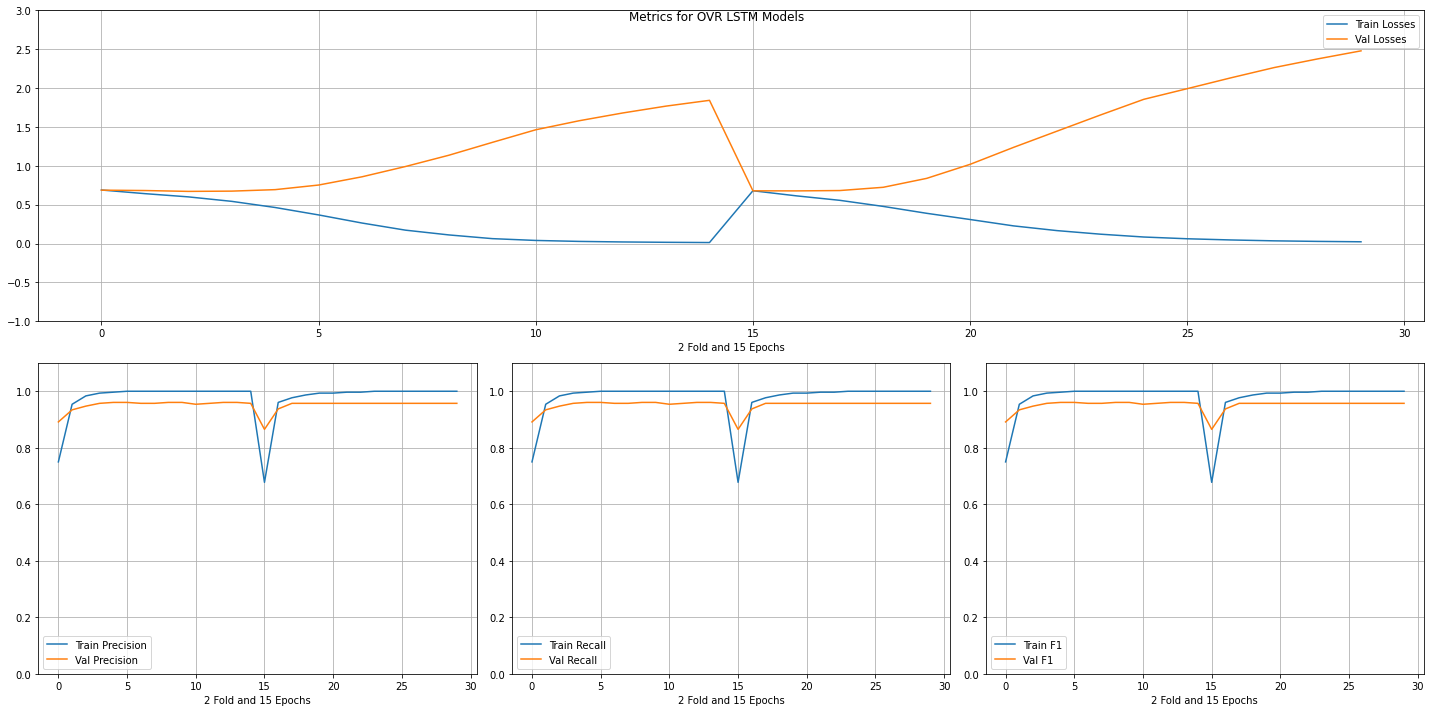

    train_f1  validation_f1  ...  train_losses  validation_losses
8   1.000000       0.960526  ...      0.110331           1.136071
4   0.996711       0.960526  ...      0.463315           0.693156
5   1.000000       0.960526  ...      0.367778           0.752384
13  1.000000       0.960526  ...      0.015420           1.768241
12  1.000000       0.960526  ...      0.019854           1.679688
9   1.000000       0.960526  ...      0.062573           1.301394
7   0.996711       0.957237  ...      0.165967           1.445585
4   0.993421       0.957237  ...      0.388625           0.838179
5   0.993421       0.957237  ...      0.308733           1.018854
6   0.996711       0.957237  ...      0.226699           1.237125
14  1.000000       0.957237  ...      0.022059           2.479360
2   0.976974       0.957237  ...      0.555663           0.681490
8   1.000000       0.957237  ...      0.119997           1.653644
9   1.000000       0.957237  ...      0.083394           1.855735
10  1.0000

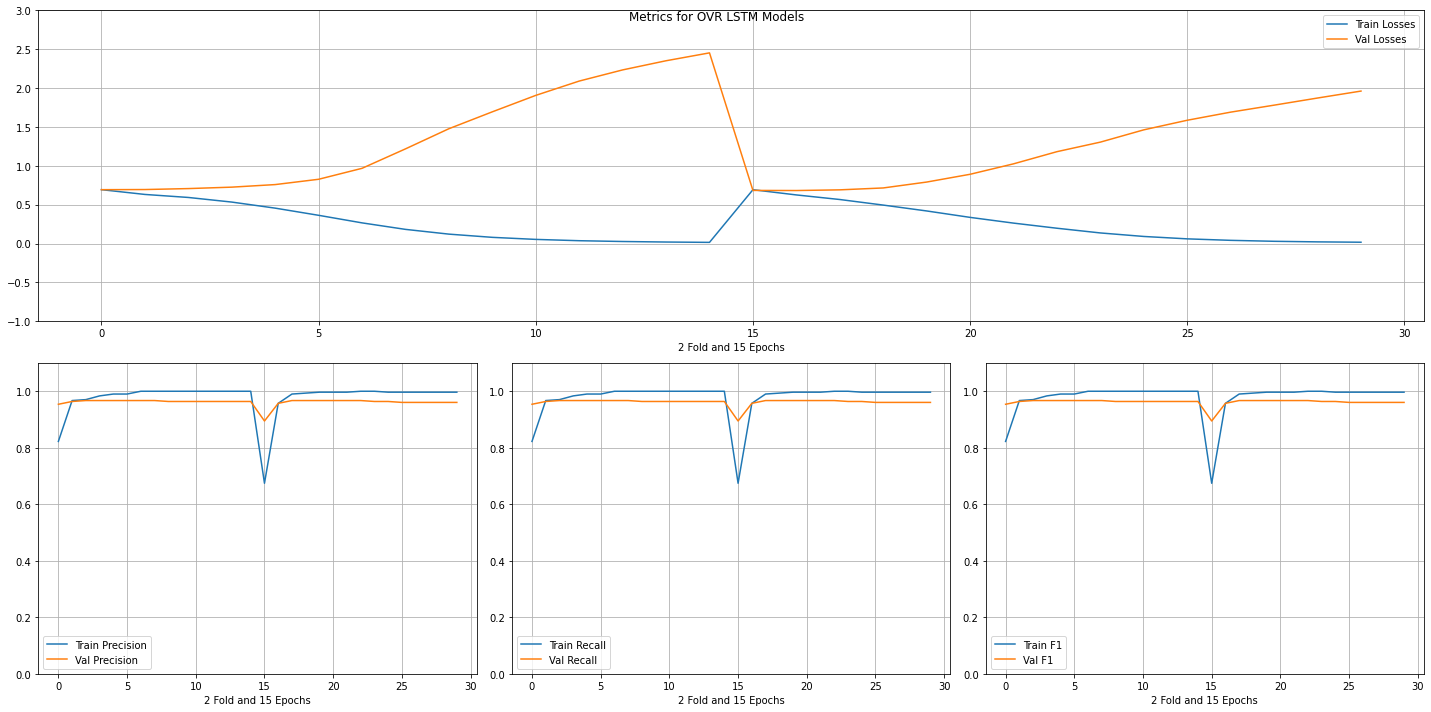

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.970395       0.967105  ...      0.592602           0.706724
3   0.983553       0.967105  ...      0.533207           0.725238
4   0.990132       0.967105  ...      0.455178           0.758225
5   0.990132       0.967105  ...      0.362871           0.826524
6   1.000000       0.967105  ...      0.265472           0.967529
7   1.000000       0.967105  ...      0.181744           1.217801
7   1.000000       0.967105  ...      0.196430           1.181925
6   0.996711       0.967105  ...      0.262394           1.025269
5   0.996711       0.967105  ...      0.336146           0.890842
4   0.996711       0.967105  ...      0.418855           0.790789
3   0.993421       0.967105  ...      0.494444           0.714941
2   0.990132       0.967105  ...      0.566102           0.690492
14  1.000000       0.963816  ...      0.014559           2.453328
1   0.967105       0.963816  ...      0.631434           0.694493
12  1.0000

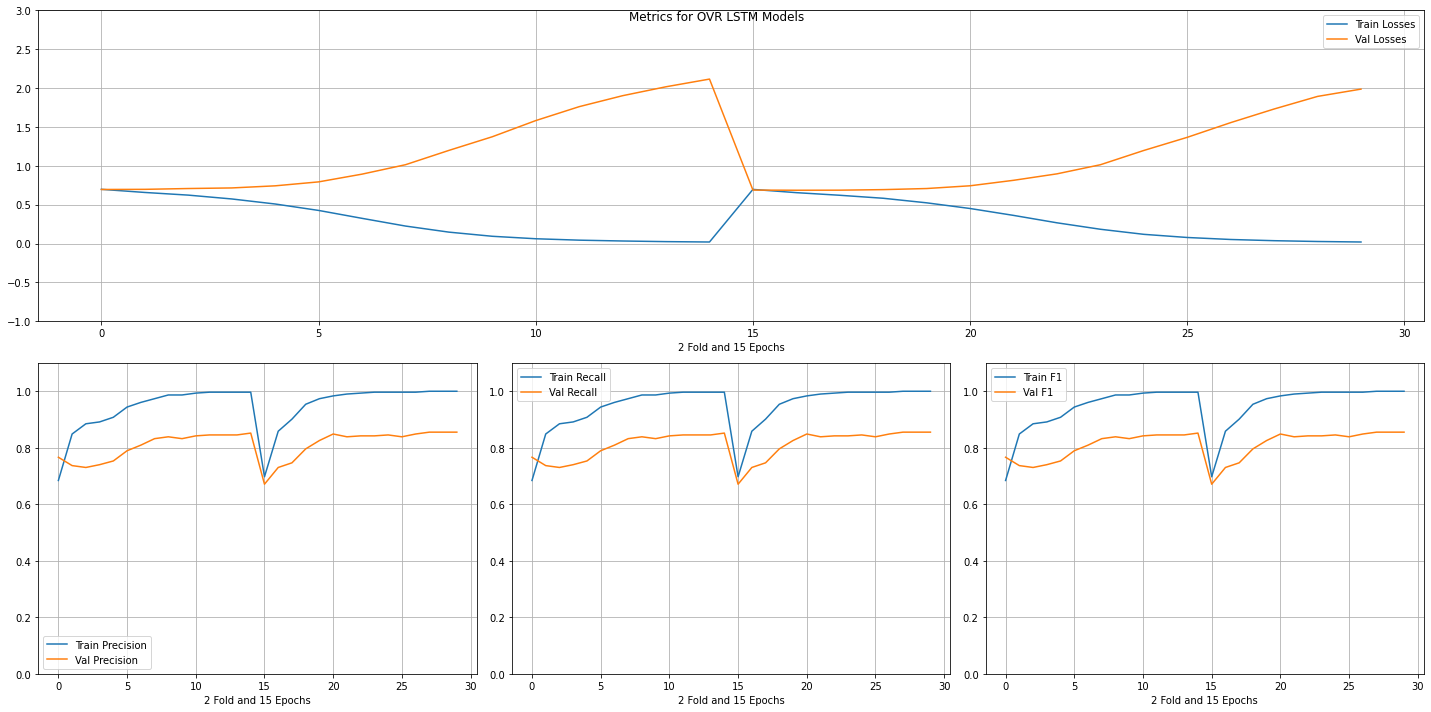

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.855263  ...      0.019359           1.987000
13  1.000000       0.855263  ...      0.025785           1.893144
12  1.000000       0.855263  ...      0.036148           1.731083
14  0.996711       0.851974  ...      0.019260           2.115983
11  0.996711       0.848684  ...      0.051600           1.555722
5   0.983553       0.848684  ...      0.450358           0.742833
12  0.996711       0.845395  ...      0.032200           1.902325
9   0.996711       0.845395  ...      0.117943           1.197398
13  0.996711       0.845395  ...      0.024102           2.017232
11  0.996711       0.845395  ...      0.042919           1.761096
10  0.993421       0.842105  ...      0.061148           1.582011
7   0.993421       0.842105  ...      0.266310           0.896412
8   0.996711       0.842105  ...      0.183273           1.013712
8   0.986842       0.838816  ...      0.146333           1.198158
10  0.9967

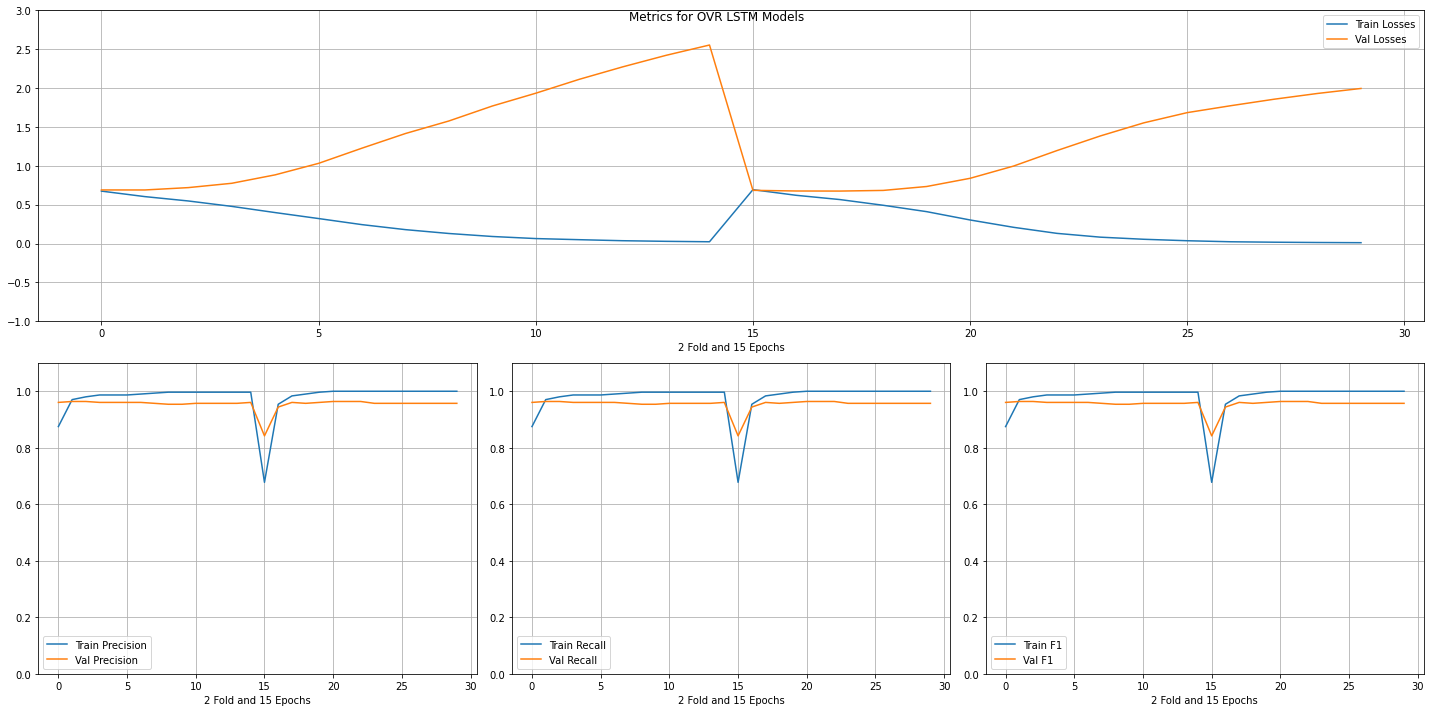

    train_f1  validation_f1  ...  train_losses  validation_losses
5   1.000000       0.963816  ...      0.302742           0.839124
2   0.980263       0.963816  ...      0.547393           0.719299
6   1.000000       0.963816  ...      0.208338           0.996490
1   0.970395       0.963816  ...      0.603495           0.689021
7   1.000000       0.963816  ...      0.130382           1.195982
4   0.996711       0.960526  ...      0.409865           0.733637
2   0.983553       0.960526  ...      0.565610           0.674762
14  0.996711       0.960526  ...      0.022311           2.554391
0   0.875000       0.960526  ...      0.674216           0.689232
6   0.990132       0.960526  ...      0.242769           1.227129
5   0.986842       0.960526  ...      0.321078           1.031537
4   0.986842       0.960526  ...      0.397966           0.883493
3   0.986842       0.960526  ...      0.477752           0.774895
12  1.000000       0.957237  ...      0.016626           1.856966
10  1.0000

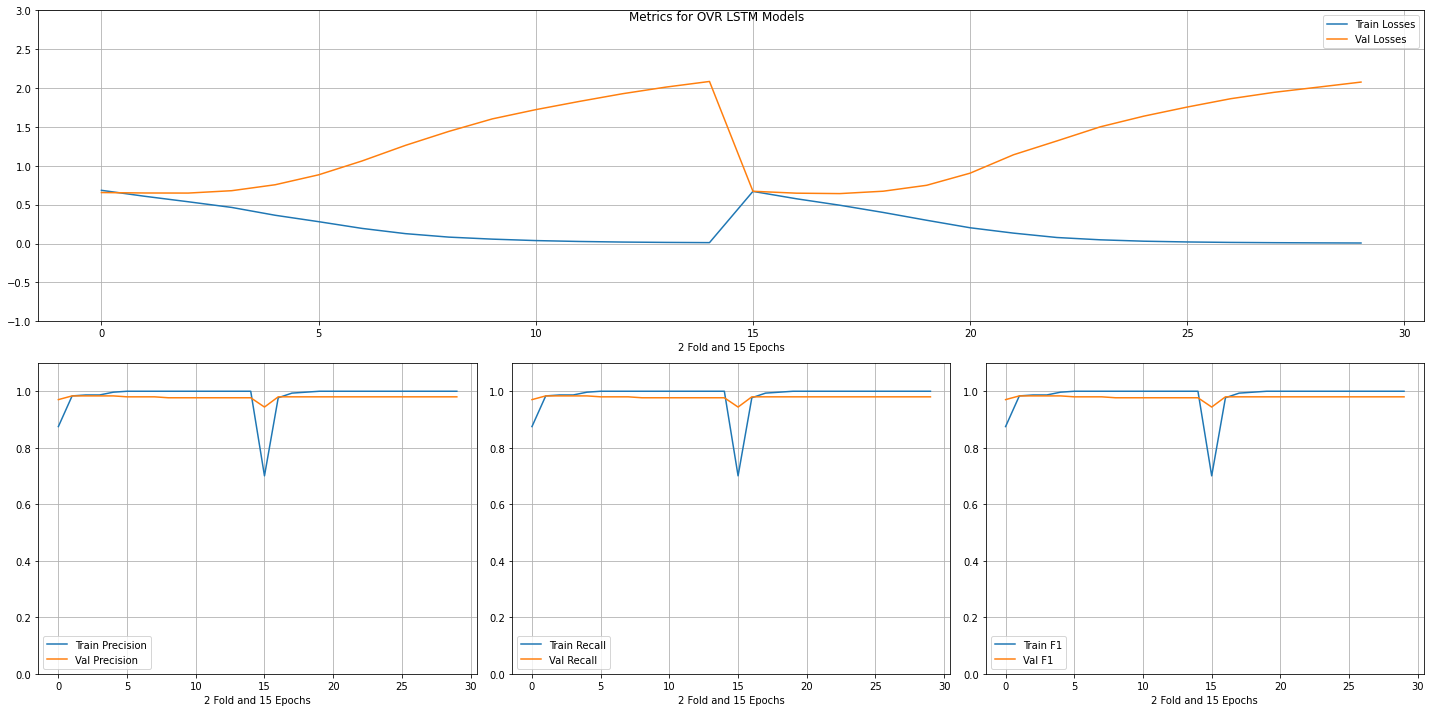

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.986842       0.983553  ...      0.537119           0.649030
3   0.986842       0.983553  ...      0.464122           0.679634
4   0.996711       0.983553  ...      0.363384           0.756119
1   0.983553       0.983553  ...      0.607500           0.650098
14  1.000000       0.980263  ...      0.006370           2.077524
1   0.976974       0.980263  ...      0.575828           0.647695
11  1.000000       0.980263  ...      0.013948           1.863456
10  1.000000       0.980263  ...      0.019801           1.756258
9   1.000000       0.980263  ...      0.029626           1.639072
8   1.000000       0.980263  ...      0.047347           1.501900
7   1.000000       0.980263  ...      0.077117           1.320310
6   1.000000       0.980263  ...      0.133468           1.142098
5   1.000000       0.980263  ...      0.202559           0.905150
4   1.000000       0.980263  ...      0.299079           0.749211
3   0.9967

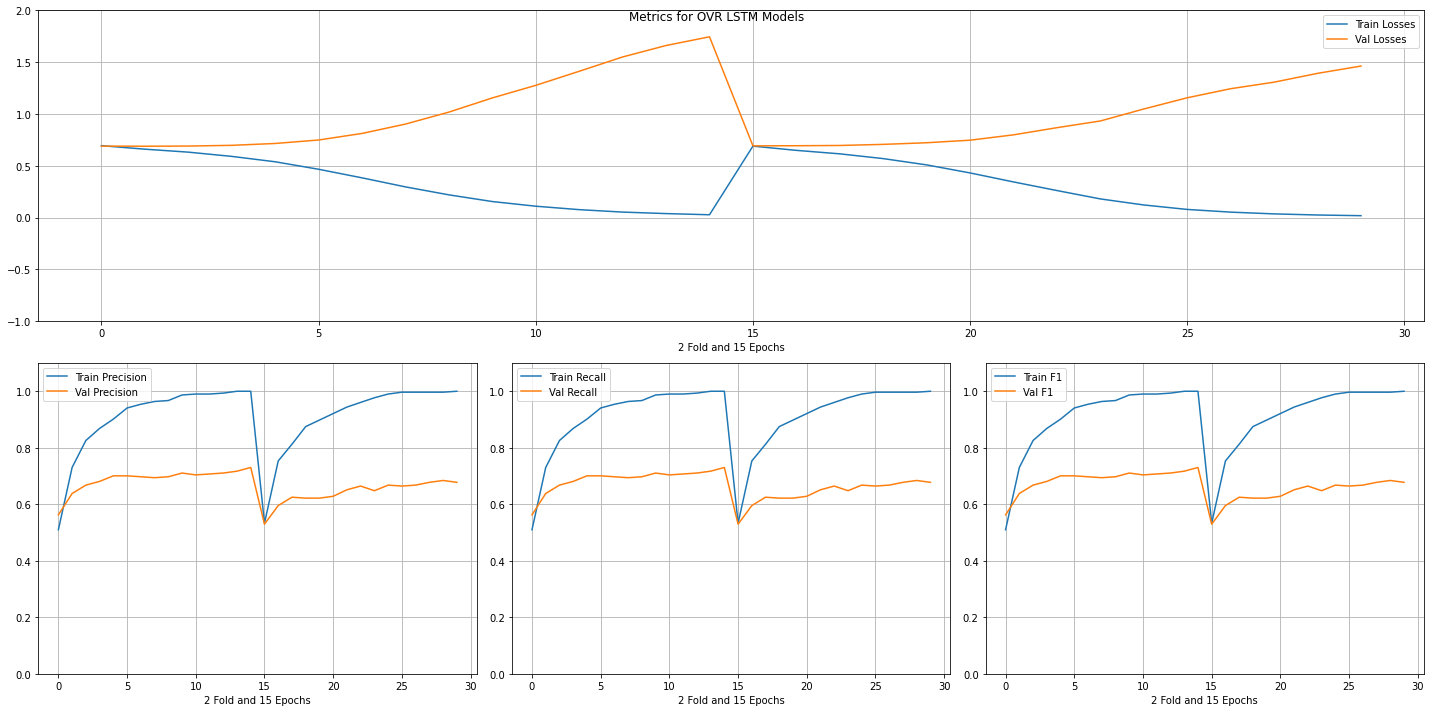

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.730263  ...      0.027436           1.745068
13  1.000000       0.717105  ...      0.038713           1.661073
9   0.986842       0.710526  ...      0.154947           1.155118
12  0.993421       0.710526  ...      0.053230           1.550597
11  0.990132       0.707237  ...      0.076736           1.412423
10  0.990132       0.703947  ...      0.109967           1.276576
4   0.901316       0.700658  ...      0.538862           0.715519
5   0.940789       0.700658  ...      0.466566           0.748935
6   0.953947       0.697368  ...      0.383763           0.812347
8   0.967105       0.697368  ...      0.219540           1.018358
7   0.963816       0.694079  ...      0.296493           0.902742
13  0.996711       0.684211  ...      0.025072           1.392350
3   0.868421       0.680921  ...      0.590871           0.697587
14  1.000000       0.677632  ...      0.018520           1.462927
12  0.9967

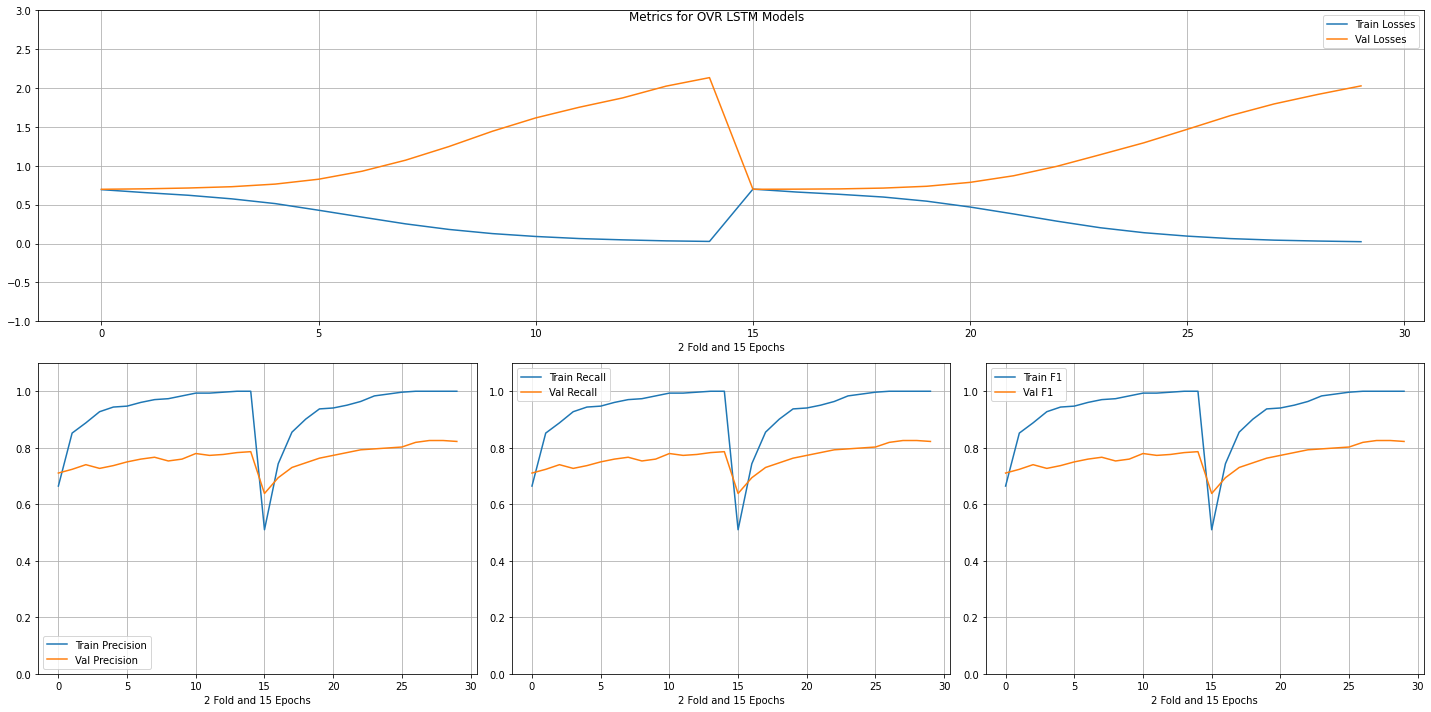

    train_f1  validation_f1  ...  train_losses  validation_losses
12  1.000000       0.825658  ...      0.043195           1.796242
13  1.000000       0.825658  ...      0.031709           1.917882
14  1.000000       0.822368  ...      0.023199           2.028404
11  1.000000       0.819079  ...      0.063004           1.647023
10  0.996711       0.802632  ...      0.094956           1.469705
9   0.990132       0.799342  ...      0.139044           1.295884
8   0.983553       0.796053  ...      0.202629           1.143483
7   0.963816       0.792763  ...      0.287244           0.993676
14  1.000000       0.786184  ...      0.026627           2.134867
6   0.950658       0.782895  ...      0.380327           0.871694
13  1.000000       0.782895  ...      0.033965           2.025034
10  0.993421       0.779605  ...      0.090444           1.616640
12  0.996711       0.776316  ...      0.046949           1.873667
11  0.993421       0.773026  ...      0.063645           1.753326
5   0.9407

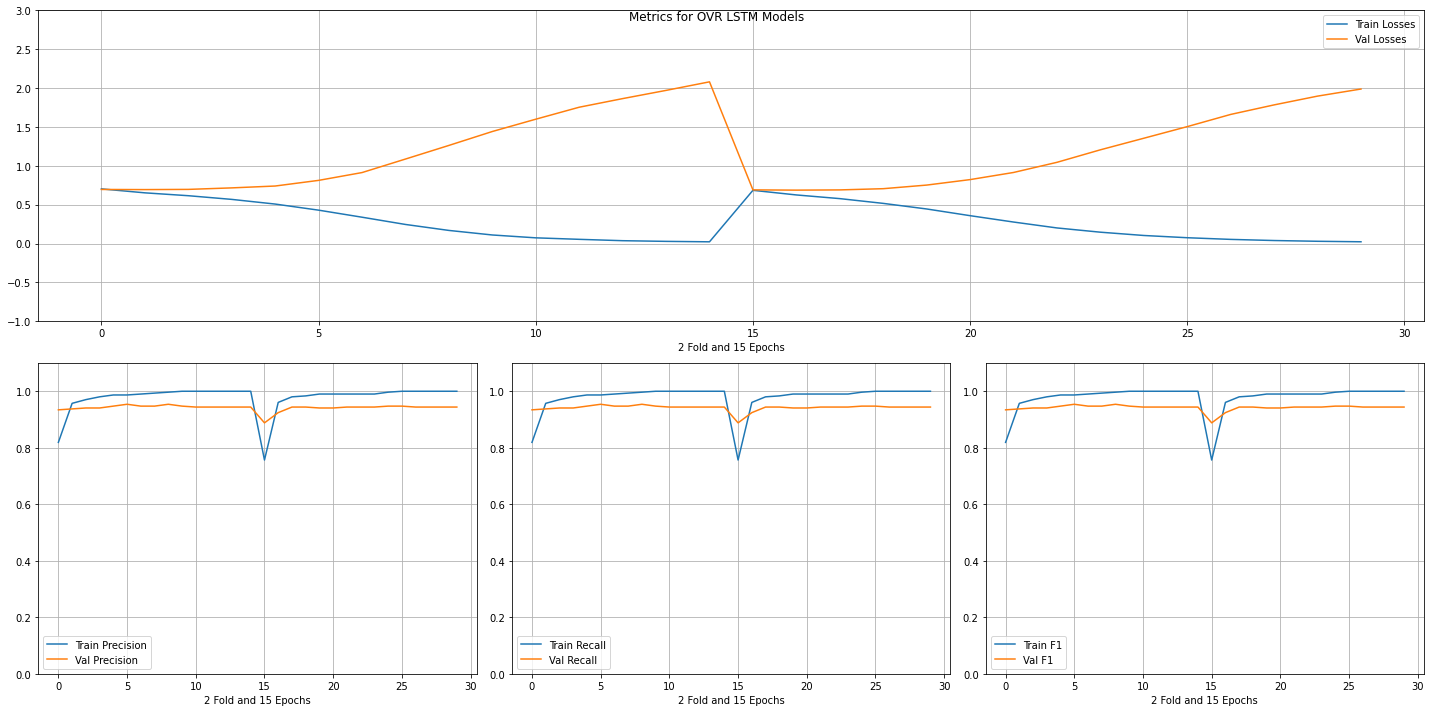

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.986842       0.953947  ...      0.429122           0.812433
8   0.996711       0.953947  ...      0.168225           1.262241
10  1.000000       0.947368  ...      0.074298           1.504263
9   0.996711       0.947368  ...      0.103191           1.354761
4   0.986842       0.947368  ...      0.507571           0.739680
6   0.990132       0.947368  ...      0.338380           0.912892
7   0.993421       0.947368  ...      0.245083           1.086890
9   1.000000       0.947368  ...      0.109644           1.441388
14  1.000000       0.944079  ...      0.022186           1.988123
13  1.000000       0.944079  ...      0.028538           1.896849
8   0.990132       0.944079  ...      0.145510           1.205830
7   0.990132       0.944079  ...      0.200204           1.044818
6   0.990132       0.944079  ...      0.276193           0.914027
3   0.983553       0.944079  ...      0.516352           0.705405
2   0.9802

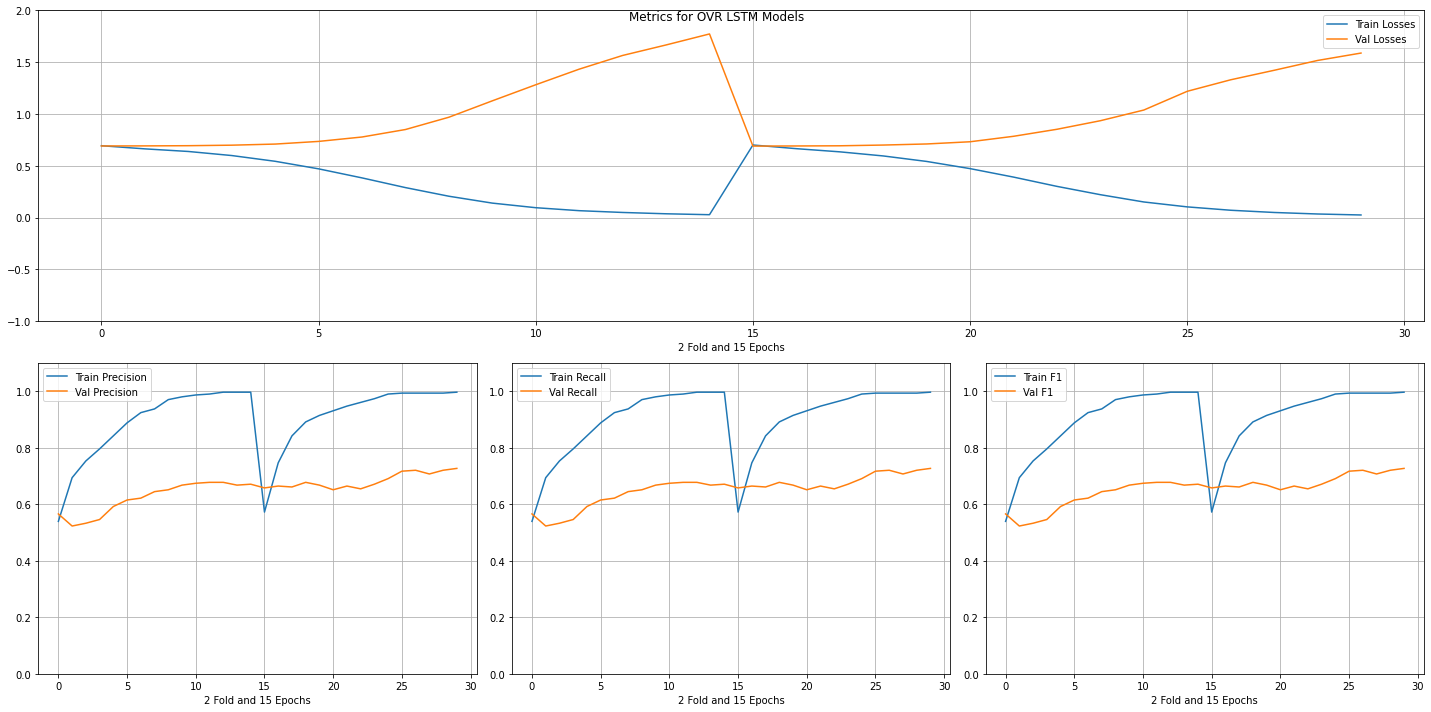

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.996711       0.726974  ...      0.025332           1.588218
13  0.993421       0.720395  ...      0.034830           1.516736
11  0.993421       0.720395  ...      0.070950           1.330273
10  0.993421       0.717105  ...      0.103400           1.219170
12  0.993421       0.707237  ...      0.049463           1.421850
9   0.990132       0.690789  ...      0.150831           1.038266
3   0.891447       0.677632  ...      0.595122           0.700242
11  0.990132       0.677632  ...      0.066825           1.432849
12  0.996711       0.677632  ...      0.049614           1.565077
10  0.986842       0.674342  ...      0.095523           1.282369
14  0.996711       0.671053  ...      0.027942           1.772677
8   0.973684       0.671053  ...      0.221073           0.935217
4   0.914474       0.667763  ...      0.542071           0.710777
9   0.980263       0.667763  ...      0.139809           1.127131
13  0.9967

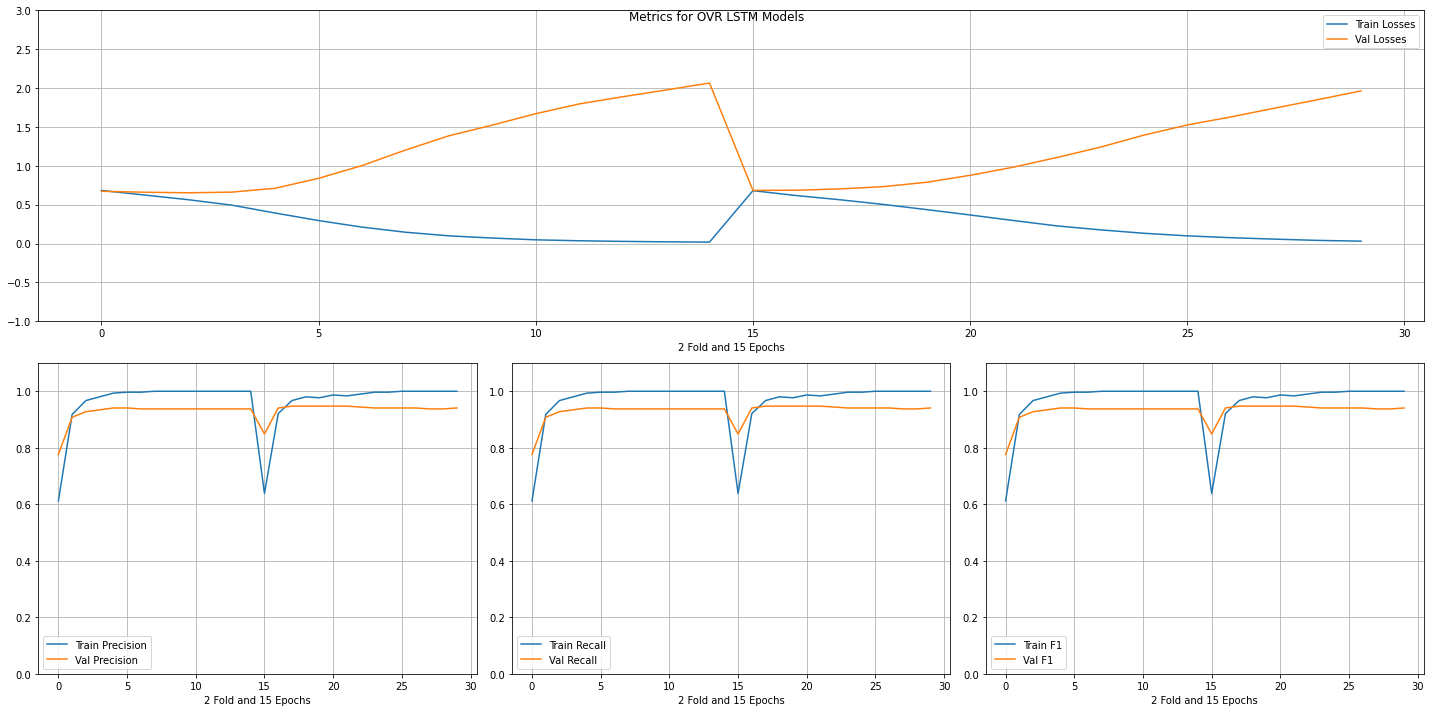

    train_f1  validation_f1  ...  train_losses  validation_losses
6   0.983553       0.947368  ...      0.295441           0.982888
5   0.986842       0.947368  ...      0.367243           0.877456
4   0.976974       0.947368  ...      0.436142           0.788218
3   0.980263       0.947368  ...      0.502950           0.731618
2   0.967105       0.947368  ...      0.563358           0.702378
7   0.990132       0.944079  ...      0.226503           1.107171
14  1.000000       0.940789  ...      0.030216           1.964006
1   0.921053       0.940789  ...      0.616932           0.685582
11  1.000000       0.940789  ...      0.074847           1.628824
10  1.000000       0.940789  ...      0.098498           1.525206
4   0.993421       0.940789  ...      0.392068           0.710791
5   0.996711       0.940789  ...      0.295017           0.839083
9   0.996711       0.940789  ...      0.131757           1.394864
8   0.996711       0.940789  ...      0.175401           1.239912
14  1.0000

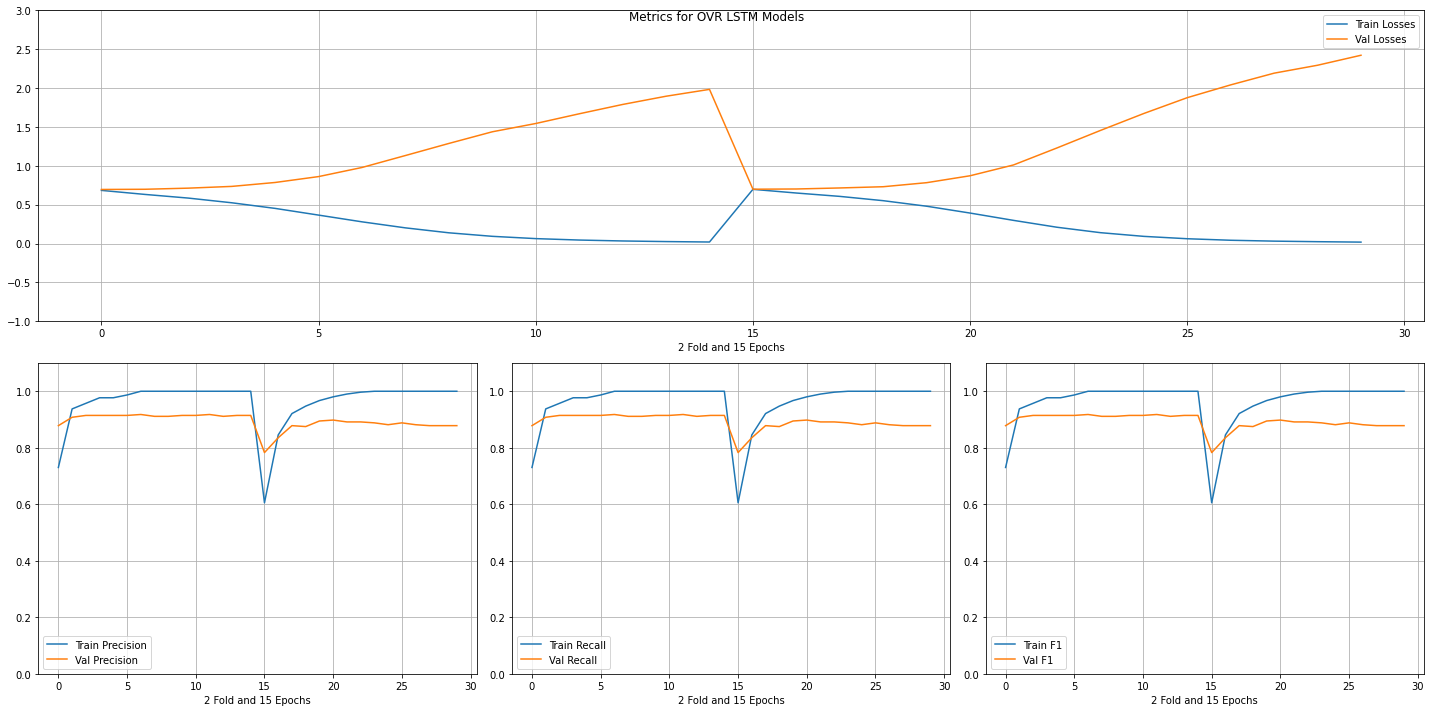

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.917763  ...      0.044442           1.669330
6   1.000000       0.917763  ...      0.278837           0.978482
10  1.000000       0.914474  ...      0.062864           1.544455
2   0.957237       0.914474  ...      0.584517           0.712331
3   0.976974       0.914474  ...      0.524158           0.734834
4   0.976974       0.914474  ...      0.451765           0.785374
5   0.986842       0.914474  ...      0.365441           0.861243
14  1.000000       0.914474  ...      0.019171           1.983570
13  1.000000       0.914474  ...      0.024772           1.895399
9   1.000000       0.914474  ...      0.092345           1.437825
12  1.000000       0.911184  ...      0.032587           1.789398
8   1.000000       0.911184  ...      0.137658           1.287799
7   1.000000       0.911184  ...      0.201154           1.132391
1   0.937500       0.907895  ...      0.631732           0.697965
5   0.9802

In [54]:
jovr_res_reduced = ovr_train_model_lstm(rdata, MelsJanakaRagaDataset, MelsLstmModel, "OVR LSTM Models", jlabels1, cl, lbl_encoder=jle, 
                                        target='JanakaRagamCode', feature='mel_spec', epochs=15, lr=1e-3)

In [55]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
8   1.000000       0.960526  ...      0.110331           1.136071
4   0.996711       0.960526  ...      0.463315           0.693156
5   1.000000       0.960526  ...      0.367778           0.752384
13  1.000000       0.960526  ...      0.015420           1.768241
12  1.000000       0.960526  ...      0.019854           1.679688

[5 rows x 8 columns]
['Hanumatodi']
   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.970395       0.967105  ...      0.592602           0.706724
3  0.983553       0.967105  ...      0.533207           0.725238
4  0.990132       0.967105  ...      0.455178           0.758225
5  0.990132       0.967105  ...      0.362871           0.826524
6  1.000000       0.967105  ...      0.265472           0.967529

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.855263  ...      0.019359           1